In [19]:
import pandas as pd
import os
import time
import numpy as np
import scipy.optimize as sco
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import LabelEncoder

In [2]:
def read_file(filePath):
#读取文件下的所有文件数据
    filelist = os.listdir(filePath)
    info = []
    total_info = []
    for path in filelist:                  #读取一级文件目录
        first_domain = os.path.abspath(filePath)
        first_path = os.path.join(first_domain,path)    
        second_file_list = os.listdir(first_path)
        for path in second_file_list:               #读取二级文件目录
            second_path = os.path.join(first_path,path)
#             code = path.split('.')[0]        #保存文件名信息，作为和后面基金公司连接的主键
            try:
                info = pd.read_csv(second_path)    #读取文件内容
#                 info['code'] = code              #添加合并主键
                total_info.append(info)
            except:
                print('file not found')

    return total_info

'load data'
filepath = '/home/team36/fanjiakuan/data/funds/nav'
info = read_file(filepath)


'根据字段名称划分基金类型'
daily_non = []
for i in range(len(info)):
    if 'unit_net_value' in info[i]:   #非日结型
        daily_non.append(info[i])

'删除不用的列'
for i in range(len(daily_non)):
    daily_non[i].drop(['acc_net_value', 'adjusted_net_value'],axis = 1, inplace=True)
    

'过滤掉基金交易日小于：252*0.4*5 小于5年交易日的四成'
daily_non_filter = []
for i in range(len(daily_non)):
    daily_non[i].dropna(axis=0, how='any', inplace=True)
    if len(daily_non[i])>= 504:
        daily_non_filter.append(daily_non[i])


'将序列转换成监督学习问题'
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg



In [3]:
daily_non_filter[1]

,datetime,unit_net_value,subscribe_status,redeem_status
0,2015-11-20,1.002,Open,Open
1,2015-11-23,1.002,Open,Open
2,2015-11-24,1.003,Open,Open
3,2015-11-25,1.003,Open,Open
4,2015-11-26,1.003,Open,Open
5,2015-11-27,1.002,Open,Open
6,2015-11-30,1.002,Open,Open
7,2015-12-01,1.002,Open,Open
8,2015-12-02,1.002,Open,Open
9,2015-12-03,1.002,Open,Open


In [ ]:
start_time = time.clock()
print('-----------starting-----------')
# 设计网络
model = Sequential()
model.add(LSTM(50, input_shape=(1, 3)))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

daily_non_filter_len = len(daily_non_filter)

y_predict = []

for i in range(daily_non_filter_len):
    

    values = daily_non_filter[i].set_index('datetime')        #取第一个元素测试
    encoder = LabelEncoder()              # 整数编码方向 

    values['subscribe_status'] = encoder.fit_transform(values['subscribe_status'])
    values['redeem_status'] = encoder.fit_transform(values['redeem_status'])
    values = values.astype('float32')          # 确保所有数据是浮动的

    scaler = MinMaxScaler(feature_range=(0, 1))        # 归一化特征
    scaled = scaler.fit_transform(values)

    reframed = series_to_supervised(scaled, 1, 1)       # 构建成监督学习问题

    reframed = reframed.drop(reframed.columns[[4,5]], axis=1)       # 丢弃不想预测的列
    # print(reframed.head())
   
    values = reframed.values
#     split_pos = int(len(values) * 0.9)
    train = values[:-30, :]
    test = values[-30:, :]
    
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # 把输入重塑成3D格式 [样例， 时间步, 特征]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    # print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


    
    # 拟合网络
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)
    # 绘制历史数据
#     pyplot.plot(history.history['loss'], label='train')
#     pyplot.plot(history.history['val_loss'], label='test')
#     pyplot.legend()
#     pyplot.show()

    # 预测
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # 反向缩放预测值
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # 反向缩放实际值
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # 计算RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    y_predict.append(inv_yhat)
    if i%50==0:
        y_predict_df = pd.DataFrame(y_predict)
        y_predict_df.to_csv('../output/price_30.csv', mode = 'a', header = False)
        del y_predict,y_predict_df
        y_predict = []

    print('第%s个数，还剩%s个没有训练' % (i,daily_non_filter_len-i))
    print('inv_hat', inv_yhat)
    print('Test RMSE: %.3f' % rmse)
    
    
y_predict_df = pd.DataFrame(y_predict)
y_predict_df.to_csv('../output/price_30.csv', mode = 'a', header = False)

end_time = time.clock()
used_time = start_time - end_time
print('----------finished------------')
print('used time:%s s'% used_time)





-----------starting-----------
Instructions for updating:
Colocations handled automatically by placer.
Train on 1016 samples, validate on 30 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1016/1016 [==============================] - 2s 2ms/sample - loss: 0.4601 - val_loss: 0.7400
Epoch 2/50
1016/1016 [==============================] - 0s 89us/sample - loss: 0.3412 - val_loss: 0.5844
Epoch 3/50
1016/1016 [==============================] - 0s 81us/sample - loss: 0.2483 - val_loss: 0.4290
Epoch 4/50
1016/1016 [==============================] - 0s 83us/sample - loss: 0.1703 - val_loss: 0.2820
Epoch 5/50
1016/1016 [==============================] - 0s 81us/sample - loss: 0.1313 - val_loss: 0.1845
Epoch 6/50
1016/1016 [==============================] - 0s 84us/sample - loss: 0.1377 - val_loss: 0.1780
Epoch 7/50
1016/1016 [==============================] - 0s 86us/sample - loss: 0.1344 - val_loss: 0.1892
Epoch 8/50
1016/1016 [==============================] - 0s 83us/sampl

Epoch 43/50
679/679 [==============================] - 0s 81us/sample - loss: 0.0131 - val_loss: 0.0129
Epoch 44/50
679/679 [==============================] - 0s 79us/sample - loss: 0.0128 - val_loss: 0.0107
Epoch 45/50
679/679 [==============================] - 0s 83us/sample - loss: 0.0122 - val_loss: 0.0116
Epoch 46/50
679/679 [==============================] - 0s 86us/sample - loss: 0.0139 - val_loss: 0.0098
Epoch 47/50
679/679 [==============================] - 0s 82us/sample - loss: 0.0145 - val_loss: 0.0146
Epoch 48/50
679/679 [==============================] - 0s 82us/sample - loss: 0.0149 - val_loss: 0.0115
Epoch 49/50
679/679 [==============================] - 0s 91us/sample - loss: 0.0122 - val_loss: 0.0097
Epoch 50/50
679/679 [==============================] - 0s 91us/sample - loss: 0.0124 - val_loss: 0.0112
第2个数，还剩4121个没有训练
inv_hat [1.11492639 1.11090946 1.11291842 1.11291842 1.1088995  1.1088995
 1.1088995  1.10990454 1.10789411 1.11090946 1.11492639 1.11592982
 1.1159298

717/717 [==============================] - 0s 85us/sample - loss: 0.0223 - val_loss: 0.0311
Epoch 38/50
717/717 [==============================] - 0s 82us/sample - loss: 0.0224 - val_loss: 0.0310
Epoch 39/50
717/717 [==============================] - 0s 81us/sample - loss: 0.0223 - val_loss: 0.0308
Epoch 40/50
717/717 [==============================] - 0s 79us/sample - loss: 0.0223 - val_loss: 0.0304
Epoch 41/50
717/717 [==============================] - 0s 76us/sample - loss: 0.0223 - val_loss: 0.0308
Epoch 42/50
717/717 [==============================] - 0s 76us/sample - loss: 0.0223 - val_loss: 0.0311
Epoch 43/50
717/717 [==============================] - 0s 76us/sample - loss: 0.0223 - val_loss: 0.0308
Epoch 44/50
717/717 [==============================] - 0s 75us/sample - loss: 0.0223 - val_loss: 0.0305
Epoch 45/50
717/717 [==============================] - 0s 75us/sample - loss: 0.0223 - val_loss: 0.0309
Epoch 46/50
717/717 [==============================] - 0s 75us/sample - loss

Epoch 8/50
643/643 [==============================] - 0s 83us/sample - loss: 0.0223 - val_loss: 0.0330
Epoch 9/50
643/643 [==============================] - 0s 82us/sample - loss: 0.0221 - val_loss: 0.0329
Epoch 10/50
643/643 [==============================] - 0s 84us/sample - loss: 0.0222 - val_loss: 0.0334
Epoch 11/50
643/643 [==============================] - 0s 83us/sample - loss: 0.0222 - val_loss: 0.0331
Epoch 12/50
643/643 [==============================] - 0s 78us/sample - loss: 0.0223 - val_loss: 0.0332
Epoch 13/50
643/643 [==============================] - 0s 83us/sample - loss: 0.0225 - val_loss: 0.0316
Epoch 14/50
643/643 [==============================] - 0s 77us/sample - loss: 0.0224 - val_loss: 0.0332
Epoch 15/50
643/643 [==============================] - 0s 86us/sample - loss: 0.0217 - val_loss: 0.0337
Epoch 16/50
643/643 [==============================] - 0s 83us/sample - loss: 0.0225 - val_loss: 0.0340
Epoch 17/50
643/643 [==============================] - 0s 86us/sam

Epoch 33/50
740/740 [==============================] - 0s 85us/sample - loss: 0.0048 - val_loss: 0.0027
Epoch 34/50
740/740 [==============================] - 0s 89us/sample - loss: 0.0046 - val_loss: 0.0028
Epoch 35/50
740/740 [==============================] - 0s 84us/sample - loss: 0.0047 - val_loss: 0.0027
Epoch 36/50
740/740 [==============================] - 0s 81us/sample - loss: 0.0046 - val_loss: 0.0029
Epoch 37/50
740/740 [==============================] - 0s 83us/sample - loss: 0.0047 - val_loss: 0.0026
Epoch 38/50
740/740 [==============================] - 0s 81us/sample - loss: 0.0046 - val_loss: 0.0026
Epoch 39/50
740/740 [==============================] - 0s 85us/sample - loss: 0.0048 - val_loss: 0.0027
Epoch 40/50
740/740 [==============================] - 0s 85us/sample - loss: 0.0046 - val_loss: 0.0030
Epoch 41/50
740/740 [==============================] - 0s 83us/sample - loss: 0.0048 - val_loss: 0.0027
Epoch 42/50
740/740 [==============================] - 0s 81us/s

Epoch 3/50
646/646 [==============================] - 0s 79us/sample - loss: 0.0266 - val_loss: 0.0359
Epoch 4/50
646/646 [==============================] - 0s 79us/sample - loss: 0.0257 - val_loss: 0.0380
Epoch 5/50
646/646 [==============================] - 0s 82us/sample - loss: 0.0249 - val_loss: 0.0462
Epoch 6/50
646/646 [==============================] - 0s 74us/sample - loss: 0.0246 - val_loss: 0.0377
Epoch 7/50
646/646 [==============================] - 0s 80us/sample - loss: 0.0218 - val_loss: 0.0395
Epoch 8/50
646/646 [==============================] - 0s 80us/sample - loss: 0.0225 - val_loss: 0.0386
Epoch 9/50
646/646 [==============================] - 0s 84us/sample - loss: 0.0233 - val_loss: 0.0375
Epoch 10/50
646/646 [==============================] - 0s 77us/sample - loss: 0.0238 - val_loss: 0.0362
Epoch 11/50
646/646 [==============================] - 0s 78us/sample - loss: 0.0239 - val_loss: 0.0371
Epoch 12/50
646/646 [==============================] - 0s 85us/sample -

Epoch 28/50
733/733 [==============================] - 0s 90us/sample - loss: 0.0089 - val_loss: 0.0023
Epoch 29/50
733/733 [==============================] - 0s 90us/sample - loss: 0.0151 - val_loss: 0.0097
Epoch 30/50
733/733 [==============================] - 0s 84us/sample - loss: 0.0050 - val_loss: 0.0053
Epoch 31/50
733/733 [==============================] - 0s 82us/sample - loss: 0.0046 - val_loss: 0.0037
Epoch 32/50
733/733 [==============================] - 0s 88us/sample - loss: 0.0073 - val_loss: 0.0040
Epoch 33/50
733/733 [==============================] - 0s 81us/sample - loss: 0.0064 - val_loss: 0.0096
Epoch 34/50
733/733 [==============================] - 0s 92us/sample - loss: 0.0159 - val_loss: 0.0206
Epoch 35/50
733/733 [==============================] - 0s 88us/sample - loss: 0.0061 - val_loss: 0.0087
Epoch 36/50
733/733 [==============================] - 0s 91us/sample - loss: 0.0062 - val_loss: 0.0050
Epoch 37/50
733/733 [==============================] - 0s 86us/s

Train on 1195 samples, validate on 30 samples
Epoch 1/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0120 - val_loss: 0.0102
Epoch 2/50
1195/1195 [==============================] - 0s 83us/sample - loss: 0.0111 - val_loss: 0.0067
Epoch 3/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0097 - val_loss: 0.0041
Epoch 4/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0096 - val_loss: 0.0041
Epoch 5/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0100 - val_loss: 0.0039
Epoch 6/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0104 - val_loss: 0.0041
Epoch 7/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0107 - val_loss: 0.0053
Epoch 8/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0105 - val_loss: 0.0054
Epoch 9/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0101 - val_loss: 0.0044
Epoch 10/

Epoch 48/50
1128/1128 [==============================] - 0s 77us/sample - loss: 0.0089 - val_loss: 0.0027
Epoch 49/50
1128/1128 [==============================] - 0s 79us/sample - loss: 0.0077 - val_loss: 0.0042
Epoch 50/50
1128/1128 [==============================] - 0s 78us/sample - loss: 0.0125 - val_loss: 0.0264
第15个数，还剩4108个没有训练
inv_hat [1.50856868 1.50753422 1.50753422 1.50753422 1.50753422 1.50753422
 1.50753422 1.50753422 1.50753422 1.50753422 1.50960305 1.50960305
 1.50960305 1.50960305 1.50960305 1.50960305 1.50960305 1.50960305
 1.50960305 1.50856868 1.50856868 1.50753422 1.50753422 1.50753422
 1.50753422 1.50753422 1.50753422 1.50649989 1.50546548 1.50753422]
Test RMSE: 0.037
Train on 704 samples, validate on 30 samples
Epoch 1/50
704/704 [==============================] - 0s 80us/sample - loss: 0.0174 - val_loss: 0.0317
Epoch 2/50
704/704 [==============================] - 0s 78us/sample - loss: 0.0187 - val_loss: 0.0049
Epoch 3/50
704/704 [==============================] 

Epoch 19/50
856/856 [==============================] - 0s 79us/sample - loss: 0.0054 - val_loss: 0.0365
Epoch 20/50
856/856 [==============================] - 0s 79us/sample - loss: 0.0053 - val_loss: 0.0356
Epoch 21/50
856/856 [==============================] - 0s 76us/sample - loss: 0.0054 - val_loss: 0.0354
Epoch 22/50
856/856 [==============================] - 0s 78us/sample - loss: 0.0053 - val_loss: 0.0364
Epoch 23/50
856/856 [==============================] - 0s 79us/sample - loss: 0.0053 - val_loss: 0.0364
Epoch 24/50
856/856 [==============================] - 0s 83us/sample - loss: 0.0053 - val_loss: 0.0364
Epoch 25/50
856/856 [==============================] - 0s 82us/sample - loss: 0.0054 - val_loss: 0.0353
Epoch 26/50
856/856 [==============================] - 0s 82us/sample - loss: 0.0053 - val_loss: 0.0358
Epoch 27/50
856/856 [==============================] - 0s 79us/sample - loss: 0.0053 - val_loss: 0.0365
Epoch 28/50
856/856 [==============================] - 0s 79us/s

Epoch 43/50
1090/1090 [==============================] - 0s 85us/sample - loss: 0.0160 - val_loss: 0.0044
Epoch 44/50
1090/1090 [==============================] - 0s 83us/sample - loss: 0.0129 - val_loss: 0.0043
Epoch 45/50
1090/1090 [==============================] - 0s 85us/sample - loss: 0.0149 - val_loss: 0.0132
Epoch 46/50
1090/1090 [==============================] - 0s 81us/sample - loss: 0.0144 - val_loss: 0.0082
Epoch 47/50
1090/1090 [==============================] - 0s 84us/sample - loss: 0.0095 - val_loss: 0.0044
Epoch 48/50
1090/1090 [==============================] - 0s 80us/sample - loss: 0.0099 - val_loss: 0.0044
Epoch 49/50
1090/1090 [==============================] - 0s 79us/sample - loss: 0.0107 - val_loss: 0.0083
Epoch 50/50
1090/1090 [==============================] - 0s 80us/sample - loss: 0.0131 - val_loss: 0.0121
第18个数，还剩4105个没有训练
inv_hat [1.0384303  1.03785341 1.03823795 1.03775726 1.03660391 1.03641172
 1.03689215 1.03670003 1.03727665 1.03718051 1.03852649 1.0

1195/1195 [==============================] - 0s 78us/sample - loss: 0.0105 - val_loss: 0.0032
Epoch 38/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0106 - val_loss: 0.0032
Epoch 39/50
1195/1195 [==============================] - 0s 84us/sample - loss: 0.0106 - val_loss: 0.0032
Epoch 40/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0107 - val_loss: 0.0032
Epoch 41/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0105 - val_loss: 0.0031
Epoch 42/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0106 - val_loss: 0.0032
Epoch 43/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0106 - val_loss: 0.0032
Epoch 44/50
1195/1195 [==============================] - 0s 86us/sample - loss: 0.0106 - val_loss: 0.0031
Epoch 45/50
1195/1195 [==============================] - 0s 84us/sample - loss: 0.0105 - val_loss: 0.0031
Epoch 46/50
1195/1195 [==============================] - 0

Epoch 32/50
477/477 [==============================] - 0s 90us/sample - loss: 0.0130 - val_loss: 0.0099
Epoch 33/50
477/477 [==============================] - 0s 91us/sample - loss: 0.0131 - val_loss: 0.0098
Epoch 34/50
477/477 [==============================] - 0s 90us/sample - loss: 0.0131 - val_loss: 0.0097
Epoch 35/50
477/477 [==============================] - 0s 88us/sample - loss: 0.0130 - val_loss: 0.0100
Epoch 36/50
477/477 [==============================] - 0s 83us/sample - loss: 0.0130 - val_loss: 0.0097
Epoch 37/50
477/477 [==============================] - 0s 94us/sample - loss: 0.0130 - val_loss: 0.0099
Epoch 38/50
477/477 [==============================] - 0s 91us/sample - loss: 0.0131 - val_loss: 0.0094
Epoch 39/50
477/477 [==============================] - 0s 93us/sample - loss: 0.0130 - val_loss: 0.0100
Epoch 40/50
477/477 [==============================] - 0s 89us/sample - loss: 0.0130 - val_loss: 0.0092
Epoch 41/50
477/477 [==============================] - 0s 90us/s

Epoch 27/50
872/872 [==============================] - 0s 87us/sample - loss: 0.0171 - val_loss: 0.0380
Epoch 28/50
872/872 [==============================] - 0s 91us/sample - loss: 0.0152 - val_loss: 0.0362
Epoch 29/50
872/872 [==============================] - 0s 90us/sample - loss: 0.0138 - val_loss: 0.0345
Epoch 30/50
872/872 [==============================] - 0s 83us/sample - loss: 0.0135 - val_loss: 0.0339
Epoch 31/50
872/872 [==============================] - 0s 84us/sample - loss: 0.0131 - val_loss: 0.0336
Epoch 32/50
872/872 [==============================] - 0s 89us/sample - loss: 0.0136 - val_loss: 0.0331
Epoch 33/50
872/872 [==============================] - 0s 89us/sample - loss: 0.0149 - val_loss: 0.0330
Epoch 34/50
872/872 [==============================] - 0s 84us/sample - loss: 0.0161 - val_loss: 0.0333
Epoch 35/50
872/872 [==============================] - 0s 84us/sample - loss: 0.0188 - val_loss: 0.0353
Epoch 36/50
872/872 [==============================] - 0s 81us/s

1134/1134 [==============================] - 0s 81us/sample - loss: 0.0121 - val_loss: 0.0141
Epoch 2/50
1134/1134 [==============================] - 0s 78us/sample - loss: 0.0087 - val_loss: 0.0119
Epoch 3/50
1134/1134 [==============================] - 0s 76us/sample - loss: 0.0107 - val_loss: 0.0135
Epoch 4/50
1134/1134 [==============================] - 0s 78us/sample - loss: 0.0085 - val_loss: 0.0102
Epoch 5/50
1134/1134 [==============================] - 0s 80us/sample - loss: 0.0106 - val_loss: 0.0118
Epoch 6/50
1134/1134 [==============================] - 0s 81us/sample - loss: 0.0084 - val_loss: 0.0100
Epoch 7/50
1134/1134 [==============================] - 0s 83us/sample - loss: 0.0120 - val_loss: 0.0107
Epoch 8/50
1134/1134 [==============================] - 0s 81us/sample - loss: 0.0089 - val_loss: 0.0103
Epoch 9/50
1134/1134 [==============================] - 0s 79us/sample - loss: 0.0113 - val_loss: 0.0105
Epoch 10/50
1134/1134 [==============================] - 0s 78us/s

937/937 [==============================] - 0s 89us/sample - loss: 0.0151 - val_loss: 0.0110
Epoch 26/50
937/937 [==============================] - 0s 84us/sample - loss: 0.0151 - val_loss: 0.0110
Epoch 27/50
937/937 [==============================] - 0s 87us/sample - loss: 0.0151 - val_loss: 0.0110
Epoch 28/50
937/937 [==============================] - 0s 85us/sample - loss: 0.0151 - val_loss: 0.0110
Epoch 29/50
937/937 [==============================] - 0s 88us/sample - loss: 0.0151 - val_loss: 0.0110
Epoch 30/50
937/937 [==============================] - 0s 85us/sample - loss: 0.0151 - val_loss: 0.0110
Epoch 31/50
937/937 [==============================] - 0s 85us/sample - loss: 0.0151 - val_loss: 0.0110
Epoch 32/50
937/937 [==============================] - 0s 84us/sample - loss: 0.0151 - val_loss: 0.0110
Epoch 33/50
937/937 [==============================] - 0s 83us/sample - loss: 0.0151 - val_loss: 0.0110
Epoch 34/50
937/937 [==============================] - 0s 83us/sample - loss

Epoch 50/50
790/790 [==============================] - 0s 77us/sample - loss: 0.0154 - val_loss: 0.0294
第31个数，还剩4092个没有训练
inv_hat [0.97858868 0.96081597 0.96377069 0.96278545 0.94609281 0.94609281
 0.94707158 0.96377069 0.95688138 0.96377069 0.98949688 0.99347108
 0.99943912 0.97957897 0.97166482 0.96377069 0.97265302 0.97858868
 0.98552662 0.96870203 0.96574219 0.95491634 0.94511446 0.940229
 0.9295202  0.94120522 0.94120522 0.9353545  0.93438091 0.93438091]
Test RMSE: 0.011
Train on 814 samples, validate on 30 samples
Epoch 1/50
814/814 [==============================] - 0s 82us/sample - loss: 0.0167 - val_loss: 0.0202
Epoch 2/50
814/814 [==============================] - 0s 80us/sample - loss: 0.0166 - val_loss: 0.0210
Epoch 3/50
814/814 [==============================] - 0s 85us/sample - loss: 0.0170 - val_loss: 0.0201
Epoch 4/50
814/814 [==============================] - 0s 85us/sample - loss: 0.0174 - val_loss: 0.0247
Epoch 5/50
814/814 [==============================] - 0s 86us/

1025/1025 [==============================] - 0s 83us/sample - loss: 0.0165 - val_loss: 0.0085
Epoch 45/50
1025/1025 [==============================] - 0s 86us/sample - loss: 0.0165 - val_loss: 0.0085
Epoch 46/50
1025/1025 [==============================] - 0s 88us/sample - loss: 0.0165 - val_loss: 0.0086
Epoch 47/50
1025/1025 [==============================] - 0s 89us/sample - loss: 0.0165 - val_loss: 0.0086
Epoch 48/50
1025/1025 [==============================] - 0s 87us/sample - loss: 0.0165 - val_loss: 0.0086
Epoch 49/50
1025/1025 [==============================] - 0s 80us/sample - loss: 0.0165 - val_loss: 0.0085
Epoch 50/50
1025/1025 [==============================] - 0s 82us/sample - loss: 0.0165 - val_loss: 0.0085
第34个数，还剩4089个没有训练
inv_hat [0.55724264 0.51348338 0.51348338 0.5114972  0.46391096 0.45896319
 0.47084068 0.48867585 0.45896319 0.47678331 0.53435327 0.53335886
 0.52739349 0.48371943 0.48371943 0.47183102 0.48371943 0.48471059
 0.50256297 0.46985054 0.45995259 0.4480844

Epoch 15/50
917/917 [==============================] - 0s 86us/sample - loss: 0.0163 - val_loss: 0.0114
Epoch 16/50
917/917 [==============================] - 0s 84us/sample - loss: 0.0166 - val_loss: 0.0119
Epoch 17/50
917/917 [==============================] - 0s 82us/sample - loss: 0.0164 - val_loss: 0.0117
Epoch 18/50
917/917 [==============================] - 0s 81us/sample - loss: 0.0163 - val_loss: 0.0115
Epoch 19/50
917/917 [==============================] - 0s 82us/sample - loss: 0.0165 - val_loss: 0.0120
Epoch 20/50
917/917 [==============================] - 0s 80us/sample - loss: 0.0162 - val_loss: 0.0114
Epoch 21/50
917/917 [==============================] - 0s 83us/sample - loss: 0.0164 - val_loss: 0.0116
Epoch 22/50
917/917 [==============================] - 0s 84us/sample - loss: 0.0163 - val_loss: 0.0115
Epoch 23/50
917/917 [==============================] - 0s 82us/sample - loss: 0.0163 - val_loss: 0.0114
Epoch 24/50
917/917 [==============================] - 0s 82us/s

1195/1195 [==============================] - 0s 76us/sample - loss: 0.0093 - val_loss: 0.0028
Epoch 40/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0093 - val_loss: 0.0028
Epoch 41/50
1195/1195 [==============================] - 0s 86us/sample - loss: 0.0098 - val_loss: 0.0048
Epoch 42/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0093 - val_loss: 0.0028
Epoch 43/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0094 - val_loss: 0.0028
Epoch 44/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0099 - val_loss: 0.0048
Epoch 45/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0094 - val_loss: 0.0030
Epoch 46/50
1195/1195 [==============================] - 0s 83us/sample - loss: 0.0093 - val_loss: 0.0029
Epoch 47/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0094 - val_loss: 0.0033
Epoch 48/50
1195/1195 [==============================] - 0

1193/1193 [==============================] - 0s 85us/sample - loss: 0.0087 - val_loss: 0.0060
Epoch 34/50
1193/1193 [==============================] - 0s 84us/sample - loss: 0.0088 - val_loss: 0.0060
Epoch 35/50
1193/1193 [==============================] - ETA: 0s - loss: 0.010 - 0s 83us/sample - loss: 0.0088 - val_loss: 0.0061
Epoch 36/50
1193/1193 [==============================] - 0s 83us/sample - loss: 0.0088 - val_loss: 0.0061
Epoch 37/50
1193/1193 [==============================] - 0s 82us/sample - loss: 0.0088 - val_loss: 0.0060
Epoch 38/50
1193/1193 [==============================] - 0s 80us/sample - loss: 0.0087 - val_loss: 0.0060
Epoch 39/50
1193/1193 [==============================] - 0s 78us/sample - loss: 0.0087 - val_loss: 0.0060
Epoch 40/50
1193/1193 [==============================] - 0s 81us/sample - loss: 0.0087 - val_loss: 0.0060
Epoch 41/50
1193/1193 [==============================] - 0s 81us/sample - loss: 0.0087 - val_loss: 0.0060
Epoch 42/50
1193/1193 [===========

Epoch 28/50
700/700 [==============================] - 0s 81us/sample - loss: 0.0181 - val_loss: 0.0163
Epoch 29/50
700/700 [==============================] - 0s 81us/sample - loss: 0.0181 - val_loss: 0.0163
Epoch 30/50
700/700 [==============================] - 0s 80us/sample - loss: 0.0181 - val_loss: 0.0166
Epoch 31/50
700/700 [==============================] - 0s 80us/sample - loss: 0.0182 - val_loss: 0.0166
Epoch 32/50
700/700 [==============================] - 0s 81us/sample - loss: 0.0181 - val_loss: 0.0160
Epoch 33/50
700/700 [==============================] - 0s 82us/sample - loss: 0.0181 - val_loss: 0.0156
Epoch 34/50
700/700 [==============================] - 0s 80us/sample - loss: 0.0182 - val_loss: 0.0167
Epoch 35/50
700/700 [==============================] - 0s 84us/sample - loss: 0.0182 - val_loss: 0.0170
Epoch 36/50
700/700 [==============================] - 0s 84us/sample - loss: 0.0181 - val_loss: 0.0163
Epoch 37/50
700/700 [==============================] - 0s 85us/s

473/473 [==============================] - 0s 88us/sample - loss: 0.0196 - val_loss: 0.0191
Epoch 2/50
473/473 [==============================] - 0s 87us/sample - loss: 0.0177 - val_loss: 0.0169
Epoch 3/50
473/473 [==============================] - 0s 89us/sample - loss: 0.0193 - val_loss: 0.0184
Epoch 4/50
473/473 [==============================] - 0s 87us/sample - loss: 0.0180 - val_loss: 0.0179
Epoch 5/50
473/473 [==============================] - 0s 88us/sample - loss: 0.0194 - val_loss: 0.0186
Epoch 6/50
473/473 [==============================] - 0s 84us/sample - loss: 0.0184 - val_loss: 0.0185
Epoch 7/50
473/473 [==============================] - 0s 83us/sample - loss: 0.0203 - val_loss: 0.0190
Epoch 8/50
473/473 [==============================] - 0s 86us/sample - loss: 0.0182 - val_loss: 0.0177
Epoch 9/50
473/473 [==============================] - 0s 83us/sample - loss: 0.0201 - val_loss: 0.0189
Epoch 10/50
473/473 [==============================] - 0s 84us/sample - loss: 0.0180

Epoch 26/50
840/840 [==============================] - 0s 79us/sample - loss: 0.0142 - val_loss: 0.0091
Epoch 27/50
840/840 [==============================] - 0s 86us/sample - loss: 0.0142 - val_loss: 0.0091
Epoch 28/50
840/840 [==============================] - 0s 79us/sample - loss: 0.0141 - val_loss: 0.0090
Epoch 29/50
840/840 [==============================] - 0s 82us/sample - loss: 0.0142 - val_loss: 0.0091
Epoch 30/50
840/840 [==============================] - 0s 83us/sample - loss: 0.0142 - val_loss: 0.0091
Epoch 31/50
840/840 [==============================] - 0s 85us/sample - loss: 0.0141 - val_loss: 0.0090
Epoch 32/50
840/840 [==============================] - 0s 81us/sample - loss: 0.0142 - val_loss: 0.0090
Epoch 33/50
840/840 [==============================] - 0s 80us/sample - loss: 0.0142 - val_loss: 0.0090
Epoch 34/50
840/840 [==============================] - 0s 81us/sample - loss: 0.0142 - val_loss: 0.0091
Epoch 35/50
840/840 [==============================] - 0s 78us/s

第47个数，还剩4076个没有训练
inv_hat [1.0463523  1.04388887 1.04388887 1.04398752 1.0398378  1.03894675
 1.03795616 1.04221083 1.04260585 1.04339559 1.04841719 1.05067402
 1.05047795 1.04861369 1.04910459 1.0490064  1.04910459 1.05135982
 1.04763103 1.04428344 1.04339559 1.04359298 1.04477634 1.04477634
 1.04339559 1.04418481 1.04763103 1.04930092 1.05175145 1.05312102]
Test RMSE: 0.002
Train on 1072 samples, validate on 30 samples
Epoch 1/50
1072/1072 [==============================] - 0s 79us/sample - loss: 0.0089 - val_loss: 0.0015
Epoch 2/50
1072/1072 [==============================] - 0s 78us/sample - loss: 0.0101 - val_loss: 0.0014
Epoch 3/50
1072/1072 [==============================] - 0s 79us/sample - loss: 0.0098 - val_loss: 0.0013
Epoch 4/50
1072/1072 [==============================] - 0s 80us/sample - loss: 0.0097 - val_loss: 0.0013
Epoch 5/50
1072/1072 [==============================] - 0s 81us/sample - loss: 0.0095 - val_loss: 0.0014
Epoch 6/50
1072/1072 [============================

Epoch 21/50
672/672 [==============================] - 0s 82us/sample - loss: 0.0127 - val_loss: 0.0102
Epoch 22/50
672/672 [==============================] - 0s 80us/sample - loss: 0.0158 - val_loss: 0.0113
Epoch 23/50
672/672 [==============================] - 0s 88us/sample - loss: 0.0180 - val_loss: 0.0123
Epoch 24/50
672/672 [==============================] - 0s 84us/sample - loss: 0.0092 - val_loss: 0.0107
Epoch 25/50
672/672 [==============================] - 0s 80us/sample - loss: 0.0137 - val_loss: 0.0095
Epoch 26/50
672/672 [==============================] - 0s 88us/sample - loss: 0.0128 - val_loss: 0.0083
Epoch 27/50
672/672 [==============================] - 0s 85us/sample - loss: 0.0097 - val_loss: 0.0102
Epoch 28/50
672/672 [==============================] - 0s 87us/sample - loss: 0.0179 - val_loss: 0.0106
Epoch 29/50
672/672 [==============================] - 0s 92us/sample - loss: 0.0095 - val_loss: 0.0082
Epoch 30/50
672/672 [==============================] - 0s 87us/s

Epoch 45/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0082 - val_loss: 0.0035
Epoch 46/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0082 - val_loss: 0.0035
Epoch 47/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0082 - val_loss: 0.0035
Epoch 48/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0082 - val_loss: 0.0035
Epoch 49/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0081 - val_loss: 0.0036
Epoch 50/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0081 - val_loss: 0.0035
第50个数，还剩4073个没有训练
inv_hat [1.49911786 1.46927885 1.47504806 1.47120166 1.43568461 1.43376803
 1.43568461 1.45006967 1.43472623 1.44335431 1.47312468 1.47408627
 1.4702402  1.45102937 1.45486886 1.44623185 1.45486886 1.46159129
 1.47120166 1.45102937 1.45294896 1.44335431 1.43280982 1.43089377
 1.42227565 1.42802027 1.42514751 1.42131845 1.41749074 1.42227565]
Te

1118/1118 [==============================] - 0s 80us/sample - loss: 0.0113 - val_loss: 0.0129
Epoch 39/50
1118/1118 [==============================] - 0s 85us/sample - loss: 0.0115 - val_loss: 0.0142
Epoch 40/50
1118/1118 [==============================] - 0s 83us/sample - loss: 0.0113 - val_loss: 0.0129
Epoch 41/50
1118/1118 [==============================] - 0s 79us/sample - loss: 0.0115 - val_loss: 0.0142
Epoch 42/50
1118/1118 [==============================] - 0s 80us/sample - loss: 0.0113 - val_loss: 0.0129
Epoch 43/50
1118/1118 [==============================] - 0s 82us/sample - loss: 0.0115 - val_loss: 0.0142
Epoch 44/50
1118/1118 [==============================] - 0s 83us/sample - loss: 0.0113 - val_loss: 0.0129
Epoch 45/50
1118/1118 [==============================] - 0s 79us/sample - loss: 0.0115 - val_loss: 0.0143
Epoch 46/50
1118/1118 [==============================] - 0s 82us/sample - loss: 0.0113 - val_loss: 0.0129
Epoch 47/50
1118/1118 [==============================] - 0

796/796 [==============================] - 0s 84us/sample - loss: 0.0175 - val_loss: 0.0222
Epoch 33/50
796/796 [==============================] - 0s 84us/sample - loss: 0.0175 - val_loss: 0.0215
Epoch 34/50
796/796 [==============================] - 0s 83us/sample - loss: 0.0174 - val_loss: 0.0210
Epoch 35/50
796/796 [==============================] - 0s 84us/sample - loss: 0.0174 - val_loss: 0.0213
Epoch 36/50
796/796 [==============================] - 0s 81us/sample - loss: 0.0175 - val_loss: 0.0228
Epoch 37/50
796/796 [==============================] - 0s 83us/sample - loss: 0.0175 - val_loss: 0.0220
Epoch 38/50
796/796 [==============================] - 0s 84us/sample - loss: 0.0175 - val_loss: 0.0210
Epoch 39/50
796/796 [==============================] - 0s 83us/sample - loss: 0.0175 - val_loss: 0.0217
Epoch 40/50
796/796 [==============================] - 0s 83us/sample - loss: 0.0175 - val_loss: 0.0224
Epoch 41/50
796/796 [==============================] - 0s 82us/sample - loss

Epoch 2/50
513/513 [==============================] - 0s 92us/sample - loss: 0.0187 - val_loss: 0.0234
Epoch 3/50
513/513 [==============================] - 0s 87us/sample - loss: 0.0184 - val_loss: 0.0235
Epoch 4/50
513/513 [==============================] - 0s 88us/sample - loss: 0.0184 - val_loss: 0.0233
Epoch 5/50
513/513 [==============================] - 0s 89us/sample - loss: 0.0184 - val_loss: 0.0233
Epoch 6/50
513/513 [==============================] - 0s 88us/sample - loss: 0.0184 - val_loss: 0.0233
Epoch 7/50
513/513 [==============================] - 0s 85us/sample - loss: 0.0184 - val_loss: 0.0233
Epoch 8/50
513/513 [==============================] - 0s 96us/sample - loss: 0.0184 - val_loss: 0.0233
Epoch 9/50
513/513 [==============================] - 0s 93us/sample - loss: 0.0184 - val_loss: 0.0233
Epoch 10/50
513/513 [==============================] - 0s 94us/sample - loss: 0.0184 - val_loss: 0.0233
Epoch 11/50
513/513 [==============================] - 0s 96us/sample - 

736/736 [==============================] - 0s 83us/sample - loss: 0.0139 - val_loss: 0.0037
第60个数，还剩4063个没有训练
inv_hat [1.23128489 1.23128489 1.23128489 1.23128489 1.23128489 1.23128489
 1.23128489 1.23028714 1.23128489 1.23128489 1.23128489 1.23128489
 1.23028714 1.23128489 1.23128489 1.23228221 1.23228221 1.23228221
 1.23128489 1.23128489 1.23028714 1.23028714 1.23128489 1.23128489
 1.23228221 1.23327897 1.23427502 1.23527058 1.23527058 1.23626543]
Test RMSE: 0.001
Train on 692 samples, validate on 30 samples
Epoch 1/50
692/692 [==============================] - 0s 83us/sample - loss: 0.0154 - val_loss: 0.0051
Epoch 2/50
692/692 [==============================] - 0s 82us/sample - loss: 0.0159 - val_loss: 0.0058
Epoch 3/50
692/692 [==============================] - 0s 80us/sample - loss: 0.0185 - val_loss: 0.0069
Epoch 4/50
692/692 [==============================] - 0s 83us/sample - loss: 0.0150 - val_loss: 0.0081
Epoch 5/50
692/692 [==============================] - 0s 87us/sample - l

Epoch 21/50
994/994 [==============================] - 0s 81us/sample - loss: 0.0115 - val_loss: 0.0167
Epoch 22/50
994/994 [==============================] - 0s 79us/sample - loss: 0.0102 - val_loss: 0.0010
Epoch 23/50
994/994 [==============================] - 0s 85us/sample - loss: 0.0058 - val_loss: 0.0094
Epoch 24/50
994/994 [==============================] - 0s 76us/sample - loss: 0.0089 - val_loss: 0.0019
Epoch 25/50
994/994 [==============================] - 0s 82us/sample - loss: 0.0199 - val_loss: 0.0215
Epoch 26/50
994/994 [==============================] - 0s 83us/sample - loss: 0.0048 - val_loss: 0.0015
Epoch 27/50
994/994 [==============================] - 0s 79us/sample - loss: 0.0042 - val_loss: 0.0044
Epoch 28/50
994/994 [==============================] - 0s 79us/sample - loss: 0.0123 - val_loss: 0.0096
Epoch 29/50
994/994 [==============================] - 0s 80us/sample - loss: 0.0069 - val_loss: 0.0053
Epoch 30/50
994/994 [==============================] - 0s 76us/s

Epoch 46/50
575/575 [==============================] - 0s 80us/sample - loss: 0.0102 - val_loss: 0.0074
Epoch 47/50
575/575 [==============================] - 0s 79us/sample - loss: 0.0100 - val_loss: 0.0082
Epoch 48/50
575/575 [==============================] - 0s 79us/sample - loss: 0.0090 - val_loss: 0.0071
Epoch 49/50
575/575 [==============================] - 0s 87us/sample - loss: 0.0092 - val_loss: 0.0091
Epoch 50/50
575/575 [==============================] - 0s 85us/sample - loss: 0.0099 - val_loss: 0.0072
第63个数，还剩4060个没有训练
inv_hat [1.10743875 1.1084044  1.1084044  1.1084044  1.10936829 1.10936829
 1.1084044  1.1084044  1.10936829 1.10936829 1.10936829 1.11033062
 1.11033062 1.11225003 1.11225003 1.1132072  1.1132072  1.11416249
 1.11225003 1.11129114 1.1084044  1.10936829 1.11033062 1.11225003
 1.11129114 1.11129114 1.11225003 1.1132072  1.11416249 1.11606788]
Test RMSE: 0.001
Train on 1195 samples, validate on 30 samples
Epoch 1/50
1195/1195 [==============================] -

673/673 [==============================] - 0s 88us/sample - loss: 0.0153 - val_loss: 0.0103
Epoch 40/50
673/673 [==============================] - 0s 82us/sample - loss: 0.0152 - val_loss: 0.0103
Epoch 41/50
673/673 [==============================] - 0s 83us/sample - loss: 0.0153 - val_loss: 0.0103
Epoch 42/50
673/673 [==============================] - 0s 81us/sample - loss: 0.0158 - val_loss: 0.0104
Epoch 43/50
673/673 [==============================] - 0s 83us/sample - loss: 0.0156 - val_loss: 0.0104
Epoch 44/50
673/673 [==============================] - 0s 87us/sample - loss: 0.0152 - val_loss: 0.0103
Epoch 45/50
673/673 [==============================] - 0s 87us/sample - loss: 0.0152 - val_loss: 0.0103
Epoch 46/50
673/673 [==============================] - 0s 93us/sample - loss: 0.0155 - val_loss: 0.0103
Epoch 47/50
673/673 [==============================] - 0s 87us/sample - loss: 0.0161 - val_loss: 0.0104
Epoch 48/50
673/673 [==============================] - 0s 86us/sample - loss

Epoch 10/50
666/666 [==============================] - 0s 92us/sample - loss: 0.0224 - val_loss: 0.0240
Epoch 11/50
666/666 [==============================] - 0s 86us/sample - loss: 0.0217 - val_loss: 0.0229
Epoch 12/50
666/666 [==============================] - 0s 83us/sample - loss: 0.0218 - val_loss: 0.0248
Epoch 13/50
666/666 [==============================] - 0s 83us/sample - loss: 0.0226 - val_loss: 0.0262
Epoch 14/50
666/666 [==============================] - 0s 83us/sample - loss: 0.0223 - val_loss: 0.0228
Epoch 15/50
666/666 [==============================] - 0s 81us/sample - loss: 0.0220 - val_loss: 0.0227
Epoch 16/50
666/666 [==============================] - 0s 82us/sample - loss: 0.0221 - val_loss: 0.0269
Epoch 17/50
666/666 [==============================] - 0s 85us/sample - loss: 0.0234 - val_loss: 0.0248
Epoch 18/50
666/666 [==============================] - 0s 83us/sample - loss: 0.0217 - val_loss: 0.0225
Epoch 19/50
666/666 [==============================] - 0s 83us/s

Epoch 35/50
850/850 [==============================] - 0s 87us/sample - loss: 0.0092 - val_loss: 0.0154
Epoch 36/50
850/850 [==============================] - 0s 83us/sample - loss: 0.0102 - val_loss: 0.0154
Epoch 37/50
850/850 [==============================] - 0s 79us/sample - loss: 0.0098 - val_loss: 0.0161
Epoch 38/50
850/850 [==============================] - 0s 78us/sample - loss: 0.0092 - val_loss: 0.0163
Epoch 39/50
850/850 [==============================] - 0s 82us/sample - loss: 0.0090 - val_loss: 0.0156
Epoch 40/50
850/850 [==============================] - 0s 77us/sample - loss: 0.0095 - val_loss: 0.0157
Epoch 41/50
850/850 [==============================] - 0s 77us/sample - loss: 0.0096 - val_loss: 0.0163
Epoch 42/50
850/850 [==============================] - 0s 76us/sample - loss: 0.0093 - val_loss: 0.0169
Epoch 43/50
850/850 [==============================] - 0s 85us/sample - loss: 0.0092 - val_loss: 0.0165
Epoch 44/50
850/850 [==============================] - 0s 80us/s

Epoch 6/50
895/895 [==============================] - 0s 80us/sample - loss: 0.0143 - val_loss: 0.0124
Epoch 7/50
895/895 [==============================] - 0s 82us/sample - loss: 0.0144 - val_loss: 0.0135
Epoch 8/50
895/895 [==============================] - 0s 81us/sample - loss: 0.0152 - val_loss: 0.0084
Epoch 9/50
895/895 [==============================] - 0s 83us/sample - loss: 0.0151 - val_loss: 0.0115
Epoch 10/50
895/895 [==============================] - 0s 85us/sample - loss: 0.0147 - val_loss: 0.0163
Epoch 11/50
895/895 [==============================] - 0s 83us/sample - loss: 0.0151 - val_loss: 0.0104
Epoch 12/50
895/895 [==============================] - 0s 81us/sample - loss: 0.0145 - val_loss: 0.0090
Epoch 13/50
895/895 [==============================] - 0s 85us/sample - loss: 0.0133 - val_loss: 0.0083
Epoch 14/50
895/895 [==============================] - 0s 85us/sample - loss: 0.0132 - val_loss: 0.0066
Epoch 15/50
895/895 [==============================] - 0s 84us/sampl

Epoch 31/50
830/830 [==============================] - 0s 89us/sample - loss: 0.0243 - val_loss: 0.0232
Epoch 32/50
830/830 [==============================] - 0s 92us/sample - loss: 0.0243 - val_loss: 0.0232
Epoch 33/50
830/830 [==============================] - 0s 84us/sample - loss: 0.0243 - val_loss: 0.0232
Epoch 34/50
830/830 [==============================] - 0s 86us/sample - loss: 0.0243 - val_loss: 0.0230
Epoch 35/50
830/830 [==============================] - 0s 85us/sample - loss: 0.0243 - val_loss: 0.0231
Epoch 36/50
830/830 [==============================] - 0s 85us/sample - loss: 0.0243 - val_loss: 0.0233
Epoch 37/50
830/830 [==============================] - 0s 86us/sample - loss: 0.0243 - val_loss: 0.0232
Epoch 38/50
830/830 [==============================] - 0s 87us/sample - loss: 0.0243 - val_loss: 0.0232
Epoch 39/50
830/830 [==============================] - 0s 87us/sample - loss: 0.0243 - val_loss: 0.0231
Epoch 40/50
830/830 [==============================] - 0s 85us/s

848/848 [==============================] - 0s 79us/sample - loss: 0.0070 - val_loss: 0.0036
Epoch 2/50
848/848 [==============================] - 0s 76us/sample - loss: 0.0072 - val_loss: 0.0034
Epoch 3/50
848/848 [==============================] - 0s 78us/sample - loss: 0.0070 - val_loss: 0.0025
Epoch 4/50
848/848 [==============================] - 0s 80us/sample - loss: 0.0070 - val_loss: 0.0041
Epoch 5/50
848/848 [==============================] - 0s 90us/sample - loss: 0.0071 - val_loss: 0.0029
Epoch 6/50
848/848 [==============================] - 0s 84us/sample - loss: 0.0069 - val_loss: 0.0029
Epoch 7/50
848/848 [==============================] - 0s 84us/sample - loss: 0.0071 - val_loss: 0.0037
Epoch 8/50
848/848 [==============================] - 0s 84us/sample - loss: 0.0070 - val_loss: 0.0027
Epoch 9/50
848/848 [==============================] - 0s 81us/sample - loss: 0.0070 - val_loss: 0.0037
Epoch 10/50
848/848 [==============================] - 0s 77us/sample - loss: 0.0071

Epoch 26/50
477/477 [==============================] - 0s 83us/sample - loss: 0.0220 - val_loss: 0.0186
Epoch 27/50
477/477 [==============================] - 0s 90us/sample - loss: 0.0230 - val_loss: 0.0228
Epoch 28/50
477/477 [==============================] - 0s 92us/sample - loss: 0.0220 - val_loss: 0.0184
Epoch 29/50
477/477 [==============================] - 0s 87us/sample - loss: 0.0228 - val_loss: 0.0226
Epoch 30/50
477/477 [==============================] - 0s 87us/sample - loss: 0.0219 - val_loss: 0.0183
Epoch 31/50
477/477 [==============================] - 0s 87us/sample - loss: 0.0226 - val_loss: 0.0221
Epoch 32/50
477/477 [==============================] - 0s 86us/sample - loss: 0.0218 - val_loss: 0.0182
Epoch 33/50
477/477 [==============================] - 0s 84us/sample - loss: 0.0226 - val_loss: 0.0223
Epoch 34/50
477/477 [==============================] - 0s 84us/sample - loss: 0.0218 - val_loss: 0.0181
Epoch 35/50
477/477 [==============================] - 0s 91us/s

第76个数，还剩4047个没有训练
inv_hat [0.98802919 0.98319961 0.98416095 0.98319961 0.97937945 0.97937945
 0.97937945 0.98224076 0.98033065 0.98224076 0.98802919 0.98802919
 0.98705879 0.98416095 0.98512461 0.98512461 0.98512461 0.97748532
 0.97937945 0.97748532 0.97843101 0.97654244 0.97654244 0.9756087
 0.97654244 0.97748532 0.97748532 0.97748532 0.97748532 0.97748532]
Test RMSE: 0.003
Train on 865 samples, validate on 30 samples
Epoch 1/50
865/865 [==============================] - 0s 89us/sample - loss: 0.0200 - val_loss: 0.0128
Epoch 2/50
865/865 [==============================] - 0s 87us/sample - loss: 0.0196 - val_loss: 0.0132
Epoch 3/50
865/865 [==============================] - 0s 88us/sample - loss: 0.0200 - val_loss: 0.0127
Epoch 4/50
865/865 [==============================] - 0s 87us/sample - loss: 0.0214 - val_loss: 0.0156
Epoch 5/50
865/865 [==============================] - 0s 82us/sample - loss: 0.0200 - val_loss: 0.0127
Epoch 6/50
865/865 [==============================] - 0s 87us/

Epoch 22/50
827/827 [==============================] - 0s 87us/sample - loss: 0.0242 - val_loss: 0.0167
Epoch 23/50
827/827 [==============================] - 0s 80us/sample - loss: 0.0242 - val_loss: 0.0168
Epoch 24/50
827/827 [==============================] - 0s 84us/sample - loss: 0.0242 - val_loss: 0.0168
Epoch 25/50
827/827 [==============================] - 0s 84us/sample - loss: 0.0242 - val_loss: 0.0167
Epoch 26/50
827/827 [==============================] - 0s 81us/sample - loss: 0.0242 - val_loss: 0.0166
Epoch 27/50
827/827 [==============================] - 0s 79us/sample - loss: 0.0242 - val_loss: 0.0168
Epoch 28/50
827/827 [==============================] - 0s 79us/sample - loss: 0.0242 - val_loss: 0.0167
Epoch 29/50
827/827 [==============================] - 0s 83us/sample - loss: 0.0242 - val_loss: 0.0168
Epoch 30/50
827/827 [==============================] - 0s 82us/sample - loss: 0.0242 - val_loss: 0.0168
Epoch 31/50
827/827 [==============================] - 0s 79us/s

Epoch 17/50
704/704 [==============================] - 0s 79us/sample - loss: 0.0247 - val_loss: 0.0277
Epoch 18/50
704/704 [==============================] - 0s 78us/sample - loss: 0.0248 - val_loss: 0.0278
Epoch 19/50
704/704 [==============================] - 0s 80us/sample - loss: 0.0248 - val_loss: 0.0279
Epoch 20/50
704/704 [==============================] - 0s 80us/sample - loss: 0.0247 - val_loss: 0.0278
Epoch 21/50
704/704 [==============================] - 0s 77us/sample - loss: 0.0247 - val_loss: 0.0278
Epoch 22/50
704/704 [==============================] - 0s 78us/sample - loss: 0.0248 - val_loss: 0.0279
Epoch 23/50
704/704 [==============================] - 0s 86us/sample - loss: 0.0247 - val_loss: 0.0279
Epoch 24/50
704/704 [==============================] - 0s 86us/sample - loss: 0.0247 - val_loss: 0.0279
Epoch 25/50
704/704 [==============================] - 0s 85us/sample - loss: 0.0247 - val_loss: 0.0279
Epoch 26/50
704/704 [==============================] - 0s 81us/s

Epoch 42/50
541/541 [==============================] - 0s 83us/sample - loss: 0.0177 - val_loss: 0.0126
Epoch 43/50
541/541 [==============================] - 0s 88us/sample - loss: 0.0169 - val_loss: 0.0102
Epoch 44/50
541/541 [==============================] - 0s 84us/sample - loss: 0.0170 - val_loss: 0.0083
Epoch 45/50
541/541 [==============================] - 0s 87us/sample - loss: 0.0152 - val_loss: 0.0075
Epoch 46/50
541/541 [==============================] - 0s 89us/sample - loss: 0.0153 - val_loss: 0.0069
Epoch 47/50
541/541 [==============================] - 0s 90us/sample - loss: 0.0170 - val_loss: 0.0094
Epoch 48/50
541/541 [==============================] - 0s 85us/sample - loss: 0.0170 - val_loss: 0.0092
Epoch 49/50
541/541 [==============================] - 0s 84us/sample - loss: 0.0155 - val_loss: 0.0079
Epoch 50/50
541/541 [==============================] - 0s 82us/sample - loss: 0.0157 - val_loss: 0.0067
第82个数，还剩4041个没有训练
inv_hat [1.07734215 1.07637987 1.07637987 1.07

Epoch 13/50
478/478 [==============================] - 0s 85us/sample - loss: 0.0219 - val_loss: 0.0220
Epoch 14/50
478/478 [==============================] - 0s 85us/sample - loss: 0.0218 - val_loss: 0.0218
Epoch 15/50
478/478 [==============================] - 0s 88us/sample - loss: 0.0218 - val_loss: 0.0217
Epoch 16/50
478/478 [==============================] - 0s 86us/sample - loss: 0.0218 - val_loss: 0.0218
Epoch 17/50
478/478 [==============================] - 0s 88us/sample - loss: 0.0218 - val_loss: 0.0216
Epoch 18/50
478/478 [==============================] - 0s 86us/sample - loss: 0.0218 - val_loss: 0.0219
Epoch 19/50
478/478 [==============================] - 0s 93us/sample - loss: 0.0218 - val_loss: 0.0218
Epoch 20/50
478/478 [==============================] - 0s 85us/sample - loss: 0.0218 - val_loss: 0.0216
Epoch 21/50
478/478 [==============================] - 0s 86us/sample - loss: 0.0218 - val_loss: 0.0218
Epoch 22/50
478/478 [==============================] - 0s 84us/s

Epoch 38/50
773/773 [==============================] - 0s 86us/sample - loss: 0.0233 - val_loss: 0.0166
Epoch 39/50
773/773 [==============================] - 0s 85us/sample - loss: 0.0234 - val_loss: 0.0168
Epoch 40/50
773/773 [==============================] - 0s 84us/sample - loss: 0.0234 - val_loss: 0.0166
Epoch 41/50
773/773 [==============================] - 0s 81us/sample - loss: 0.0234 - val_loss: 0.0167
Epoch 42/50
773/773 [==============================] - 0s 78us/sample - loss: 0.0233 - val_loss: 0.0166
Epoch 43/50
773/773 [==============================] - 0s 79us/sample - loss: 0.0234 - val_loss: 0.0166
Epoch 44/50
773/773 [==============================] - 0s 81us/sample - loss: 0.0234 - val_loss: 0.0167
Epoch 45/50
773/773 [==============================] - 0s 82us/sample - loss: 0.0233 - val_loss: 0.0167
Epoch 46/50
773/773 [==============================] - 0s 82us/sample - loss: 0.0234 - val_loss: 0.0167
Epoch 47/50
773/773 [==============================] - 0s 81us/s

Epoch 32/50
845/845 [==============================] - 0s 79us/sample - loss: 0.0145 - val_loss: 0.0215
Epoch 33/50
845/845 [==============================] - 0s 81us/sample - loss: 0.0147 - val_loss: 0.0235
Epoch 34/50
845/845 [==============================] - 0s 85us/sample - loss: 0.0173 - val_loss: 0.0260
Epoch 35/50
845/845 [==============================] - 0s 83us/sample - loss: 0.0182 - val_loss: 0.0232
Epoch 36/50
845/845 [==============================] - 0s 85us/sample - loss: 0.0140 - val_loss: 0.0216
Epoch 37/50
845/845 [==============================] - 0s 86us/sample - loss: 0.0150 - val_loss: 0.0231
Epoch 38/50
845/845 [==============================] - 0s 83us/sample - loss: 0.0171 - val_loss: 0.0260
Epoch 39/50
845/845 [==============================] - 0s 81us/sample - loss: 0.0182 - val_loss: 0.0229
Epoch 40/50
845/845 [==============================] - 0s 78us/sample - loss: 0.0138 - val_loss: 0.0218
Epoch 41/50
845/845 [==============================] - 0s 81us/s

1193/1193 [==============================] - 0s 75us/sample - loss: 0.0087 - val_loss: 0.0065
Epoch 27/50
1193/1193 [==============================] - 0s 80us/sample - loss: 0.0085 - val_loss: 0.0046
Epoch 28/50
1193/1193 [==============================] - 0s 78us/sample - loss: 0.0077 - val_loss: 0.0054
Epoch 29/50
1193/1193 [==============================] - 0s 79us/sample - loss: 0.0070 - val_loss: 0.0035
Epoch 30/50
1193/1193 [==============================] - 0s 76us/sample - loss: 0.0068 - val_loss: 0.0035
Epoch 31/50
1193/1193 [==============================] - 0s 80us/sample - loss: 0.0071 - val_loss: 0.0029
Epoch 32/50
1193/1193 [==============================] - 0s 85us/sample - loss: 0.0069 - val_loss: 0.0028
Epoch 33/50
1193/1193 [==============================] - 0s 82us/sample - loss: 0.0076 - val_loss: 0.0051
Epoch 34/50
1193/1193 [==============================] - 0s 76us/sample - loss: 0.0070 - val_loss: 0.0040
Epoch 35/50
1193/1193 [==============================] - 0

Epoch 21/50
733/733 [==============================] - 0s 83us/sample - loss: 0.0108 - val_loss: 0.0168
Epoch 22/50
733/733 [==============================] - 0s 84us/sample - loss: 0.0145 - val_loss: 0.0168
Epoch 23/50
733/733 [==============================] - 0s 83us/sample - loss: 0.0144 - val_loss: 0.0169
Epoch 24/50
733/733 [==============================] - 0s 85us/sample - loss: 0.0117 - val_loss: 0.0170
Epoch 25/50
733/733 [==============================] - 0s 82us/sample - loss: 0.0108 - val_loss: 0.0168
Epoch 26/50
733/733 [==============================] - 0s 88us/sample - loss: 0.0146 - val_loss: 0.0168
Epoch 27/50
733/733 [==============================] - 0s 81us/sample - loss: 0.0140 - val_loss: 0.0172
Epoch 28/50
733/733 [==============================] - 0s 86us/sample - loss: 0.0112 - val_loss: 0.0169
Epoch 29/50
733/733 [==============================] - 0s 82us/sample - loss: 0.0105 - val_loss: 0.0168
Epoch 30/50
733/733 [==============================] - 0s 93us/s

Epoch 46/50
843/843 [==============================] - 0s 79us/sample - loss: 0.0199 - val_loss: 0.0149
Epoch 47/50
843/843 [==============================] - 0s 81us/sample - loss: 0.0199 - val_loss: 0.0148
Epoch 48/50
843/843 [==============================] - 0s 80us/sample - loss: 0.0199 - val_loss: 0.0148
Epoch 49/50
843/843 [==============================] - 0s 79us/sample - loss: 0.0199 - val_loss: 0.0148
Epoch 50/50
843/843 [==============================] - 0s 77us/sample - loss: 0.0199 - val_loss: 0.0148
第95个数，还剩4028个没有训练
inv_hat [0.63967808 0.61606226 0.61704614 0.61114298 0.59147056 0.59835487
 0.59048711 0.60032207 0.59245389 0.60524037 0.63180587 0.63672601
 0.62590176 0.60720779 0.60524037 0.59048711 0.59048711 0.59245389
 0.60327295 0.5855707  0.58950378 0.57475747 0.55903755 0.53253904
 0.51783701 0.51391922 0.50902365 0.50412996 0.50608722 0.5188167 ]
Test RMSE: 0.013
Train on 974 samples, validate on 30 samples
Epoch 1/50
974/974 [==============================] - 0s

Epoch 17/50
594/594 [==============================] - 0s 84us/sample - loss: 0.0246 - val_loss: 0.0233
Epoch 18/50
594/594 [==============================] - 0s 85us/sample - loss: 0.0246 - val_loss: 0.0228
Epoch 19/50
594/594 [==============================] - 0s 84us/sample - loss: 0.0246 - val_loss: 0.0233
Epoch 20/50
594/594 [==============================] - 0s 84us/sample - loss: 0.0246 - val_loss: 0.0228
Epoch 21/50
594/594 [==============================] - 0s 84us/sample - loss: 0.0247 - val_loss: 0.0233
Epoch 22/50
594/594 [==============================] - 0s 87us/sample - loss: 0.0246 - val_loss: 0.0227
Epoch 23/50
594/594 [==============================] - 0s 88us/sample - loss: 0.0246 - val_loss: 0.0233
Epoch 24/50
594/594 [==============================] - 0s 87us/sample - loss: 0.0246 - val_loss: 0.0227
Epoch 25/50
594/594 [==============================] - 0s 85us/sample - loss: 0.0247 - val_loss: 0.0233
Epoch 26/50
594/594 [==============================] - 0s 88us/s

Epoch 42/50
669/669 [==============================] - 0s 84us/sample - loss: 0.0244 - val_loss: 0.0157
Epoch 43/50
669/669 [==============================] - 0s 85us/sample - loss: 0.0242 - val_loss: 0.0130
Epoch 44/50
669/669 [==============================] - 0s 84us/sample - loss: 0.0244 - val_loss: 0.0155
Epoch 45/50
669/669 [==============================] - 0s 80us/sample - loss: 0.0241 - val_loss: 0.0131
Epoch 46/50
669/669 [==============================] - 0s 81us/sample - loss: 0.0244 - val_loss: 0.0156
Epoch 47/50
669/669 [==============================] - 0s 85us/sample - loss: 0.0242 - val_loss: 0.0130
Epoch 48/50
669/669 [==============================] - 0s 85us/sample - loss: 0.0244 - val_loss: 0.0155
Epoch 49/50
669/669 [==============================] - 0s 84us/sample - loss: 0.0241 - val_loss: 0.0130
Epoch 50/50
669/669 [==============================] - 0s 82us/sample - loss: 0.0244 - val_loss: 0.0157
第98个数，还剩4025个没有训练
inv_hat [1.05255771 1.04555055 1.04454558 1.04

679/679 [==============================] - 0s 89us/sample - loss: 0.0121 - val_loss: 0.1427
Epoch 36/50
679/679 [==============================] - 0s 84us/sample - loss: 0.0118 - val_loss: 0.1402
Epoch 37/50
679/679 [==============================] - 0s 80us/sample - loss: 0.0131 - val_loss: 0.1416
Epoch 38/50
679/679 [==============================] - 0s 84us/sample - loss: 0.0124 - val_loss: 0.1427
Epoch 39/50
679/679 [==============================] - 0s 82us/sample - loss: 0.0120 - val_loss: 0.1403
Epoch 40/50
679/679 [==============================] - 0s 84us/sample - loss: 0.0120 - val_loss: 0.1393
Epoch 41/50
679/679 [==============================] - 0s 80us/sample - loss: 0.0126 - val_loss: 0.1413
Epoch 42/50
679/679 [==============================] - 0s 79us/sample - loss: 0.0114 - val_loss: 0.1403
Epoch 43/50
679/679 [==============================] - 0s 80us/sample - loss: 0.0121 - val_loss: 0.1416
Epoch 44/50
679/679 [==============================] - 0s 80us/sample - loss

Epoch 6/50
1081/1081 [==============================] - 0s 89us/sample - loss: 0.0120 - val_loss: 0.0032
Epoch 7/50
1081/1081 [==============================] - 0s 85us/sample - loss: 0.0102 - val_loss: 0.0018
Epoch 8/50
1081/1081 [==============================] - 0s 85us/sample - loss: 0.0105 - val_loss: 0.0017
Epoch 9/50
1081/1081 [==============================] - 0s 85us/sample - loss: 0.0109 - val_loss: 0.0024
Epoch 10/50
1081/1081 [==============================] - 0s 85us/sample - loss: 0.0100 - val_loss: 0.0023
Epoch 11/50
1081/1081 [==============================] - 0s 84us/sample - loss: 0.0117 - val_loss: 0.0025
Epoch 12/50
1081/1081 [==============================] - 0s 85us/sample - loss: 0.0100 - val_loss: 0.0019
Epoch 13/50
1081/1081 [==============================] - 0s 82us/sample - loss: 0.0102 - val_loss: 0.0019
Epoch 14/50
1081/1081 [==============================] - 0s 82us/sample - loss: 0.0110 - val_loss: 0.0026
Epoch 15/50
1081/1081 [===========================

Epoch 30/50
710/710 [==============================] - 0s 83us/sample - loss: 0.0239 - val_loss: 0.0033
Epoch 31/50
710/710 [==============================] - 0s 79us/sample - loss: 0.0239 - val_loss: 0.0036
Epoch 32/50
710/710 [==============================] - 0s 78us/sample - loss: 0.0239 - val_loss: 0.0034
Epoch 33/50
710/710 [==============================] - 0s 78us/sample - loss: 0.0239 - val_loss: 0.0035
Epoch 34/50
710/710 [==============================] - 0s 80us/sample - loss: 0.0239 - val_loss: 0.0037
Epoch 35/50
710/710 [==============================] - 0s 81us/sample - loss: 0.0238 - val_loss: 0.0032
Epoch 36/50
710/710 [==============================] - 0s 83us/sample - loss: 0.0239 - val_loss: 0.0039
Epoch 37/50
710/710 [==============================] - 0s 85us/sample - loss: 0.0238 - val_loss: 0.0032
Epoch 38/50
710/710 [==============================] - 0s 85us/sample - loss: 0.0239 - val_loss: 0.0038
Epoch 39/50
710/710 [==============================] - 0s 82us/s

1195/1195 [==============================] - 0s 79us/sample - loss: 0.0127 - val_loss: 0.0136
Epoch 2/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0130 - val_loss: 0.0126
Epoch 3/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0117 - val_loss: 0.0076
Epoch 4/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0104 - val_loss: 0.0059
Epoch 5/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0103 - val_loss: 0.0084
Epoch 6/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0111 - val_loss: 0.0063
Epoch 7/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0101 - val_loss: 0.0059
Epoch 8/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0095 - val_loss: 0.0056
Epoch 9/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0094 - val_loss: 0.0056
Epoch 10/50
1195/1195 [==============================] - 0s 84us/s

576/576 [==============================] - 0s 83us/sample - loss: 0.0265 - val_loss: 0.0333
Epoch 26/50
576/576 [==============================] - 0s 81us/sample - loss: 0.0265 - val_loss: 0.0335
Epoch 27/50
576/576 [==============================] - 0s 83us/sample - loss: 0.0265 - val_loss: 0.0332
Epoch 28/50
576/576 [==============================] - 0s 81us/sample - loss: 0.0265 - val_loss: 0.0332
Epoch 29/50
576/576 [==============================] - 0s 85us/sample - loss: 0.0265 - val_loss: 0.0334
Epoch 30/50
576/576 [==============================] - 0s 82us/sample - loss: 0.0265 - val_loss: 0.0330
Epoch 31/50
576/576 [==============================] - 0s 85us/sample - loss: 0.0264 - val_loss: 0.0332
Epoch 32/50
576/576 [==============================] - 0s 87us/sample - loss: 0.0264 - val_loss: 0.0333
Epoch 33/50
576/576 [==============================] - 0s 87us/sample - loss: 0.0264 - val_loss: 0.0332
Epoch 34/50
576/576 [==============================] - 0s 86us/sample - loss

Epoch 19/50
635/635 [==============================] - 0s 85us/sample - loss: 0.0170 - val_loss: 0.0227
Epoch 20/50
635/635 [==============================] - 0s 82us/sample - loss: 0.0177 - val_loss: 0.0281
Epoch 21/50
635/635 [==============================] - 0s 84us/sample - loss: 0.0170 - val_loss: 0.0226
Epoch 22/50
635/635 [==============================] - 0s 82us/sample - loss: 0.0176 - val_loss: 0.0281
Epoch 23/50
635/635 [==============================] - 0s 85us/sample - loss: 0.0170 - val_loss: 0.0226
Epoch 24/50
635/635 [==============================] - 0s 82us/sample - loss: 0.0177 - val_loss: 0.0283
Epoch 25/50
635/635 [==============================] - 0s 80us/sample - loss: 0.0170 - val_loss: 0.0226
Epoch 26/50
635/635 [==============================] - 0s 79us/sample - loss: 0.0176 - val_loss: 0.0282
Epoch 27/50
635/635 [==============================] - 0s 80us/sample - loss: 0.0169 - val_loss: 0.0226
Epoch 28/50
635/635 [==============================] - 0s 83us/s

Epoch 44/50
561/561 [==============================] - 0s 83us/sample - loss: 0.0165 - val_loss: 0.0246
Epoch 45/50
561/561 [==============================] - 0s 86us/sample - loss: 0.0174 - val_loss: 0.0223
Epoch 46/50
561/561 [==============================] - 0s 82us/sample - loss: 0.0168 - val_loss: 0.0274
Epoch 47/50
561/561 [==============================] - 0s 79us/sample - loss: 0.0171 - val_loss: 0.0223
Epoch 48/50
561/561 [==============================] - 0s 79us/sample - loss: 0.0175 - val_loss: 0.0260
Epoch 49/50
561/561 [==============================] - 0s 81us/sample - loss: 0.0169 - val_loss: 0.0227
Epoch 50/50
561/561 [==============================] - 0s 81us/sample - loss: 0.0165 - val_loss: 0.0248
第111个数，还剩4012个没有训练
inv_hat [1.05135227 1.04438995 1.04438995 1.04339723 1.03844644 1.03844644
 1.03844644 1.04042388 1.03745932 1.03943468 1.04637715 1.04637715
 1.04438995 1.04042388 1.04042388 1.03745932 1.03745932 1.03844644
 1.04042388 1.03647356 1.03647356 1.03345539

Epoch 14/50
732/732 [==============================] - 0s 84us/sample - loss: 0.0121 - val_loss: 0.0192
Epoch 15/50
732/732 [==============================] - 0s 86us/sample - loss: 0.0121 - val_loss: 0.0191
Epoch 16/50
732/732 [==============================] - 0s 85us/sample - loss: 0.0123 - val_loss: 0.0190
Epoch 17/50
732/732 [==============================] - 0s 88us/sample - loss: 0.0124 - val_loss: 0.0190
Epoch 18/50
732/732 [==============================] - 0s 84us/sample - loss: 0.0122 - val_loss: 0.0193
Epoch 19/50
732/732 [==============================] - 0s 85us/sample - loss: 0.0122 - val_loss: 0.0192
Epoch 20/50
732/732 [==============================] - 0s 86us/sample - loss: 0.0121 - val_loss: 0.0191
Epoch 21/50
732/732 [==============================] - 0s 93us/sample - loss: 0.0120 - val_loss: 0.0191
Epoch 22/50
732/732 [==============================] - 0s 90us/sample - loss: 0.0120 - val_loss: 0.0191
Epoch 23/50
732/732 [==============================] - 0s 85us/s

Epoch 39/50
605/605 [==============================] - 0s 85us/sample - loss: 0.0091 - val_loss: 0.0051
Epoch 40/50
605/605 [==============================] - 0s 84us/sample - loss: 0.0153 - val_loss: 0.0037
Epoch 41/50
605/605 [==============================] - 0s 84us/sample - loss: 0.0132 - val_loss: 0.0077
Epoch 42/50
605/605 [==============================] - 0s 85us/sample - loss: 0.0113 - val_loss: 0.0026
Epoch 43/50
605/605 [==============================] - 0s 82us/sample - loss: 0.0076 - val_loss: 0.0035
Epoch 44/50
605/605 [==============================] - 0s 84us/sample - loss: 0.0115 - val_loss: 0.0079
Epoch 45/50
605/605 [==============================] - 0s 85us/sample - loss: 0.0063 - val_loss: 0.0035
Epoch 46/50
605/605 [==============================] - 0s 84us/sample - loss: 0.0091 - val_loss: 0.0043
Epoch 47/50
605/605 [==============================] - 0s 83us/sample - loss: 0.0090 - val_loss: 0.0043
Epoch 48/50
605/605 [==============================] - 0s 92us/s

Epoch 9/50
996/996 [==============================] - 0s 80us/sample - loss: 0.0101 - val_loss: 0.0165
Epoch 10/50
996/996 [==============================] - 0s 83us/sample - loss: 0.0120 - val_loss: 0.0076
Epoch 11/50
996/996 [==============================] - 0s 85us/sample - loss: 0.0096 - val_loss: 0.0146
Epoch 12/50
996/996 [==============================] - 0s 81us/sample - loss: 0.0117 - val_loss: 0.0066
Epoch 13/50
996/996 [==============================] - 0s 79us/sample - loss: 0.0076 - val_loss: 0.0120
Epoch 14/50
996/996 [==============================] - 0s 79us/sample - loss: 0.0100 - val_loss: 0.0071
Epoch 15/50
996/996 [==============================] - 0s 80us/sample - loss: 0.0089 - val_loss: 0.0172
Epoch 16/50
996/996 [==============================] - 0s 82us/sample - loss: 0.0156 - val_loss: 0.0119
Epoch 17/50
996/996 [==============================] - 0s 80us/sample - loss: 0.0098 - val_loss: 0.0076
Epoch 18/50
996/996 [==============================] - 0s 85us/sa

Epoch 34/50
668/668 [==============================] - 0s 82us/sample - loss: 0.0096 - val_loss: 0.0106
Epoch 35/50
668/668 [==============================] - 0s 87us/sample - loss: 0.0095 - val_loss: 0.0109
Epoch 36/50
668/668 [==============================] - 0s 86us/sample - loss: 0.0093 - val_loss: 0.0096
Epoch 37/50
668/668 [==============================] - 0s 84us/sample - loss: 0.0093 - val_loss: 0.0094
Epoch 38/50
668/668 [==============================] - 0s 82us/sample - loss: 0.0097 - val_loss: 0.0111
Epoch 39/50
668/668 [==============================] - 0s 79us/sample - loss: 0.0098 - val_loss: 0.0112
Epoch 40/50
668/668 [==============================] - 0s 84us/sample - loss: 0.0093 - val_loss: 0.0099
Epoch 41/50
668/668 [==============================] - 0s 81us/sample - loss: 0.0091 - val_loss: 0.0093
Epoch 42/50
668/668 [==============================] - 0s 83us/sample - loss: 0.0096 - val_loss: 0.0105
Epoch 43/50
668/668 [==============================] - 0s 81us/s

630/630 [==============================] - 0s 84us/sample - loss: 0.0061 - val_loss: 0.0034
Epoch 27/50
630/630 [==============================] - 0s 83us/sample - loss: 0.0042 - val_loss: 0.0036
Epoch 28/50
630/630 [==============================] - 0s 81us/sample - loss: 0.0071 - val_loss: 0.0143
Epoch 29/50
630/630 [==============================] - 0s 78us/sample - loss: 0.0036 - val_loss: 0.0051
Epoch 30/50
630/630 [==============================] - 0s 85us/sample - loss: 0.0039 - val_loss: 0.0057
Epoch 31/50
630/630 [==============================] - 0s 81us/sample - loss: 0.0038 - val_loss: 0.0036
Epoch 32/50
630/630 [==============================] - 0s 83us/sample - loss: 0.0068 - val_loss: 0.0114
Epoch 33/50
630/630 [==============================] - 0s 83us/sample - loss: 0.0037 - val_loss: 0.0060
Epoch 34/50
630/630 [==============================] - 0s 80us/sample - loss: 0.0053 - val_loss: 0.0038
Epoch 35/50
630/630 [==============================] - 0s 79us/sample - loss

Epoch 50/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0121 - val_loss: 0.0065
第121个数，还剩4002个没有训练
inv_hat [1.99261608 1.97254202 1.97254202 1.97053427 1.9474405  1.94141467
 1.93538852 1.94944908 1.9373973  1.94643621 1.98157626 1.98759827
 1.98157626 1.95145735 1.95346582 1.93639281 1.95045306 1.9544698
 1.97856506 1.9544698  1.94041048 1.93237503 1.91328743 1.89921951
 1.88715934 1.8911796  1.89419464 1.89017448 1.88313876 1.89218472]
Test RMSE: 0.014
Train on 576 samples, validate on 30 samples
Epoch 1/50
576/576 [==============================] - 0s 77us/sample - loss: 0.0190 - val_loss: 0.0261
Epoch 2/50
576/576 [==============================] - 0s 80us/sample - loss: 0.0201 - val_loss: 0.0272
Epoch 3/50
576/576 [==============================] - 0s 76us/sample - loss: 0.0178 - val_loss: 0.0289
Epoch 4/50
576/576 [==============================] - 0s 76us/sample - loss: 0.0173 - val_loss: 0.0261
Epoch 5/50
576/576 [==============================] - 0s 7

657/657 [==============================] - 0s 85us/sample - loss: 0.0142 - val_loss: 0.0128
Epoch 45/50
657/657 [==============================] - 0s 87us/sample - loss: 0.0139 - val_loss: 0.0119
Epoch 46/50
657/657 [==============================] - 0s 87us/sample - loss: 0.0147 - val_loss: 0.0119
Epoch 47/50
657/657 [==============================] - 0s 87us/sample - loss: 0.0158 - val_loss: 0.0115
Epoch 48/50
657/657 [==============================] - 0s 86us/sample - loss: 0.0145 - val_loss: 0.0114
Epoch 49/50
657/657 [==============================] - 0s 86us/sample - loss: 0.0141 - val_loss: 0.0113
Epoch 50/50
657/657 [==============================] - 0s 86us/sample - loss: 0.0148 - val_loss: 0.0125
第124个数，还剩3999个没有训练
inv_hat [1.06490371 1.06490371 1.06588875 1.06490371 1.06490371 1.06490371
 1.06490371 1.06588875 1.06588875 1.06687187 1.06687187 1.06980816
 1.06980816 1.07078233 1.07078233 1.07272366 1.07272366 1.07272366
 1.06883157 1.06785274 1.06588875 1.06687187 1.06883157 

Epoch 14/50
497/497 [==============================] - 0s 80us/sample - loss: 0.0054 - val_loss: 0.0029
Epoch 15/50
497/497 [==============================] - 0s 79us/sample - loss: 0.0072 - val_loss: 0.0076
Epoch 16/50
497/497 [==============================] - 0s 80us/sample - loss: 0.0057 - val_loss: 0.0040
Epoch 17/50
497/497 [==============================] - 0s 84us/sample - loss: 0.0052 - val_loss: 0.0030
Epoch 18/50
497/497 [==============================] - 0s 81us/sample - loss: 0.0062 - val_loss: 0.0061
Epoch 19/50
497/497 [==============================] - 0s 79us/sample - loss: 0.0053 - val_loss: 0.0054
Epoch 20/50
497/497 [==============================] - 0s 79us/sample - loss: 0.0057 - val_loss: 0.0030
Epoch 21/50
497/497 [==============================] - 0s 79us/sample - loss: 0.0067 - val_loss: 0.0061
Epoch 22/50
497/497 [==============================] - 0s 82us/sample - loss: 0.0051 - val_loss: 0.0059
Epoch 23/50
497/497 [==============================] - 0s 78us/s

Epoch 39/50
935/935 [==============================] - 0s 79us/sample - loss: 0.0156 - val_loss: 0.0077
Epoch 40/50
935/935 [==============================] - 0s 78us/sample - loss: 0.0155 - val_loss: 0.0078
Epoch 41/50
935/935 [==============================] - 0s 78us/sample - loss: 0.0155 - val_loss: 0.0073
Epoch 42/50
935/935 [==============================] - 0s 80us/sample - loss: 0.0156 - val_loss: 0.0076
Epoch 43/50
935/935 [==============================] - 0s 81us/sample - loss: 0.0156 - val_loss: 0.0078
Epoch 44/50
935/935 [==============================] - 0s 80us/sample - loss: 0.0155 - val_loss: 0.0074
Epoch 45/50
935/935 [==============================] - 0s 76us/sample - loss: 0.0155 - val_loss: 0.0073
Epoch 46/50
935/935 [==============================] - 0s 76us/sample - loss: 0.0156 - val_loss: 0.0078
Epoch 47/50
935/935 [==============================] - 0s 76us/sample - loss: 0.0156 - val_loss: 0.0079
Epoch 48/50
935/935 [==============================] - 0s 76us/s

Epoch 10/50
795/795 [==============================] - 0s 84us/sample - loss: 0.0140 - val_loss: 0.0125
Epoch 11/50
795/795 [==============================] - 0s 85us/sample - loss: 0.0140 - val_loss: 0.0123
Epoch 12/50
795/795 [==============================] - 0s 88us/sample - loss: 0.0140 - val_loss: 0.0122
Epoch 13/50
795/795 [==============================] - 0s 92us/sample - loss: 0.0138 - val_loss: 0.0122
Epoch 14/50
795/795 [==============================] - 0s 90us/sample - loss: 0.0139 - val_loss: 0.0122
Epoch 15/50
795/795 [==============================] - 0s 88us/sample - loss: 0.0140 - val_loss: 0.0124
Epoch 16/50
795/795 [==============================] - 0s 83us/sample - loss: 0.0144 - val_loss: 0.0124
Epoch 17/50
795/795 [==============================] - 0s 86us/sample - loss: 0.0142 - val_loss: 0.0123
Epoch 18/50
795/795 [==============================] - 0s 86us/sample - loss: 0.0142 - val_loss: 0.0122
Epoch 19/50
795/795 [==============================] - 0s 89us/s

Epoch 35/50
859/859 [==============================] - 0s 77us/sample - loss: 0.0175 - val_loss: 0.0117
Epoch 36/50
859/859 [==============================] - 0s 75us/sample - loss: 0.0173 - val_loss: 0.0116
Epoch 37/50
859/859 [==============================] - 0s 82us/sample - loss: 0.0174 - val_loss: 0.0116
Epoch 38/50
859/859 [==============================] - 0s 79us/sample - loss: 0.0175 - val_loss: 0.0116
Epoch 39/50
859/859 [==============================] - 0s 79us/sample - loss: 0.0176 - val_loss: 0.0116
Epoch 40/50
859/859 [==============================] - 0s 80us/sample - loss: 0.0177 - val_loss: 0.0119
Epoch 41/50
859/859 [==============================] - 0s 78us/sample - loss: 0.0176 - val_loss: 0.0117
Epoch 42/50
859/859 [==============================] - 0s 79us/sample - loss: 0.0174 - val_loss: 0.0116
Epoch 43/50
859/859 [==============================] - 0s 76us/sample - loss: 0.0173 - val_loss: 0.0116
Epoch 44/50
859/859 [==============================] - 0s 80us/s

Epoch 30/50
825/825 [==============================] - 0s 85us/sample - loss: 0.0098 - val_loss: 0.0091
Epoch 31/50
825/825 [==============================] - 0s 87us/sample - loss: 0.0169 - val_loss: 0.0135
Epoch 32/50
825/825 [==============================] - 0s 86us/sample - loss: 0.0108 - val_loss: 0.0141
Epoch 33/50
825/825 [==============================] - 0s 83us/sample - loss: 0.0148 - val_loss: 0.0113
Epoch 34/50
825/825 [==============================] - 0s 86us/sample - loss: 0.0097 - val_loss: 0.0094
Epoch 35/50
825/825 [==============================] - 0s 86us/sample - loss: 0.0159 - val_loss: 0.0139
Epoch 36/50
825/825 [==============================] - 0s 81us/sample - loss: 0.0103 - val_loss: 0.0132
Epoch 37/50
825/825 [==============================] - 0s 83us/sample - loss: 0.0136 - val_loss: 0.0116
Epoch 38/50
825/825 [==============================] - 0s 88us/sample - loss: 0.0086 - val_loss: 0.0102
Epoch 39/50
825/825 [==============================] - 0s 86us/s

1193/1193 [==============================] - 0s 78us/sample - loss: 0.0074 - val_loss: 0.0042
Epoch 2/50
1193/1193 [==============================] - 0s 86us/sample - loss: 0.0066 - val_loss: 0.0041
Epoch 3/50
1193/1193 [==============================] - 0s 82us/sample - loss: 0.0066 - val_loss: 0.0040
Epoch 4/50
1193/1193 [==============================] - 0s 79us/sample - loss: 0.0064 - val_loss: 0.0038
Epoch 5/50
1193/1193 [==============================] - 0s 82us/sample - loss: 0.0067 - val_loss: 0.0045
Epoch 6/50
1193/1193 [==============================] - 0s 79us/sample - loss: 0.0073 - val_loss: 0.0032
Epoch 7/50
1193/1193 [==============================] - 0s 82us/sample - loss: 0.0067 - val_loss: 0.0034
Epoch 8/50
1193/1193 [==============================] - 0s 81us/sample - loss: 0.0078 - val_loss: 0.0073
Epoch 9/50
1193/1193 [==============================] - 0s 81us/sample - loss: 0.0070 - val_loss: 0.0041
Epoch 10/50
1193/1193 [==============================] - 0s 82us/s

804/804 [==============================] - 0s 91us/sample - loss: 0.0175 - val_loss: 0.0197
Epoch 26/50
804/804 [==============================] - 0s 86us/sample - loss: 0.0136 - val_loss: 0.0199
Epoch 27/50
804/804 [==============================] - 0s 90us/sample - loss: 0.0146 - val_loss: 0.0206
Epoch 28/50
804/804 [==============================] - 0s 88us/sample - loss: 0.0175 - val_loss: 0.0197
Epoch 29/50
804/804 [==============================] - 0s 84us/sample - loss: 0.0145 - val_loss: 0.0202
Epoch 30/50
804/804 [==============================] - 0s 85us/sample - loss: 0.0164 - val_loss: 0.0198
Epoch 31/50
804/804 [==============================] - 0s 89us/sample - loss: 0.0154 - val_loss: 0.0200
Epoch 32/50
804/804 [==============================] - 0s 82us/sample - loss: 0.0157 - val_loss: 0.0199
Epoch 33/50
804/804 [==============================] - 0s 81us/sample - loss: 0.0158 - val_loss: 0.0198
Epoch 34/50
804/804 [==============================] - 0s 83us/sample - loss

Epoch 50/50
884/884 [==============================] - 0s 81us/sample - loss: 0.0152 - val_loss: 0.0059
第137个数，还剩3986个没有训练
inv_hat [0.82429883 0.81257077 0.81354659 0.81061997 0.79991069 0.79893887
 0.80088287 0.80672169 0.79699612 0.79991069 0.80964499 0.80867024
 0.80867024 0.80185527 0.80282798 0.80185527 0.80574785 0.80574785
 0.81257077 0.80282798 0.80088287 0.79602518 0.79020572 0.79117486
 0.78826835 0.79311409 0.79214435 0.78923688 0.78633213 0.78633213]
Test RMSE: 0.006
Train on 1131 samples, validate on 30 samples
Epoch 1/50
1131/1131 [==============================] - 0s 79us/sample - loss: 0.0110 - val_loss: 0.0124
Epoch 2/50
1131/1131 [==============================] - 0s 83us/sample - loss: 0.0124 - val_loss: 0.0215
Epoch 3/50
1131/1131 [==============================] - 0s 79us/sample - loss: 0.0187 - val_loss: 0.0084
Epoch 4/50
1131/1131 [==============================] - 0s 79us/sample - loss: 0.0160 - val_loss: 0.0205
Epoch 5/50
1131/1131 [============================

Epoch 20/50
842/842 [==============================] - 0s 85us/sample - loss: 0.0098 - val_loss: 0.0169
Epoch 21/50
842/842 [==============================] - 0s 86us/sample - loss: 0.0125 - val_loss: 0.0204
Epoch 22/50
842/842 [==============================] - 0s 82us/sample - loss: 0.0147 - val_loss: 0.0214
Epoch 23/50
842/842 [==============================] - 0s 81us/sample - loss: 0.0122 - val_loss: 0.0172
Epoch 24/50
842/842 [==============================] - 0s 80us/sample - loss: 0.0131 - val_loss: 0.0173
Epoch 25/50
842/842 [==============================] - 0s 77us/sample - loss: 0.0126 - val_loss: 0.0239
Epoch 26/50
842/842 [==============================] - 0s 84us/sample - loss: 0.0131 - val_loss: 0.0169
Epoch 27/50
842/842 [==============================] - 0s 83us/sample - loss: 0.0126 - val_loss: 0.0169
Epoch 28/50
842/842 [==============================] - 0s 80us/sample - loss: 0.0119 - val_loss: 0.0237
Epoch 29/50
842/842 [==============================] - 0s 82us/s

Epoch 45/50
542/542 [==============================] - 0s 85us/sample - loss: 0.0179 - val_loss: 0.0201
Epoch 46/50
542/542 [==============================] - 0s 89us/sample - loss: 0.0179 - val_loss: 0.0201
Epoch 47/50
542/542 [==============================] - 0s 82us/sample - loss: 0.0179 - val_loss: 0.0201
Epoch 48/50
542/542 [==============================] - 0s 83us/sample - loss: 0.0179 - val_loss: 0.0202
Epoch 49/50
542/542 [==============================] - 0s 86us/sample - loss: 0.0179 - val_loss: 0.0201
Epoch 50/50
542/542 [==============================] - 0s 85us/sample - loss: 0.0179 - val_loss: 0.0201
第140个数，还剩3983个没有训练
inv_hat [0.94591858 0.94177833 0.94217112 0.94197466 0.93719062 0.93719062
 0.93787047 0.94050416 0.93738471 0.93933148 0.94522624 0.94473228
 0.94453477 0.94138589 0.94187652 0.94187652 0.94266256 0.94236762
 0.9443374  0.94011293 0.93796771 0.93738471 0.93486975 0.93554502
 0.93515897 0.93748182 0.93767612 0.93641522 0.93486975 0.93554502]
Test RMSE: 0.

Epoch 16/50
934/934 [==============================] - 0s 80us/sample - loss: 0.0156 - val_loss: 0.0115
Epoch 17/50
934/934 [==============================] - 0s 79us/sample - loss: 0.0156 - val_loss: 0.0116
Epoch 18/50
934/934 [==============================] - 0s 78us/sample - loss: 0.0156 - val_loss: 0.0116
Epoch 19/50
934/934 [==============================] - 0s 76us/sample - loss: 0.0156 - val_loss: 0.0115
Epoch 20/50
934/934 [==============================] - 0s 88us/sample - loss: 0.0156 - val_loss: 0.0115
Epoch 21/50
934/934 [==============================] - 0s 78us/sample - loss: 0.0156 - val_loss: 0.0115
Epoch 22/50
934/934 [==============================] - 0s 78us/sample - loss: 0.0156 - val_loss: 0.0116
Epoch 23/50
934/934 [==============================] - 0s 74us/sample - loss: 0.0156 - val_loss: 0.0115
Epoch 24/50
934/934 [==============================] - 0s 78us/sample - loss: 0.0156 - val_loss: 0.0115
Epoch 25/50
934/934 [==============================] - 0s 77us/s

Epoch 41/50
880/880 [==============================] - 0s 81us/sample - loss: 0.0174 - val_loss: 0.0128
Epoch 42/50
880/880 [==============================] - 0s 88us/sample - loss: 0.0173 - val_loss: 0.0122
Epoch 43/50
880/880 [==============================] - 0s 88us/sample - loss: 0.0174 - val_loss: 0.0122
Epoch 44/50
880/880 [==============================] - 0s 85us/sample - loss: 0.0174 - val_loss: 0.0126
Epoch 45/50
880/880 [==============================] - 0s 83us/sample - loss: 0.0173 - val_loss: 0.0123
Epoch 46/50
880/880 [==============================] - 0s 84us/sample - loss: 0.0174 - val_loss: 0.0125
Epoch 47/50
880/880 [==============================] - 0s 86us/sample - loss: 0.0174 - val_loss: 0.0127
Epoch 48/50
880/880 [==============================] - 0s 84us/sample - loss: 0.0173 - val_loss: 0.0122
Epoch 49/50
880/880 [==============================] - 0s 83us/sample - loss: 0.0174 - val_loss: 0.0126
Epoch 50/50
880/880 [==============================] - 0s 86us/s

1195/1195 [==============================] - 0s 82us/sample - loss: 0.0129 - val_loss: 0.0125
Epoch 35/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0129 - val_loss: 0.0125
Epoch 36/50
1195/1195 [==============================] - 0s 85us/sample - loss: 0.0129 - val_loss: 0.0125
Epoch 37/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0129 - val_loss: 0.0125
Epoch 38/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0129 - val_loss: 0.0125
Epoch 39/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0129 - val_loss: 0.0125
Epoch 40/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0129 - val_loss: 0.0125
Epoch 41/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0129 - val_loss: 0.0125
Epoch 42/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0129 - val_loss: 0.0125
Epoch 43/50
1195/1195 [==============================] - 0

Epoch 28/50
701/701 [==============================] - 0s 85us/sample - loss: 0.0118 - val_loss: 0.0039
Epoch 29/50
701/701 [==============================] - 0s 83us/sample - loss: 0.0118 - val_loss: 0.0040
Epoch 30/50
701/701 [==============================] - 0s 86us/sample - loss: 0.0118 - val_loss: 0.0042
Epoch 31/50
701/701 [==============================] - 0s 84us/sample - loss: 0.0118 - val_loss: 0.0039
Epoch 32/50
701/701 [==============================] - 0s 79us/sample - loss: 0.0118 - val_loss: 0.0043
Epoch 33/50
701/701 [==============================] - 0s 78us/sample - loss: 0.0118 - val_loss: 0.0040
Epoch 34/50
701/701 [==============================] - 0s 85us/sample - loss: 0.0118 - val_loss: 0.0040
Epoch 35/50
701/701 [==============================] - 0s 83us/sample - loss: 0.0118 - val_loss: 0.0039
Epoch 36/50
701/701 [==============================] - 0s 84us/sample - loss: 0.0118 - val_loss: 0.0040
Epoch 37/50
701/701 [==============================] - 0s 82us/s

Train on 553 samples, validate on 30 samples
Epoch 1/50
553/553 [==============================] - 0s 85us/sample - loss: 0.0057 - val_loss: 0.0072
Epoch 2/50
553/553 [==============================] - 0s 84us/sample - loss: 0.0056 - val_loss: 0.0069
Epoch 3/50
553/553 [==============================] - 0s 85us/sample - loss: 0.0054 - val_loss: 0.0070
Epoch 4/50
553/553 [==============================] - 0s 80us/sample - loss: 0.0053 - val_loss: 0.0070
Epoch 5/50
553/553 [==============================] - 0s 88us/sample - loss: 0.0053 - val_loss: 0.0069
Epoch 6/50
553/553 [==============================] - 0s 83us/sample - loss: 0.0054 - val_loss: 0.0070
Epoch 7/50
553/553 [==============================] - 0s 80us/sample - loss: 0.0053 - val_loss: 0.0069
Epoch 8/50
553/553 [==============================] - 0s 82us/sample - loss: 0.0053 - val_loss: 0.0069
Epoch 9/50
553/553 [==============================] - 0s 84us/sample - loss: 0.0053 - val_loss: 0.0070
Epoch 10/50
553/553 [=======

Epoch 49/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0126 - val_loss: 0.0100
Epoch 50/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0126 - val_loss: 0.0099
第153个数，还剩3970个没有训练
inv_hat [1.69896287 1.66415895 1.66566995 1.65448405 1.63198274 1.63753583
 1.63238659 1.64974487 1.6336993  1.64823188 1.68247955 1.68599936
 1.67513462 1.64974487 1.64903875 1.63117479 1.63430512 1.63904997
 1.65458488 1.62996276 1.63188175 1.60995122 1.59325569 1.57127482
 1.54876348 1.54407571 1.53631368 1.52715771 1.52785441 1.53710977]
Test RMSE: 0.016
Train on 976 samples, validate on 30 samples
Epoch 1/50
976/976 [==============================] - 0s 81us/sample - loss: 0.0184 - val_loss: 0.0136
Epoch 2/50
976/976 [==============================] - 0s 80us/sample - loss: 0.0177 - val_loss: 0.0112
Epoch 3/50
976/976 [==============================] - 0s 81us/sample - loss: 0.0171 - val_loss: 0.0100
Epoch 4/50
976/976 [==============================] - 

Epoch 20/50
869/869 [==============================] - 0s 84us/sample - loss: 0.0124 - val_loss: 0.0050
Epoch 21/50
869/869 [==============================] - 0s 84us/sample - loss: 0.0125 - val_loss: 0.0056
Epoch 22/50
869/869 [==============================] - 0s 84us/sample - loss: 0.0120 - val_loss: 0.0056
Epoch 23/50
869/869 [==============================] - 0s 82us/sample - loss: 0.0116 - val_loss: 0.0051
Epoch 24/50
869/869 [==============================] - 0s 84us/sample - loss: 0.0113 - val_loss: 0.0049
Epoch 25/50
869/869 [==============================] - 0s 84us/sample - loss: 0.0114 - val_loss: 0.0050
Epoch 26/50
869/869 [==============================] - 0s 87us/sample - loss: 0.0114 - val_loss: 0.0051
Epoch 27/50
869/869 [==============================] - 0s 84us/sample - loss: 0.0114 - val_loss: 0.0050
Epoch 28/50
869/869 [==============================] - 0s 86us/sample - loss: 0.0114 - val_loss: 0.0050
Epoch 29/50
869/869 [==============================] - 0s 87us/s

Epoch 45/50
583/583 [==============================] - 0s 92us/sample - loss: 0.0159 - val_loss: 0.0139
Epoch 46/50
583/583 [==============================] - 0s 92us/sample - loss: 0.0162 - val_loss: 0.0153
Epoch 47/50
583/583 [==============================] - 0s 96us/sample - loss: 0.0158 - val_loss: 0.0138
Epoch 48/50
583/583 [==============================] - 0s 98us/sample - loss: 0.0164 - val_loss: 0.0149
Epoch 49/50
583/583 [==============================] - 0s 90us/sample - loss: 0.0161 - val_loss: 0.0137
Epoch 50/50
583/583 [==============================] - 0s 93us/sample - loss: 0.0163 - val_loss: 0.0153
第156个数，还剩3967个没有训练
inv_hat [0.9066137  0.9017095  0.90366869 0.90366869 0.89877727 0.89780174
 0.89877727 0.9017095  0.89975375 0.90073115 0.90759691 0.90858087
 0.9066137  0.90073115 0.89975375 0.89780174 0.89780174 0.89780174
 0.89975375 0.89585355 0.894881   0.89390949 0.89196967 0.89293906
 0.89293906 0.89390949 0.89293906 0.89293906 0.89293906 0.89390949]
Test RMSE: 0.

1195/1195 [==============================] - 0s 79us/sample - loss: 0.0122 - val_loss: 0.0101
Epoch 39/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0122 - val_loss: 0.0102
Epoch 40/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0122 - val_loss: 0.0103
Epoch 41/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0122 - val_loss: 0.0104
Epoch 42/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0122 - val_loss: 0.0103
Epoch 43/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0122 - val_loss: 0.0104
Epoch 44/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0122 - val_loss: 0.0101
Epoch 45/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0122 - val_loss: 0.0102
Epoch 46/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0122 - val_loss: 0.0103
Epoch 47/50
1195/1195 [==============================] - 0

788/788 [==============================] - 0s 79us/sample - loss: 0.0069 - val_loss: 0.0060
Epoch 33/50
788/788 [==============================] - 0s 79us/sample - loss: 0.0072 - val_loss: 0.0077
Epoch 34/50
788/788 [==============================] - 0s 74us/sample - loss: 0.0090 - val_loss: 0.0056
Epoch 35/50
788/788 [==============================] - 0s 75us/sample - loss: 0.0069 - val_loss: 0.0059
Epoch 36/50
788/788 [==============================] - 0s 75us/sample - loss: 0.0084 - val_loss: 0.0079
Epoch 37/50
788/788 [==============================] - 0s 79us/sample - loss: 0.0102 - val_loss: 0.0058
Epoch 38/50
788/788 [==============================] - 0s 78us/sample - loss: 0.0080 - val_loss: 0.0056
Epoch 39/50
788/788 [==============================] - 0s 76us/sample - loss: 0.0076 - val_loss: 0.0058
Epoch 40/50
788/788 [==============================] - 0s 78us/sample - loss: 0.0083 - val_loss: 0.0065
Epoch 41/50
788/788 [==============================] - 0s 81us/sample - loss

Epoch 2/50
603/603 [==============================] - 0s 88us/sample - loss: 0.0229 - val_loss: 0.0154
Epoch 3/50
603/603 [==============================] - 0s 90us/sample - loss: 0.0063 - val_loss: 0.0051
Epoch 4/50
603/603 [==============================] - 0s 90us/sample - loss: 0.0062 - val_loss: 0.0052
Epoch 5/50
603/603 [==============================] - 0s 87us/sample - loss: 0.0067 - val_loss: 0.0068
Epoch 6/50
603/603 [==============================] - 0s 87us/sample - loss: 0.0075 - val_loss: 0.0046
Epoch 7/50
603/603 [==============================] - 0s 87us/sample - loss: 0.0074 - val_loss: 0.0046
Epoch 8/50
603/603 [==============================] - 0s 88us/sample - loss: 0.0088 - val_loss: 0.0054
Epoch 9/50
603/603 [==============================] - 0s 86us/sample - loss: 0.0066 - val_loss: 0.0046
Epoch 10/50
603/603 [==============================] - 0s 88us/sample - loss: 0.0110 - val_loss: 0.0162
Epoch 11/50
603/603 [==============================] - 0s 93us/sample - 

1039/1039 [==============================] - 0s 81us/sample - loss: 0.0066 - val_loss: 0.0040
Epoch 50/50
1039/1039 [==============================] - 0s 83us/sample - loss: 0.0088 - val_loss: 0.0069
第166个数，还剩3957个没有训练
inv_hat [1.06587185 1.06587185 1.06587185 1.06686844 1.06886025 1.06786488
 1.06786488 1.06786488 1.06786488 1.06886025 1.06886025 1.0708503
 1.06985525 1.0708503  1.06985525 1.0708503  1.06985525 1.06886025
 1.06985525 1.06985525 1.0708503  1.0718453  1.0728401  1.0728401
 1.0708503  1.0718453  1.0718453  1.0718453  1.0708503  1.0708503 ]
Test RMSE: 0.002
Train on 753 samples, validate on 30 samples
Epoch 1/50
753/753 [==============================] - 0s 81us/sample - loss: 0.0086 - val_loss: 0.0066
Epoch 2/50
753/753 [==============================] - 0s 89us/sample - loss: 0.0086 - val_loss: 0.0060
Epoch 3/50
753/753 [==============================] - 0s 89us/sample - loss: 0.0083 - val_loss: 0.0031
Epoch 4/50
753/753 [==============================] - 0s 88us/sample

Epoch 20/50
650/650 [==============================] - 0s 89us/sample - loss: 0.0183 - val_loss: 0.0243
Epoch 21/50
650/650 [==============================] - 0s 87us/sample - loss: 0.0182 - val_loss: 0.0253
Epoch 22/50
650/650 [==============================] - 0s 102us/sample - loss: 0.0185 - val_loss: 0.0243
Epoch 23/50
650/650 [==============================] - 0s 91us/sample - loss: 0.0182 - val_loss: 0.0251
Epoch 24/50
650/650 [==============================] - 0s 88us/sample - loss: 0.0184 - val_loss: 0.0243
Epoch 25/50
650/650 [==============================] - 0s 84us/sample - loss: 0.0182 - val_loss: 0.0251
Epoch 26/50
650/650 [==============================] - 0s 85us/sample - loss: 0.0184 - val_loss: 0.0243
Epoch 27/50
650/650 [==============================] - 0s 91us/sample - loss: 0.0182 - val_loss: 0.0251
Epoch 28/50
650/650 [==============================] - 0s 91us/sample - loss: 0.0183 - val_loss: 0.0243
Epoch 29/50
650/650 [==============================] - 0s 90us/

Epoch 45/50
478/478 [==============================] - 0s 82us/sample - loss: 0.0208 - val_loss: 0.0211
Epoch 46/50
478/478 [==============================] - 0s 90us/sample - loss: 0.0211 - val_loss: 0.0181
Epoch 47/50
478/478 [==============================] - 0s 89us/sample - loss: 0.0208 - val_loss: 0.0211
Epoch 48/50
478/478 [==============================] - 0s 85us/sample - loss: 0.0211 - val_loss: 0.0181
Epoch 49/50
478/478 [==============================] - 0s 83us/sample - loss: 0.0207 - val_loss: 0.0210
Epoch 50/50
478/478 [==============================] - 0s 86us/sample - loss: 0.0211 - val_loss: 0.0181
第169个数，还剩3954个没有训练
inv_hat [1.00407044 0.99376126 0.99532542 0.99151744 0.98385371 0.98414344
 0.98067355 0.98772538 0.98211747 0.98898759 1.0027886  1.00328153
 1.00121305 0.98918191 0.98801653 0.98308156 0.98578727 0.98879325
 0.99561897 0.98772538 0.98675576 0.98192476 0.97808139 0.97273463
 0.96526351 0.96620437 0.96469969 0.96263677 0.96310495 0.96875186]
Test RMSE: 0.

688/688 [==============================] - 0s 90us/sample - loss: 0.0085 - val_loss: 0.0064
Epoch 40/50
688/688 [==============================] - 0s 87us/sample - loss: 0.0061 - val_loss: 0.0059
Epoch 41/50
688/688 [==============================] - 0s 85us/sample - loss: 0.0084 - val_loss: 0.0093
Epoch 42/50
688/688 [==============================] - 0s 81us/sample - loss: 0.0059 - val_loss: 0.0084
Epoch 43/50
688/688 [==============================] - 0s 80us/sample - loss: 0.0068 - val_loss: 0.0072
Epoch 44/50
688/688 [==============================] - 0s 79us/sample - loss: 0.0051 - val_loss: 0.0042
Epoch 45/50
688/688 [==============================] - 0s 79us/sample - loss: 0.0092 - val_loss: 0.0094
Epoch 46/50
688/688 [==============================] - 0s 83us/sample - loss: 0.0054 - val_loss: 0.0066
Epoch 47/50
688/688 [==============================] - 0s 81us/sample - loss: 0.0066 - val_loss: 0.0058
Epoch 48/50
688/688 [==============================] - 0s 80us/sample - loss

1195/1195 [==============================] - 0s 83us/sample - loss: 0.0093 - val_loss: 0.0044
Epoch 33/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0093 - val_loss: 0.0044
Epoch 34/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0093 - val_loss: 0.0044
Epoch 35/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0093 - val_loss: 0.0044
Epoch 36/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0093 - val_loss: 0.0044
Epoch 37/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0093 - val_loss: 0.0044
Epoch 38/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0093 - val_loss: 0.0044
Epoch 39/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0093 - val_loss: 0.0044
Epoch 40/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0093 - val_loss: 0.0044
Epoch 41/50
1195/1195 [==============================] - 0

796/796 [==============================] - 0s 88us/sample - loss: 0.0111 - val_loss: 0.0060
Epoch 27/50
796/796 [==============================] - 0s 88us/sample - loss: 0.0110 - val_loss: 0.0065
Epoch 28/50
796/796 [==============================] - 0s 85us/sample - loss: 0.0110 - val_loss: 0.0067
Epoch 29/50
796/796 [==============================] - 0s 87us/sample - loss: 0.0110 - val_loss: 0.0065
Epoch 30/50
796/796 [==============================] - 0s 84us/sample - loss: 0.0110 - val_loss: 0.0056
Epoch 31/50
796/796 [==============================] - 0s 85us/sample - loss: 0.0111 - val_loss: 0.0065
Epoch 32/50
796/796 [==============================] - 0s 85us/sample - loss: 0.0110 - val_loss: 0.0066
Epoch 33/50
796/796 [==============================] - 0s 83us/sample - loss: 0.0110 - val_loss: 0.0061
Epoch 34/50
796/796 [==============================] - 0s 84us/sample - loss: 0.0110 - val_loss: 0.0055
Epoch 35/50
796/796 [==============================] - 0s 86us/sample - loss

第179个数，还剩3944个没有训练
inv_hat [1.02738697 1.02748469 1.02767991 1.0278751  1.02807015 1.02836234
 1.02826506 1.02836234 1.0284597  1.02865431 1.02894596 1.02914009
 1.02933417 1.02943117 1.02962504 1.02991543 1.03001219 1.02981862
 1.02972191 1.02952811 1.02962504 1.02972191 1.02972191 1.02981862
 1.03001219 1.03001219 1.03001219 1.03001219 1.03030222 1.03078474]
Test RMSE: 0.000
Train on 835 samples, validate on 30 samples
Epoch 1/50
835/835 [==============================] - 0s 82us/sample - loss: 0.0170 - val_loss: 0.0107
Epoch 2/50
835/835 [==============================] - ETA: 0s - loss: 0.017 - 0s 77us/sample - loss: 0.0173 - val_loss: 0.0124
Epoch 3/50
835/835 [==============================] - 0s 80us/sample - loss: 0.0170 - val_loss: 0.0105
Epoch 4/50
835/835 [==============================] - 0s 80us/sample - loss: 0.0171 - val_loss: 0.0120
Epoch 5/50
835/835 [==============================] - 0s 82us/sample - loss: 0.0170 - val_loss: 0.0111
Epoch 6/50
835/835 [================

Epoch 46/50
916/916 [==============================] - 0s 83us/sample - loss: 0.0140 - val_loss: 0.0101
Epoch 47/50
916/916 [==============================] - 0s 83us/sample - loss: 0.0140 - val_loss: 0.0098
Epoch 48/50
916/916 [==============================] - 0s 78us/sample - loss: 0.0141 - val_loss: 0.0096
Epoch 49/50
916/916 [==============================] - 0s 80us/sample - loss: 0.0141 - val_loss: 0.0097
Epoch 50/50
916/916 [==============================] - 0s 77us/sample - loss: 0.0141 - val_loss: 0.0099
第182个数，还剩3941个没有训练
inv_hat [0.88419197 0.86604899 0.87195468 0.87447563 0.85283153 0.85071512
 0.85475705 0.8658556  0.85283153 0.85899802 0.88107925 0.88623645
 0.88652861 0.86517869 0.8571659  0.85119599 0.85851579 0.8574551
 0.86604899 0.84802401 0.84303365 0.8370966  0.82497999 0.82659832
 0.82003672 0.82802721 0.82250702 0.82155659 0.81624135 0.81956194]
Test RMSE: 0.011
Train on 843 samples, validate on 30 samples
Epoch 1/50
843/843 [==============================] - 0s

Epoch 17/50
510/510 [==============================] - 0s 90us/sample - loss: 0.0196 - val_loss: 0.0176
Epoch 18/50
510/510 [==============================] - 0s 87us/sample - loss: 0.0195 - val_loss: 0.0166
Epoch 19/50
510/510 [==============================] - 0s 90us/sample - loss: 0.0196 - val_loss: 0.0180
Epoch 20/50
510/510 [==============================] - 0s 89us/sample - loss: 0.0195 - val_loss: 0.0167
Epoch 21/50
510/510 [==============================] - 0s 92us/sample - loss: 0.0196 - val_loss: 0.0181
Epoch 22/50
510/510 [==============================] - 0s 86us/sample - loss: 0.0195 - val_loss: 0.0165
Epoch 23/50
510/510 [==============================] - 0s 89us/sample - loss: 0.0197 - val_loss: 0.0181
Epoch 24/50
510/510 [==============================] - 0s 90us/sample - loss: 0.0195 - val_loss: 0.0161
Epoch 25/50
510/510 [==============================] - 0s 86us/sample - loss: 0.0196 - val_loss: 0.0182
Epoch 26/50
510/510 [==============================] - 0s 89us/s

Epoch 42/50
585/585 [==============================] - 0s 85us/sample - loss: 0.0105 - val_loss: 0.0173
Epoch 43/50
585/585 [==============================] - 0s 82us/sample - loss: 0.0093 - val_loss: 0.0181
Epoch 44/50
585/585 [==============================] - 0s 83us/sample - loss: 0.0081 - val_loss: 0.0161
Epoch 45/50
585/585 [==============================] - 0s 84us/sample - loss: 0.0089 - val_loss: 0.0162
Epoch 46/50
585/585 [==============================] - 0s 85us/sample - loss: 0.0088 - val_loss: 0.0190
Epoch 47/50
585/585 [==============================] - 0s 91us/sample - loss: 0.0085 - val_loss: 0.0166
Epoch 48/50
585/585 [==============================] - 0s 91us/sample - loss: 0.0110 - val_loss: 0.0174
Epoch 49/50
585/585 [==============================] - 0s 89us/sample - loss: 0.0091 - val_loss: 0.0174
Epoch 50/50
585/585 [==============================] - 0s 96us/sample - loss: 0.0084 - val_loss: 0.0161
第185个数，还剩3938个没有训练
inv_hat [1.0414504  1.04182681 1.04182681 1.0

488/488 [==============================] - 0s 83us/sample - loss: 0.0135 - val_loss: 0.0076
Epoch 37/50
488/488 [==============================] - 0s 83us/sample - loss: 0.0128 - val_loss: 0.0091
Epoch 38/50
488/488 [==============================] - 0s 85us/sample - loss: 0.0135 - val_loss: 0.0075
Epoch 39/50
488/488 [==============================] - 0s 86us/sample - loss: 0.0128 - val_loss: 0.0089
Epoch 40/50
488/488 [==============================] - 0s 89us/sample - loss: 0.0135 - val_loss: 0.0075
Epoch 41/50
488/488 [==============================] - 0s 86us/sample - loss: 0.0128 - val_loss: 0.0088
Epoch 42/50
488/488 [==============================] - 0s 80us/sample - loss: 0.0134 - val_loss: 0.0075
Epoch 43/50
488/488 [==============================] - 0s 81us/sample - loss: 0.0129 - val_loss: 0.0092
Epoch 44/50
488/488 [==============================] - 0s 82us/sample - loss: 0.0136 - val_loss: 0.0079
Epoch 45/50
488/488 [==============================] - 0s 84us/sample - loss

Epoch 6/50
697/697 [==============================] - 0s 79us/sample - loss: 0.0068 - val_loss: 0.0071
Epoch 7/50
697/697 [==============================] - 0s 82us/sample - loss: 0.0075 - val_loss: 0.0078
Epoch 8/50
697/697 [==============================] - 0s 82us/sample - loss: 0.0078 - val_loss: 0.0056
Epoch 9/50
697/697 [==============================] - 0s 80us/sample - loss: 0.0089 - val_loss: 0.0076
Epoch 10/50
697/697 [==============================] - 0s 82us/sample - loss: 0.0065 - val_loss: 0.0078
Epoch 11/50
697/697 [==============================] - 0s 80us/sample - loss: 0.0071 - val_loss: 0.0088
Epoch 12/50
697/697 [==============================] - 0s 78us/sample - loss: 0.0090 - val_loss: 0.0116
Epoch 13/50
697/697 [==============================] - 0s 79us/sample - loss: 0.0075 - val_loss: 0.0041
Epoch 14/50
697/697 [==============================] - 0s 77us/sample - loss: 0.0058 - val_loss: 0.0107
Epoch 15/50
697/697 [==============================] - 0s 79us/sampl

Train on 1195 samples, validate on 30 samples
Epoch 1/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0107 - val_loss: 0.0041
Epoch 2/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0099 - val_loss: 0.0051
Epoch 3/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0094 - val_loss: 0.0041
Epoch 4/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0095 - val_loss: 0.0052
Epoch 5/50
1195/1195 [==============================] - 0s 83us/sample - loss: 0.0092 - val_loss: 0.0044
Epoch 6/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0093 - val_loss: 0.0050
Epoch 7/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0092 - val_loss: 0.0046
Epoch 8/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0093 - val_loss: 0.0050
Epoch 9/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0092 - val_loss: 0.0046
Epoch 10/

1195/1195 [==============================] - 0s 78us/sample - loss: 0.0067 - val_loss: 0.0092
Epoch 47/50
1195/1195 [==============================] - 0s 83us/sample - loss: 0.0063 - val_loss: 0.0076
Epoch 48/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0072 - val_loss: 0.0098
Epoch 49/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0076 - val_loss: 0.0077
Epoch 50/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0075 - val_loss: 0.0073
第195个数，还剩3928个没有训练
inv_hat [1.076915   1.07785157 1.07785157 1.076915   1.076915   1.076915
 1.076915   1.07785157 1.07878587 1.07878587 1.07878587 1.08157427
 1.08249876 1.08342087 1.08434044 1.08434044 1.08434044 1.08525738
 1.08434044 1.08342087 1.08249876 1.08249876 1.08249876 1.08342087
 1.08434044 1.08434044 1.08434044 1.08525738 1.08525738 1.08525738]
Test RMSE: 0.001
Train on 573 samples, validate on 30 samples
Epoch 1/50
573/573 [==============================] - 0s 81

672/672 [==============================] - 0s 87us/sample - loss: 0.0191 - val_loss: 0.0212
Epoch 41/50
672/672 [==============================] - 0s 86us/sample - loss: 0.0192 - val_loss: 0.0223
Epoch 42/50
672/672 [==============================] - 0s 89us/sample - loss: 0.0191 - val_loss: 0.0212
Epoch 43/50
672/672 [==============================] - 0s 91us/sample - loss: 0.0192 - val_loss: 0.0222
Epoch 44/50
672/672 [==============================] - 0s 87us/sample - loss: 0.0191 - val_loss: 0.0212
Epoch 45/50
672/672 [==============================] - 0s 86us/sample - loss: 0.0192 - val_loss: 0.0223
Epoch 46/50
672/672 [==============================] - 0s 83us/sample - loss: 0.0191 - val_loss: 0.0212
Epoch 47/50
672/672 [==============================] - 0s 81us/sample - loss: 0.0192 - val_loss: 0.0222
Epoch 48/50
672/672 [==============================] - 0s 82us/sample - loss: 0.0191 - val_loss: 0.0212
Epoch 49/50
672/672 [==============================] - 0s 84us/sample - loss

Epoch 11/50
514/514 [==============================] - 0s 85us/sample - loss: 0.0103 - val_loss: 0.0280
Epoch 12/50
514/514 [==============================] - 0s 86us/sample - loss: 0.0096 - val_loss: 0.0278
Epoch 13/50
514/514 [==============================] - 0s 89us/sample - loss: 0.0107 - val_loss: 0.0283
Epoch 14/50
514/514 [==============================] - 0s 90us/sample - loss: 0.0095 - val_loss: 0.0278
Epoch 15/50
514/514 [==============================] - 0s 89us/sample - loss: 0.0105 - val_loss: 0.0282
Epoch 16/50
514/514 [==============================] - 0s 85us/sample - loss: 0.0095 - val_loss: 0.0278
Epoch 17/50
514/514 [==============================] - 0s 84us/sample - loss: 0.0100 - val_loss: 0.0279
Epoch 18/50
514/514 [==============================] - 0s 84us/sample - loss: 0.0099 - val_loss: 0.0279
Epoch 19/50
514/514 [==============================] - 0s 89us/sample - loss: 0.0094 - val_loss: 0.0279
Epoch 20/50
514/514 [==============================] - 0s 92us/s

Epoch 5/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0109 - val_loss: 0.0090
Epoch 6/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0110 - val_loss: 0.0094
Epoch 7/50
1195/1195 [==============================] - 0s 73us/sample - loss: 0.0110 - val_loss: 0.0093
Epoch 8/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0109 - val_loss: 0.0091
Epoch 9/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0109 - val_loss: 0.0093
Epoch 10/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0110 - val_loss: 0.0095
Epoch 11/50
1195/1195 [==============================] - 0s 83us/sample - loss: 0.0109 - val_loss: 0.0092
Epoch 12/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0109 - val_loss: 0.0091
Epoch 13/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0109 - val_loss: 0.0093
Epoch 14/50
1195/1195 [============================

Epoch 29/50
537/537 [==============================] - 0s 86us/sample - loss: 0.0146 - val_loss: 0.0027
Epoch 30/50
537/537 [==============================] - 0s 83us/sample - loss: 0.0095 - val_loss: 0.0028
Epoch 31/50
537/537 [==============================] - 0s 83us/sample - loss: 0.0091 - val_loss: 0.0083
Epoch 32/50
537/537 [==============================] - 0s 81us/sample - loss: 0.0080 - val_loss: 0.0036
Epoch 33/50
537/537 [==============================] - 0s 85us/sample - loss: 0.0067 - val_loss: 0.0018
Epoch 34/50
537/537 [==============================] - 0s 79us/sample - loss: 0.0079 - val_loss: 0.0082
Epoch 35/50
537/537 [==============================] - 0s 82us/sample - loss: 0.0122 - val_loss: 0.0043
Epoch 36/50
537/537 [==============================] - 0s 86us/sample - loss: 0.0078 - val_loss: 0.0071
Epoch 37/50
537/537 [==============================] - 0s 84us/sample - loss: 0.0067 - val_loss: 0.0030
Epoch 38/50
537/537 [==============================] - 0s 82us/s

Train on 629 samples, validate on 30 samples
Epoch 1/50
629/629 [==============================] - 0s 86us/sample - loss: 0.0079 - val_loss: 0.0078
Epoch 2/50
629/629 [==============================] - 0s 83us/sample - loss: 0.0080 - val_loss: 0.0076
Epoch 3/50
629/629 [==============================] - 0s 79us/sample - loss: 0.0078 - val_loss: 0.0066
Epoch 4/50
629/629 [==============================] - 0s 79us/sample - loss: 0.0076 - val_loss: 0.0074
Epoch 5/50
629/629 [==============================] - 0s 88us/sample - loss: 0.0079 - val_loss: 0.0061
Epoch 6/50
629/629 [==============================] - 0s 81us/sample - loss: 0.0077 - val_loss: 0.0060
Epoch 7/50
629/629 [==============================] - 0s 86us/sample - loss: 0.0077 - val_loss: 0.0073
Epoch 8/50
629/629 [==============================] - 0s 84us/sample - loss: 0.0082 - val_loss: 0.0061
Epoch 9/50
629/629 [==============================] - 0s 84us/sample - loss: 0.0079 - val_loss: 0.0070
Epoch 10/50
629/629 [=======

Epoch 25/50
1184/1184 [==============================] - 0s 83us/sample - loss: 0.0071 - val_loss: 0.0297
Epoch 26/50
1184/1184 [==============================] - 0s 76us/sample - loss: 0.0073 - val_loss: 0.0300
Epoch 27/50
1184/1184 [==============================] - 0s 76us/sample - loss: 0.0076 - val_loss: 0.0296
Epoch 28/50
1184/1184 [==============================] - 0s 78us/sample - loss: 0.0073 - val_loss: 0.0297
Epoch 29/50
1184/1184 [==============================] - 0s 77us/sample - loss: 0.0077 - val_loss: 0.0305
Epoch 30/50
1184/1184 [==============================] - 0s 81us/sample - loss: 0.0072 - val_loss: 0.0304
Epoch 31/50
1184/1184 [==============================] - 0s 76us/sample - loss: 0.0071 - val_loss: 0.0301
Epoch 32/50
1184/1184 [==============================] - 0s 81us/sample - loss: 0.0072 - val_loss: 0.0308
Epoch 33/50
1184/1184 [==============================] - 0s 81us/sample - loss: 0.0073 - val_loss: 0.0303
Epoch 34/50
1184/1184 [=======================

799/799 [==============================] - 0s 83us/sample - loss: 0.0123 - val_loss: 0.0085
Epoch 50/50
799/799 [==============================] - 0s 83us/sample - loss: 0.0123 - val_loss: 0.0086
第208个数，还剩3915个没有训练
inv_hat [0.62107467 0.61060232 0.61440397 0.61060232 0.59924276 0.59924276
 0.60113117 0.60680814 0.59924276 0.60302157 0.61345286 0.6153556
 0.61345286 0.60207615 0.60018672 0.59547182 0.59924276 0.59924276
 0.60680814 0.59735634 0.59453034 0.58889201 0.58140293 0.57953586
 0.57394754 0.57953586 0.57953586 0.57487757 0.57301805 0.57394754]
Test RMSE: 0.007
Train on 832 samples, validate on 30 samples
Epoch 1/50
832/832 [==============================] - 0s 80us/sample - loss: 0.0125 - val_loss: 0.0164
Epoch 2/50
832/832 [==============================] - 0s 81us/sample - loss: 0.0132 - val_loss: 0.0204
Epoch 3/50
832/832 [==============================] - 0s 79us/sample - loss: 0.0138 - val_loss: 0.0172
Epoch 4/50
832/832 [==============================] - 0s 83us/sample - 

Epoch 20/50
825/825 [==============================] - 0s 80us/sample - loss: 0.0183 - val_loss: 0.0057
Epoch 21/50
825/825 [==============================] - 0s 82us/sample - loss: 0.0182 - val_loss: 0.0059
Epoch 22/50
825/825 [==============================] - 0s 84us/sample - loss: 0.0182 - val_loss: 0.0054
Epoch 23/50
825/825 [==============================] - 0s 85us/sample - loss: 0.0183 - val_loss: 0.0057
Epoch 24/50
825/825 [==============================] - 0s 82us/sample - loss: 0.0182 - val_loss: 0.0059
Epoch 25/50
825/825 [==============================] - 0s 82us/sample - loss: 0.0182 - val_loss: 0.0054
Epoch 26/50
825/825 [==============================] - 0s 84us/sample - loss: 0.0183 - val_loss: 0.0057
Epoch 27/50
825/825 [==============================] - 0s 85us/sample - loss: 0.0182 - val_loss: 0.0061
Epoch 28/50
825/825 [==============================] - 0s 83us/sample - loss: 0.0182 - val_loss: 0.0053
Epoch 29/50
825/825 [==============================] - 0s 80us/s

Epoch 44/50
1093/1093 [==============================] - 0s 83us/sample - loss: 0.0094 - val_loss: 0.0042
Epoch 45/50
1093/1093 [==============================] - 0s 78us/sample - loss: 0.0095 - val_loss: 0.0046
Epoch 46/50
1093/1093 [==============================] - 0s 83us/sample - loss: 0.0100 - val_loss: 0.0040
Epoch 47/50
1093/1093 [==============================] - 0s 80us/sample - loss: 0.0098 - val_loss: 0.0038
Epoch 48/50
1093/1093 [==============================] - 0s 81us/sample - loss: 0.0094 - val_loss: 0.0045
Epoch 49/50
1093/1093 [==============================] - 0s 80us/sample - loss: 0.0099 - val_loss: 0.0049
Epoch 50/50
1093/1093 [==============================] - 0s 80us/sample - loss: 0.0099 - val_loss: 0.0040
第211个数，还剩3912个没有训练
inv_hat [1.02404492 1.02404492 1.02404492 1.02404492 1.02404492 1.02505
 1.02505    1.02505    1.02505    1.02505    1.02605496 1.02605496
 1.02605496 1.02605496 1.02705781 1.02705781 1.02705781 1.02705781
 1.02705781 1.02805703 1.02805703

Epoch 39/50
482/482 [==============================] - 0s 85us/sample - loss: 0.0092 - val_loss: 0.0190
Epoch 40/50
482/482 [==============================] - 0s 85us/sample - loss: 0.0082 - val_loss: 0.0139
Epoch 41/50
482/482 [==============================] - 0s 86us/sample - loss: 0.0082 - val_loss: 0.0141
Epoch 42/50
482/482 [==============================] - 0s 89us/sample - loss: 0.0081 - val_loss: 0.0161
Epoch 43/50
482/482 [==============================] - 0s 88us/sample - loss: 0.0083 - val_loss: 0.0132
Epoch 44/50
482/482 [==============================] - 0s 87us/sample - loss: 0.0083 - val_loss: 0.0137
Epoch 45/50
482/482 [==============================] - 0s 84us/sample - loss: 0.0085 - val_loss: 0.0131
Epoch 46/50
482/482 [==============================] - 0s 87us/sample - loss: 0.0087 - val_loss: 0.0150
Epoch 47/50
482/482 [==============================] - 0s 87us/sample - loss: 0.0084 - val_loss: 0.0131
Epoch 48/50
482/482 [==============================] - 0s 85us/s

Epoch 10/50
811/811 [==============================] - 0s 81us/sample - loss: 0.0053 - val_loss: 0.0351
Epoch 11/50
811/811 [==============================] - 0s 81us/sample - loss: 0.0052 - val_loss: 0.0358
Epoch 12/50
811/811 [==============================] - 0s 89us/sample - loss: 0.0052 - val_loss: 0.0358
Epoch 13/50
811/811 [==============================] - 0s 85us/sample - loss: 0.0054 - val_loss: 0.0361
Epoch 14/50
811/811 [==============================] - 0s 83us/sample - loss: 0.0051 - val_loss: 0.0353
Epoch 15/50
811/811 [==============================] - 0s 81us/sample - loss: 0.0053 - val_loss: 0.0350
Epoch 16/50
811/811 [==============================] - ETA: 0s - loss: 0.005 - 0s 82us/sample - loss: 0.0051 - val_loss: 0.0359
Epoch 17/50
811/811 [==============================] - 0s 82us/sample - loss: 0.0051 - val_loss: 0.0356
Epoch 18/50
811/811 [==============================] - 0s 82us/sample - loss: 0.0052 - val_loss: 0.0358
Epoch 19/50
811/811 [===================

529/529 [==============================] - 0s 84us/sample - loss: 0.0037 - val_loss: 0.0065
Epoch 35/50
529/529 [==============================] - 0s 85us/sample - loss: 0.0030 - val_loss: 0.0076
Epoch 36/50
529/529 [==============================] - 0s 96us/sample - loss: 0.0042 - val_loss: 0.0079
Epoch 37/50
529/529 [==============================] - 0s 87us/sample - loss: 0.0037 - val_loss: 0.0061
Epoch 38/50
529/529 [==============================] - 0s 86us/sample - loss: 0.0050 - val_loss: 0.0059
Epoch 39/50
529/529 [==============================] - 0s 85us/sample - loss: 0.0042 - val_loss: 0.0084
Epoch 40/50
529/529 [==============================] - 0s 87us/sample - loss: 0.0033 - val_loss: 0.0064
Epoch 41/50
529/529 [==============================] - 0s 82us/sample - loss: 0.0042 - val_loss: 0.0061
Epoch 42/50
529/529 [==============================] - 0s 86us/sample - loss: 0.0041 - val_loss: 0.0079
Epoch 43/50
529/529 [==============================] - 0s 85us/sample - loss

Epoch 5/50
886/886 [==============================] - 0s 82us/sample - loss: 0.0118 - val_loss: 0.0090
Epoch 6/50
886/886 [==============================] - 0s 78us/sample - loss: 0.0095 - val_loss: 0.0090
Epoch 7/50
886/886 [==============================] - 0s 79us/sample - loss: 0.0102 - val_loss: 0.0090
Epoch 8/50
886/886 [==============================] - 0s 80us/sample - loss: 0.0109 - val_loss: 0.0128
Epoch 9/50
886/886 [==============================] - 0s 79us/sample - loss: 0.0127 - val_loss: 0.0097
Epoch 10/50
886/886 [==============================] - 0s 87us/sample - loss: 0.0130 - val_loss: 0.0119
Epoch 11/50
886/886 [==============================] - 0s 86us/sample - loss: 0.0150 - val_loss: 0.0114
Epoch 12/50
886/886 [==============================] - 0s 83us/sample - loss: 0.0229 - val_loss: 0.0293
Epoch 13/50
886/886 [==============================] - 0s 82us/sample - loss: 0.0108 - val_loss: 0.0090
Epoch 14/50
886/886 [==============================] - 0s 89us/sample

Train on 1172 samples, validate on 30 samples
Epoch 1/50
1172/1172 [==============================] - 0s 81us/sample - loss: 0.0105 - val_loss: 0.0057
Epoch 2/50
1172/1172 [==============================] - 0s 81us/sample - loss: 0.0105 - val_loss: 0.0055
Epoch 3/50
1172/1172 [==============================] - 0s 85us/sample - loss: 0.0104 - val_loss: 0.0055
Epoch 4/50
1172/1172 [==============================] - 0s 78us/sample - loss: 0.0106 - val_loss: 0.0055
Epoch 5/50
1172/1172 [==============================] - 0s 77us/sample - loss: 0.0102 - val_loss: 0.0055
Epoch 6/50
1172/1172 [==============================] - 0s 85us/sample - loss: 0.0107 - val_loss: 0.0056
Epoch 7/50
1172/1172 [==============================] - 0s 76us/sample - loss: 0.0101 - val_loss: 0.0054
Epoch 8/50
1172/1172 [==============================] - 0s 79us/sample - loss: 0.0099 - val_loss: 0.0054
Epoch 9/50
1172/1172 [==============================] - 0s 81us/sample - loss: 0.0107 - val_loss: 0.0059
Epoch 10/

1158/1158 [==============================] - 0s 81us/sample - loss: 0.0079 - val_loss: 0.0090
Epoch 25/50
1158/1158 [==============================] - 0s 82us/sample - loss: 0.0083 - val_loss: 0.0073
Epoch 26/50
1158/1158 [==============================] - 0s 77us/sample - loss: 0.0073 - val_loss: 0.0067
Epoch 27/50
1158/1158 [==============================] - 0s 78us/sample - loss: 0.0065 - val_loss: 0.0075
Epoch 28/50
1158/1158 [==============================] - 0s 84us/sample - loss: 0.0072 - val_loss: 0.0089
Epoch 29/50
1158/1158 [==============================] - 0s 84us/sample - loss: 0.0071 - val_loss: 0.0075
Epoch 30/50
1158/1158 [==============================] - 0s 80us/sample - loss: 0.0084 - val_loss: 0.0096
Epoch 31/50
1158/1158 [==============================] - 0s 83us/sample - loss: 0.0071 - val_loss: 0.0079
Epoch 32/50
1158/1158 [==============================] - 0s 82us/sample - loss: 0.0068 - val_loss: 0.0072
Epoch 33/50
1158/1158 [==============================] - 0

1195/1195 [==============================] - 0s 76us/sample - loss: 0.0122 - val_loss: 0.0048
Epoch 19/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0122 - val_loss: 0.0047
Epoch 20/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0122 - val_loss: 0.0048
Epoch 21/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0122 - val_loss: 0.0048
Epoch 22/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0122 - val_loss: 0.0048
Epoch 23/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0121 - val_loss: 0.0048
Epoch 24/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0122 - val_loss: 0.0048
Epoch 25/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0122 - val_loss: 0.0048
Epoch 26/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0122 - val_loss: 0.0049
Epoch 27/50
1195/1195 [==============================] - 0

Epoch 12/50
706/706 [==============================] - 0s 82us/sample - loss: 0.0105 - val_loss: 0.0259
Epoch 13/50
706/706 [==============================] - 0s 81us/sample - loss: 0.0111 - val_loss: 0.0250
Epoch 14/50
706/706 [==============================] - 0s 80us/sample - loss: 0.0111 - val_loss: 0.0228
Epoch 15/50
706/706 [==============================] - 0s 78us/sample - loss: 0.0118 - val_loss: 0.0222
Epoch 16/50
706/706 [==============================] - 0s 77us/sample - loss: 0.0126 - val_loss: 0.0268
Epoch 17/50
706/706 [==============================] - 0s 80us/sample - loss: 0.0121 - val_loss: 0.0242
Epoch 18/50
706/706 [==============================] - 0s 80us/sample - loss: 0.0103 - val_loss: 0.0233
Epoch 19/50
706/706 [==============================] - 0s 80us/sample - loss: 0.0108 - val_loss: 0.0232
Epoch 20/50
706/706 [==============================] - 0s 79us/sample - loss: 0.0114 - val_loss: 0.0257
Epoch 21/50
706/706 [==============================] - 0s 79us/s

Epoch 37/50
671/671 [==============================] - 0s 87us/sample - loss: 0.0138 - val_loss: 0.0053
Epoch 38/50
671/671 [==============================] - 0s 85us/sample - loss: 0.0138 - val_loss: 0.0056
Epoch 39/50
671/671 [==============================] - 0s 83us/sample - loss: 0.0138 - val_loss: 0.0053
Epoch 40/50
671/671 [==============================] - 0s 82us/sample - loss: 0.0139 - val_loss: 0.0059
Epoch 41/50
671/671 [==============================] - 0s 88us/sample - loss: 0.0139 - val_loss: 0.0053
Epoch 42/50
671/671 [==============================] - 0s 89us/sample - loss: 0.0137 - val_loss: 0.0056
Epoch 43/50
671/671 [==============================] - 0s 90us/sample - loss: 0.0138 - val_loss: 0.0053
Epoch 44/50
671/671 [==============================] - 0s 86us/sample - loss: 0.0139 - val_loss: 0.0057
Epoch 45/50
671/671 [==============================] - 0s 80us/sample - loss: 0.0140 - val_loss: 0.0053
Epoch 46/50
671/671 [==============================] - 0s 82us/s

Epoch 8/50
808/808 [==============================] - 0s 88us/sample - loss: 0.0198 - val_loss: 0.0102
Epoch 9/50
808/808 [==============================] - 0s 88us/sample - loss: 0.0197 - val_loss: 0.0097
Epoch 10/50
808/808 [==============================] - 0s 88us/sample - loss: 0.0197 - val_loss: 0.0101
Epoch 11/50
808/808 [==============================] - 0s 83us/sample - loss: 0.0197 - val_loss: 0.0100
Epoch 12/50
808/808 [==============================] - 0s 81us/sample - loss: 0.0197 - val_loss: 0.0103
Epoch 13/50
808/808 [==============================] - 0s 81us/sample - loss: 0.0196 - val_loss: 0.0098
Epoch 14/50
808/808 [==============================] - 0s 82us/sample - loss: 0.0197 - val_loss: 0.0103
Epoch 15/50
808/808 [==============================] - 0s 82us/sample - loss: 0.0196 - val_loss: 0.0102
Epoch 16/50
808/808 [==============================] - 0s 81us/sample - loss: 0.0196 - val_loss: 0.0103
Epoch 17/50
808/808 [==============================] - 0s 83us/sam

1195/1195 [==============================] - 0s 74us/sample - loss: 0.0143 - val_loss: 0.0116
Epoch 3/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0143 - val_loss: 0.0119
Epoch 4/50
1195/1195 [==============================] - 0s 85us/sample - loss: 0.0141 - val_loss: 0.0122
Epoch 5/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0141 - val_loss: 0.0117
Epoch 6/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0141 - val_loss: 0.0116
Epoch 7/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0140 - val_loss: 0.0121
Epoch 8/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0140 - val_loss: 0.0119
Epoch 9/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0140 - val_loss: 0.0117
Epoch 10/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0140 - val_loss: 0.0120
Epoch 11/50
1195/1195 [==============================] - 0s 75us/

1195/1195 [==============================] - 0s 75us/sample - loss: 0.0127 - val_loss: 0.0080
Epoch 49/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0127 - val_loss: 0.0080
Epoch 50/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0127 - val_loss: 0.0080
第237个数，还剩3886个没有训练
inv_hat [1.04457022 1.01861376 1.02553578 1.02256833 0.999857   0.99887116
 0.99788533 1.01861376 1.00380203 1.01268564 1.04256191 1.04557444
 1.04256191 1.01960225 1.01960225 1.01367339 1.01663727 1.02059075
 1.03754249 1.0215795  1.01663727 1.00577526 0.99000399 0.98705069
 0.97721561 0.98705069 0.98311494 0.9762329  0.97033962 0.97426788]
Test RMSE: 0.013
Train on 1195 samples, validate on 30 samples
Epoch 1/50
1195/1195 [==============================] - 0s 84us/sample - loss: 0.0090 - val_loss: 0.0027
Epoch 2/50
1195/1195 [==============================] - 0s 83us/sample - loss: 0.0089 - val_loss: 0.0025
Epoch 3/50
1195/1195 [==============================] - 0s

1195/1195 [==============================] - 0s 76us/sample - loss: 0.0065 - val_loss: 0.0031
Epoch 41/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0066 - val_loss: 0.0033
Epoch 42/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0067 - val_loss: 0.0032
Epoch 43/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0066 - val_loss: 0.0033
Epoch 44/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0066 - val_loss: 0.0032
Epoch 45/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0066 - val_loss: 0.0031
Epoch 46/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0066 - val_loss: 0.0032
Epoch 47/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0066 - val_loss: 0.0032
Epoch 48/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0066 - val_loss: 0.0031
Epoch 49/50
1195/1195 [==============================] - 0

862/862 [==============================] - 0s 84us/sample - loss: 0.0191 - val_loss: 0.0163
Epoch 33/50
862/862 [==============================] - 0s 80us/sample - loss: 0.0191 - val_loss: 0.0163
Epoch 34/50
862/862 [==============================] - 0s 81us/sample - loss: 0.0191 - val_loss: 0.0163
Epoch 35/50
862/862 [==============================] - 0s 82us/sample - loss: 0.0191 - val_loss: 0.0163
Epoch 36/50
862/862 [==============================] - 0s 84us/sample - loss: 0.0191 - val_loss: 0.0163
Epoch 37/50
862/862 [==============================] - 0s 80us/sample - loss: 0.0191 - val_loss: 0.0163
Epoch 38/50
862/862 [==============================] - 0s 82us/sample - loss: 0.0191 - val_loss: 0.0163
Epoch 39/50
862/862 [==============================] - 0s 80us/sample - loss: 0.0191 - val_loss: 0.0163
Epoch 40/50
862/862 [==============================] - 0s 76us/sample - loss: 0.0192 - val_loss: 0.0163
Epoch 41/50
862/862 [==============================] - 0s 79us/sample - loss

Epoch 2/50
1195/1195 [==============================] - ETA: 0s - loss: 0.006 - 0s 80us/sample - loss: 0.0061 - val_loss: 0.0152
Epoch 3/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0061 - val_loss: 0.0162
Epoch 4/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0063 - val_loss: 0.0167
Epoch 5/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0071 - val_loss: 0.0170
Epoch 6/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0082 - val_loss: 0.0155
Epoch 7/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0067 - val_loss: 0.0161
Epoch 8/50
1195/1195 [==============================] - 0s 85us/sample - loss: 0.0065 - val_loss: 0.0164
Epoch 9/50
1195/1195 [==============================] - 0s 83us/sample - loss: 0.0070 - val_loss: 0.0163
Epoch 10/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0070 - val_loss: 0.0163
Epoch 11/50
1195/1195 [=======

1195/1195 [==============================] - 0s 78us/sample - loss: 0.0110 - val_loss: 0.0044
Epoch 49/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0156 - val_loss: 0.0130
Epoch 50/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0109 - val_loss: 0.0045
第247个数，还剩3876个没有训练
inv_hat [1.08081573 1.08081573 1.08081573 1.08081573 1.08081573 1.08081573
 1.08081573 1.08081573 1.08081573 1.08081573 1.08081573 1.08177926
 1.08177926 1.08177926 1.08177926 1.08274314 1.08274314 1.08274314
 1.08177926 1.08177926 1.08177926 1.08177926 1.08177926 1.08177926
 1.08274314 1.08274314 1.08274314 1.08274314 1.08274314 1.08467181]
Test RMSE: 0.002
Train on 724 samples, validate on 30 samples
Epoch 1/50
724/724 [==============================] - 0s 84us/sample - loss: 0.0132 - val_loss: 0.0044
Epoch 2/50
724/724 [==============================] - 0s 81us/sample - loss: 0.0149 - val_loss: 0.0200
Epoch 3/50
724/724 [==============================] - 0s 82us/s

Epoch 19/50
588/588 [==============================] - 0s 88us/sample - loss: 0.0152 - val_loss: 0.0164
Epoch 20/50
588/588 [==============================] - 0s 87us/sample - loss: 0.0152 - val_loss: 0.0164
Epoch 21/50
588/588 [==============================] - 0s 92us/sample - loss: 0.0152 - val_loss: 0.0164
Epoch 22/50
588/588 [==============================] - 0s 85us/sample - loss: 0.0152 - val_loss: 0.0164
Epoch 23/50
588/588 [==============================] - 0s 89us/sample - loss: 0.0152 - val_loss: 0.0164
Epoch 24/50
588/588 [==============================] - 0s 89us/sample - loss: 0.0152 - val_loss: 0.0164
Epoch 25/50
588/588 [==============================] - 0s 91us/sample - loss: 0.0152 - val_loss: 0.0164
Epoch 26/50
588/588 [==============================] - 0s 87us/sample - loss: 0.0152 - val_loss: 0.0164
Epoch 27/50
588/588 [==============================] - 0s 85us/sample - loss: 0.0152 - val_loss: 0.0164
Epoch 28/50
588/588 [==============================] - 0s 87us/s

Epoch 44/50
590/590 [==============================] - 0s 81us/sample - loss: 0.0175 - val_loss: 0.0241
Epoch 45/50
590/590 [==============================] - 0s 80us/sample - loss: 0.0175 - val_loss: 0.0242
Epoch 46/50
590/590 [==============================] - 0s 84us/sample - loss: 0.0175 - val_loss: 0.0242
Epoch 47/50
590/590 [==============================] - 0s 83us/sample - loss: 0.0175 - val_loss: 0.0242
Epoch 48/50
590/590 [==============================] - 0s 85us/sample - loss: 0.0175 - val_loss: 0.0243
Epoch 49/50
590/590 [==============================] - 0s 83us/sample - loss: 0.0175 - val_loss: 0.0243
Epoch 50/50
590/590 [==============================] - 0s 93us/sample - loss: 0.0175 - val_loss: 0.0243
第250个数，还剩3873个没有训练
inv_hat [1.0049972  0.97737121 0.98143529 0.98095139 0.95804731 0.95650334
 0.96084639 0.97949975 0.96577131 0.97814517 1.00305456 1.00674626
 1.00762099 0.99131499 0.99383567 0.98337141 0.98879527 0.99024884
 1.00577448 0.98763263 0.98056425 0.97485642

1195/1195 [==============================] - 0s 81us/sample - loss: 0.0138 - val_loss: 0.0121
Epoch 38/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0136 - val_loss: 0.0112
Epoch 39/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0138 - val_loss: 0.0135
Epoch 40/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0142 - val_loss: 0.0132
Epoch 41/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0135 - val_loss: 0.0112
Epoch 42/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0138 - val_loss: 0.0122
Epoch 43/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0140 - val_loss: 0.0142
Epoch 44/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0137 - val_loss: 0.0118
Epoch 45/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0137 - val_loss: 0.0111
Epoch 46/50
1195/1195 [==============================] - 0

1195/1195 [==============================] - 0s 80us/sample - loss: 0.0063 - val_loss: 0.0029
Epoch 30/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0068 - val_loss: 0.0024
Epoch 31/50
1195/1195 [==============================] - 0s 84us/sample - loss: 0.0062 - val_loss: 0.0023
Epoch 32/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0069 - val_loss: 0.0034
Epoch 33/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0065 - val_loss: 0.0024
Epoch 34/50
1195/1195 [==============================] - 0s 74us/sample - loss: 0.0062 - val_loss: 0.0028
Epoch 35/50
1195/1195 [==============================] - 0s 73us/sample - loss: 0.0069 - val_loss: 0.0031
Epoch 36/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0064 - val_loss: 0.0025
Epoch 37/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0062 - val_loss: 0.0029
Epoch 38/50
1195/1195 [==============================] - 0

Train on 671 samples, validate on 30 samples
Epoch 1/50
671/671 [==============================] - 0s 85us/sample - loss: 0.0214 - val_loss: 0.0111
Epoch 2/50
671/671 [==============================] - 0s 85us/sample - loss: 0.0215 - val_loss: 0.0161
Epoch 3/50
671/671 [==============================] - 0s 82us/sample - loss: 0.0247 - val_loss: 0.0109
Epoch 4/50
671/671 [==============================] - 0s 80us/sample - loss: 0.0230 - val_loss: 0.0146
Epoch 5/50
671/671 [==============================] - 0s 80us/sample - loss: 0.0236 - val_loss: 0.0154
Epoch 6/50
671/671 [==============================] - 0s 80us/sample - loss: 0.0236 - val_loss: 0.0112
Epoch 7/50
671/671 [==============================] - 0s 80us/sample - loss: 0.0214 - val_loss: 0.0109
Epoch 8/50
671/671 [==============================] - 0s 82us/sample - loss: 0.0213 - val_loss: 0.0112
Epoch 9/50
671/671 [==============================] - 0s 85us/sample - loss: 0.0213 - val_loss: 0.0121
Epoch 10/50
671/671 [=======

Epoch 25/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0133 - val_loss: 0.0068
Epoch 26/50
1195/1195 [==============================] - 0s 73us/sample - loss: 0.0137 - val_loss: 0.0077
Epoch 27/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0137 - val_loss: 0.0066
Epoch 28/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0132 - val_loss: 0.0065
Epoch 29/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0133 - val_loss: 0.0071
Epoch 30/50
1195/1195 [==============================] - 0s 74us/sample - loss: 0.0136 - val_loss: 0.0073
Epoch 31/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0138 - val_loss: 0.0072
Epoch 32/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0134 - val_loss: 0.0065
Epoch 33/50
1195/1195 [==============================] - 0s 74us/sample - loss: 0.0133 - val_loss: 0.0066
Epoch 34/50
1195/1195 [=======================

1029/1029 [==============================] - 0s 79us/sample - loss: 0.0080 - val_loss: 0.0180
Epoch 18/50
1029/1029 [==============================] - 0s 82us/sample - loss: 0.0081 - val_loss: 0.0190
Epoch 19/50
1029/1029 [==============================] - 0s 80us/sample - loss: 0.0081 - val_loss: 0.0182
Epoch 20/50
1029/1029 [==============================] - 0s 81us/sample - loss: 0.0081 - val_loss: 0.0181
Epoch 21/50
1029/1029 [==============================] - 0s 82us/sample - loss: 0.0081 - val_loss: 0.0193
Epoch 22/50
1029/1029 [==============================] - 0s 81us/sample - loss: 0.0082 - val_loss: 0.0203
Epoch 23/50
1029/1029 [==============================] - 0s 80us/sample - loss: 0.0090 - val_loss: 0.0221
Epoch 24/50
1029/1029 [==============================] - 0s 78us/sample - loss: 0.0089 - val_loss: 0.0215
Epoch 25/50
1029/1029 [==============================] - 0s 82us/sample - loss: 0.0093 - val_loss: 0.0189
Epoch 26/50
1029/1029 [==============================] - 0

1195/1195 [==============================] - 0s 81us/sample - loss: 0.0052 - val_loss: 0.0182
Epoch 10/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0048 - val_loss: 0.0221
Epoch 11/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0077 - val_loss: 0.0226
Epoch 12/50
1195/1195 [==============================] - 0s 74us/sample - loss: 0.0061 - val_loss: 0.0202
Epoch 13/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0051 - val_loss: 0.0205
Epoch 14/50
1195/1195 [==============================] - 0s 73us/sample - loss: 0.0070 - val_loss: 0.0252
Epoch 15/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0087 - val_loss: 0.0260
Epoch 16/50
1195/1195 [==============================] - 0s 74us/sample - loss: 0.0079 - val_loss: 0.0219
Epoch 17/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0072 - val_loss: 0.0190
Epoch 18/50
1195/1195 [==============================] - 0

647/647 [==============================] - 0s 75us/sample - loss: 0.0198 - val_loss: 0.0182
Epoch 34/50
647/647 [==============================] - 0s 77us/sample - loss: 0.0197 - val_loss: 0.0166
Epoch 35/50
647/647 [==============================] - 0s 76us/sample - loss: 0.0198 - val_loss: 0.0182
Epoch 36/50
647/647 [==============================] - 0s 80us/sample - loss: 0.0197 - val_loss: 0.0165
Epoch 37/50
647/647 [==============================] - 0s 76us/sample - loss: 0.0198 - val_loss: 0.0182
Epoch 38/50
647/647 [==============================] - 0s 76us/sample - loss: 0.0197 - val_loss: 0.0165
Epoch 39/50
647/647 [==============================] - 0s 79us/sample - loss: 0.0198 - val_loss: 0.0181
Epoch 40/50
647/647 [==============================] - 0s 79us/sample - loss: 0.0197 - val_loss: 0.0165
Epoch 41/50
647/647 [==============================] - 0s 80us/sample - loss: 0.0198 - val_loss: 0.0181
Epoch 42/50
647/647 [==============================] - 0s 75us/sample - loss

Epoch 3/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0092 - val_loss: 0.0027
Epoch 4/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0091 - val_loss: 0.0029
Epoch 5/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0081 - val_loss: 0.0026
Epoch 6/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0080 - val_loss: 0.0026
Epoch 7/50
1195/1195 [==============================] - 0s 74us/sample - loss: 0.0085 - val_loss: 0.0027
Epoch 8/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0081 - val_loss: 0.0026
Epoch 9/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0079 - val_loss: 0.0028
Epoch 10/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0081 - val_loss: 0.0028
Epoch 11/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0082 - val_loss: 0.0027
Epoch 12/50
1195/1195 [==============================

579/579 [==============================] - 0s 89us/sample - loss: 0.0093 - val_loss: 0.0017
第270个数，还剩3853个没有训练
inv_hat [1.04881572 1.04910529 1.04949076 1.04949076 1.04958706 1.04968333
 1.04968333 1.04968333 1.04977955 1.04987572 1.04997175 1.04997175
 1.05006787 1.05006787 1.05006787 1.05006787 1.05016394 1.05006787
 1.05006787 1.05006787 1.05006787 1.04997175 1.04997175 1.04997175
 1.04997175 1.04997175 1.05006787 1.05006787 1.05016394 1.05064358]
Test RMSE: 0.000
Train on 1195 samples, validate on 30 samples
Epoch 1/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0137 - val_loss: 0.0120
Epoch 2/50
1195/1195 [==============================] - 0s 83us/sample - loss: 0.0132 - val_loss: 0.0110
Epoch 3/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0131 - val_loss: 0.0110
Epoch 4/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0131 - val_loss: 0.0114
Epoch 5/50
1195/1195 [==============================] - 0s 82u

1124/1124 [==============================] - 0s 75us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 43/50
1124/1124 [==============================] - 0s 77us/sample - loss: 0.0071 - val_loss: 0.0072
Epoch 44/50
1124/1124 [==============================] - 0s 77us/sample - loss: 0.0071 - val_loss: 0.0069
Epoch 45/50
1124/1124 [==============================] - 0s 75us/sample - loss: 0.0064 - val_loss: 0.0066
Epoch 46/50
1124/1124 [==============================] - 0s 76us/sample - loss: 0.0065 - val_loss: 0.0066
Epoch 47/50
1124/1124 [==============================] - 0s 73us/sample - loss: 0.0064 - val_loss: 0.0067
Epoch 48/50
1124/1124 [==============================] - 0s 73us/sample - loss: 0.0064 - val_loss: 0.0067
Epoch 49/50
1124/1124 [==============================] - 0s 81us/sample - loss: 0.0065 - val_loss: 0.0066
Epoch 50/50
1124/1124 [==============================] - 0s 78us/sample - loss: 0.0066 - val_loss: 0.0066
第273个数，还剩3850个没有训练
inv_hat [1.35222372 1.34449768 1.343529

1195/1195 [==============================] - 0s 73us/sample - loss: 0.0060 - val_loss: 0.0023
Epoch 36/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0061 - val_loss: 0.0027
Epoch 37/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0060 - val_loss: 0.0021
Epoch 38/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0061 - val_loss: 0.0025
Epoch 39/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0061 - val_loss: 0.0021
Epoch 40/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0061 - val_loss: 0.0025
Epoch 41/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0060 - val_loss: 0.0023
Epoch 42/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0061 - val_loss: 0.0023
Epoch 43/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0060 - val_loss: 0.0022
Epoch 44/50
1195/1195 [==============================] - 0

Epoch 30/50
598/598 [==============================] - 0s 85us/sample - loss: 0.0183 - val_loss: 0.0180
Epoch 31/50
598/598 [==============================] - 0s 84us/sample - loss: 0.0182 - val_loss: 0.0177
Epoch 32/50
598/598 [==============================] - 0s 84us/sample - loss: 0.0183 - val_loss: 0.0180
Epoch 33/50
598/598 [==============================] - 0s 85us/sample - loss: 0.0182 - val_loss: 0.0178
Epoch 34/50
598/598 [==============================] - 0s 86us/sample - loss: 0.0182 - val_loss: 0.0180
Epoch 35/50
598/598 [==============================] - 0s 85us/sample - loss: 0.0182 - val_loss: 0.0177
Epoch 36/50
598/598 [==============================] - 0s 87us/sample - loss: 0.0182 - val_loss: 0.0180
Epoch 37/50
598/598 [==============================] - 0s 88us/sample - loss: 0.0182 - val_loss: 0.0177
Epoch 38/50
598/598 [==============================] - 0s 82us/sample - loss: 0.0182 - val_loss: 0.0180
Epoch 39/50
598/598 [==============================] - 0s 85us/s

1195/1195 [==============================] - 0s 77us/sample - loss: 0.0138 - val_loss: 0.0103
Epoch 2/50
1195/1195 [==============================] - 0s 73us/sample - loss: 0.0137 - val_loss: 0.0126
Epoch 3/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0155 - val_loss: 0.0139
Epoch 4/50
1195/1195 [==============================] - 0s 74us/sample - loss: 0.0129 - val_loss: 0.0102
Epoch 5/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0142 - val_loss: 0.0095
Epoch 6/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0153 - val_loss: 0.0172
Epoch 7/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0139 - val_loss: 0.0095
Epoch 8/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0129 - val_loss: 0.0097
Epoch 9/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0134 - val_loss: 0.0123
Epoch 10/50
1195/1195 [==============================] - 0s 80us/s

1132/1132 [==============================] - 0s 74us/sample - loss: 0.0081 - val_loss: 0.0029
Epoch 48/50
1132/1132 [==============================] - 0s 75us/sample - loss: 0.0162 - val_loss: 0.0031
Epoch 49/50
1132/1132 [==============================] - 0s 77us/sample - loss: 0.0103 - val_loss: 0.0024
Epoch 50/50
1132/1132 [==============================] - 0s 76us/sample - loss: 0.0105 - val_loss: 0.0011
第283个数，还剩3840个没有训练
inv_hat [0.85176198 0.85176198 0.85176198 0.85176198 0.85176198 0.85176198
 0.85176198 0.85176198 0.85176198 0.85176198 0.8527375  0.8527375
 0.85371366 0.85441599 0.8527375  0.85371366 0.85371366 0.85371366
 0.85371366 0.8527375  0.8527375  0.8527375  0.8527375  0.85371366
 0.85371366 0.85371366 0.85371366 0.85371366 0.85469045 0.85469045]
Test RMSE: 0.001
Train on 823 samples, validate on 30 samples
Epoch 1/50
823/823 [==============================] - 0s 81us/sample - loss: 0.0115 - val_loss: 0.0151
Epoch 2/50
823/823 [==============================] - 0s 78us

1195/1195 [==============================] - 0s 77us/sample - loss: 0.0131 - val_loss: 0.0070
Epoch 41/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0131 - val_loss: 0.0070
Epoch 42/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0131 - val_loss: 0.0070
Epoch 43/50
1195/1195 [==============================] - 0s 74us/sample - loss: 0.0131 - val_loss: 0.0070
Epoch 44/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0131 - val_loss: 0.0070
Epoch 45/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0131 - val_loss: 0.0070
Epoch 46/50
1195/1195 [==============================] - 0s 83us/sample - loss: 0.0131 - val_loss: 0.0070
Epoch 47/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0131 - val_loss: 0.0070
Epoch 48/50
1195/1195 [==============================] - 0s 83us/sample - loss: 0.0131 - val_loss: 0.0070
Epoch 49/50
1195/1195 [==============================] - 0

1195/1195 [==============================] - 0s 78us/sample - loss: 0.0110 - val_loss: 0.0074
Epoch 34/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0110 - val_loss: 0.0073
Epoch 35/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0111 - val_loss: 0.0075
Epoch 36/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0110 - val_loss: 0.0074
Epoch 37/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0110 - val_loss: 0.0073
Epoch 38/50
1195/1195 [==============================] - 0s 74us/sample - loss: 0.0110 - val_loss: 0.0074
Epoch 39/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0110 - val_loss: 0.0075
Epoch 40/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0110 - val_loss: 0.0073
Epoch 41/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0110 - val_loss: 0.0074
Epoch 42/50
1195/1195 [==============================] - 0

671/671 [==============================] - 0s 81us/sample - loss: 0.0140 - val_loss: 0.0054
Epoch 27/50
671/671 [==============================] - 0s 80us/sample - loss: 0.0140 - val_loss: 0.0053
Epoch 28/50
671/671 [==============================] - 0s 87us/sample - loss: 0.0143 - val_loss: 0.0064
Epoch 29/50
671/671 [==============================] - 0s 80us/sample - loss: 0.0144 - val_loss: 0.0052
Epoch 30/50
671/671 [==============================] - 0s 80us/sample - loss: 0.0143 - val_loss: 0.0067
Epoch 31/50
671/671 [==============================] - 0s 80us/sample - loss: 0.0146 - val_loss: 0.0079
Epoch 32/50
671/671 [==============================] - 0s 79us/sample - loss: 0.0148 - val_loss: 0.0079
Epoch 33/50
671/671 [==============================] - 0s 76us/sample - loss: 0.0154 - val_loss: 0.0053
Epoch 34/50
671/671 [==============================] - 0s 77us/sample - loss: 0.0149 - val_loss: 0.0060
Epoch 35/50
671/671 [==============================] - 0s 80us/sample - loss

第293个数，还剩3830个没有训练
inv_hat [0.86005723 0.84837408 0.85129538 0.85226909 0.83172429 0.82975636
 0.83369263 0.84057089 0.83172429 0.83860982 0.85519001 0.86005723
 0.85811053 0.84837408 0.84740021 0.84057089 0.84447866 0.84253014
 0.84837408 0.83664588 0.83369263 0.83074029 0.82385655 0.82385655
 0.81894463 0.82483941 0.81992664 0.81796283 0.81125976 0.81403788]
Test RMSE: 0.009
Train on 1195 samples, validate on 30 samples
Epoch 1/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0109 - val_loss: 0.0053
Epoch 2/50
1195/1195 [==============================] - 0s 74us/sample - loss: 0.0086 - val_loss: 0.0032
Epoch 3/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0084 - val_loss: 0.0029
Epoch 4/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0075 - val_loss: 0.0033
Epoch 5/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0073 - val_loss: 0.0043
Epoch 6/50
1195/1195 [===========================

1195/1195 [==============================] - 0s 76us/sample - loss: 0.0118 - val_loss: 0.0078
Epoch 44/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0118 - val_loss: 0.0078
Epoch 45/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0118 - val_loss: 0.0079
Epoch 46/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0119 - val_loss: 0.0079
Epoch 47/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0119 - val_loss: 0.0079
Epoch 48/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0118 - val_loss: 0.0078
Epoch 49/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0118 - val_loss: 0.0078
Epoch 50/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0118 - val_loss: 0.0078
第296个数，还剩3827个没有训练
inv_hat [0.88283792 0.85842194 0.86143909 0.85988149 0.83266089 0.83044457
 0.83246806 0.84531845 0.82842262 0.83738859 0.86445931 0.86611679
 0.

1195/1195 [==============================] - 0s 80us/sample - loss: 0.0120 - val_loss: 0.0092
Epoch 36/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0120 - val_loss: 0.0091
Epoch 37/50
1195/1195 [==============================] - 0s 74us/sample - loss: 0.0120 - val_loss: 0.0091
Epoch 38/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0120 - val_loss: 0.0091
Epoch 39/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0120 - val_loss: 0.0092
Epoch 40/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0120 - val_loss: 0.0091
Epoch 41/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0120 - val_loss: 0.0092
Epoch 42/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0120 - val_loss: 0.0091
Epoch 43/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0120 - val_loss: 0.0092
Epoch 44/50
1195/1195 [==============================] - 0

1147/1147 [==============================] - 0s 78us/sample - loss: 0.0122 - val_loss: 0.0089
Epoch 30/50
1147/1147 [==============================] - 0s 82us/sample - loss: 0.0104 - val_loss: 0.0048
Epoch 31/50
1147/1147 [==============================] - 0s 74us/sample - loss: 0.0115 - val_loss: 0.0152
Epoch 32/50
1147/1147 [==============================] - 0s 74us/sample - loss: 0.0113 - val_loss: 0.0047
Epoch 33/50
1147/1147 [==============================] - 0s 71us/sample - loss: 0.0111 - val_loss: 0.0088
Epoch 34/50
1147/1147 [==============================] - 0s 72us/sample - loss: 0.0100 - val_loss: 0.0052
Epoch 35/50
1147/1147 [==============================] - 0s 72us/sample - loss: 0.0117 - val_loss: 0.0149
Epoch 36/50
1147/1147 [==============================] - 0s 76us/sample - loss: 0.0111 - val_loss: 0.0047
Epoch 37/50
1147/1147 [==============================] - 0s 77us/sample - loss: 0.0103 - val_loss: 0.0081
Epoch 38/50
1147/1147 [==============================] - 0

1195/1195 [==============================] - 0s 72us/sample - loss: 0.0055 - val_loss: 0.0064
Epoch 2/50
1195/1195 [==============================] - 0s 74us/sample - loss: 0.0060 - val_loss: 0.0052
Epoch 3/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0051 - val_loss: 0.0053
Epoch 4/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0051 - val_loss: 0.0053
Epoch 5/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0052 - val_loss: 0.0055
Epoch 6/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0053 - val_loss: 0.0056
Epoch 7/50
1195/1195 [==============================] - 0s 74us/sample - loss: 0.0053 - val_loss: 0.0057
Epoch 8/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0054 - val_loss: 0.0058
Epoch 9/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0056 - val_loss: 0.0056
Epoch 10/50
1195/1195 [==============================] - 0s 74us/s

537/537 [==============================] - 0s 78us/sample - loss: 0.0142 - val_loss: 0.0161
Epoch 49/50
537/537 [==============================] - 0s 81us/sample - loss: 0.0142 - val_loss: 0.0162
Epoch 50/50
537/537 [==============================] - 0s 82us/sample - loss: 0.0142 - val_loss: 0.0161
第306个数，还剩3817个没有训练
inv_hat [1.45563608 1.41145911 1.41244379 1.41441307 1.38978581 1.38288593
 1.37894258 1.39175686 1.3730265  1.38682898 1.43606428 1.43803158
 1.43114529 1.39077123 1.38880018 1.36908192 1.38091433 1.39077123
 1.41342843 1.39175686 1.38288593 1.36908192 1.35428627 1.35132662
 1.34343361 1.35527273 1.35551396 1.35250495 1.33850024 1.34738011]
Test RMSE: 0.018
Train on 749 samples, validate on 30 samples
Epoch 1/50
749/749 [==============================] - 0s 81us/sample - loss: 0.0071 - val_loss: 0.0094
Epoch 2/50
749/749 [==============================] - 0s 83us/sample - loss: 0.0067 - val_loss: 0.0089
Epoch 3/50
749/749 [==============================] - 0s 84us/sample 

1195/1195 [==============================] - 0s 81us/sample - loss: 0.0124 - val_loss: 0.0077
Epoch 42/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0124 - val_loss: 0.0079
Epoch 43/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0125 - val_loss: 0.0085
Epoch 44/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0124 - val_loss: 0.0078
Epoch 45/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0124 - val_loss: 0.0078
Epoch 46/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0125 - val_loss: 0.0085
Epoch 47/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0124 - val_loss: 0.0078
Epoch 48/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0124 - val_loss: 0.0078
Epoch 49/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0125 - val_loss: 0.0086
Epoch 50/50
1195/1195 [==============================] - 0

1195/1195 [==============================] - 0s 80us/sample - loss: 0.0101 - val_loss: 0.0036
Epoch 36/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0100 - val_loss: 0.0036
Epoch 37/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0100 - val_loss: 0.0036
Epoch 38/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0100 - val_loss: 0.0036
Epoch 39/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0100 - val_loss: 0.0036
Epoch 40/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0100 - val_loss: 0.0036
Epoch 41/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0100 - val_loss: 0.0036
Epoch 42/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0100 - val_loss: 0.0036
Epoch 43/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0100 - val_loss: 0.0036
Epoch 44/50
1195/1195 [==============================] - 0

1195/1195 [==============================] - 0s 78us/sample - loss: 0.0107 - val_loss: 0.0044
Epoch 29/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0111 - val_loss: 0.0066
Epoch 30/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0106 - val_loss: 0.0045
Epoch 31/50
1195/1195 [==============================] - 0s 74us/sample - loss: 0.0106 - val_loss: 0.0045
Epoch 32/50
1195/1195 [==============================] - 0s 73us/sample - loss: 0.0109 - val_loss: 0.0064
Epoch 33/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0110 - val_loss: 0.0050
Epoch 34/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0106 - val_loss: 0.0047
Epoch 35/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0108 - val_loss: 0.0056
Epoch 36/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0115 - val_loss: 0.0063
Epoch 37/50
1195/1195 [==============================] - 0

872/872 [==============================] - 0s 82us/sample - loss: 0.0151 - val_loss: 0.0221
Epoch 2/50
872/872 [==============================] - 0s 81us/sample - loss: 0.0154 - val_loss: 0.0234
Epoch 3/50
872/872 [==============================] - 0s 86us/sample - loss: 0.0158 - val_loss: 0.0234
Epoch 4/50
872/872 [==============================] - 0s 84us/sample - loss: 0.0153 - val_loss: 0.0229
Epoch 5/50
872/872 [==============================] - 0s 83us/sample - loss: 0.0164 - val_loss: 0.0223
Epoch 6/50
872/872 [==============================] - 0s 89us/sample - loss: 0.0155 - val_loss: 0.0249
Epoch 7/50
872/872 [==============================] - 0s 84us/sample - loss: 0.0161 - val_loss: 0.0220
Epoch 8/50
872/872 [==============================] - 0s 85us/sample - loss: 0.0156 - val_loss: 0.0225
Epoch 9/50
872/872 [==============================] - 0s 82us/sample - loss: 0.0162 - val_loss: 0.0252
Epoch 10/50
872/872 [==============================] - 0s 82us/sample - loss: 0.0170

1195/1195 [==============================] - 0s 74us/sample - loss: 0.0099 - val_loss: 0.0039
Epoch 49/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0095 - val_loss: 0.0045
Epoch 50/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0097 - val_loss: 0.0039
第319个数，还剩3804个没有训练
inv_hat [1.16144669 1.14305566 1.14941158 1.14696662 1.13367387 1.13250164
 1.13132938 1.13934121 1.1327946  1.14149157 1.16457931 1.16722302
 1.1709446  1.15351997 1.15440054 1.15175903 1.15694454 1.15978267
 1.17633021 1.16360025 1.16242551 1.15361784 1.1429579  1.14002539
 1.13054814 1.13621405 1.13132938 1.12957141 1.12976679 1.13728899]
Test RMSE: 0.010
Train on 1195 samples, validate on 30 samples
Epoch 1/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0074 - val_loss: 0.0046
Epoch 2/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0132 - val_loss: 0.0086
Epoch 3/50
1195/1195 [==============================] - 0s

Epoch 18/50
855/855 [==============================] - 0s 78us/sample - loss: 0.0118 - val_loss: 0.0015
Epoch 19/50
855/855 [==============================] - 0s 78us/sample - loss: 0.0118 - val_loss: 0.0124
Epoch 20/50
855/855 [==============================] - 0s 82us/sample - loss: 0.0117 - val_loss: 0.0022
Epoch 21/50
855/855 [==============================] - 0s 78us/sample - loss: 0.0108 - val_loss: 0.0028
Epoch 22/50
855/855 [==============================] - 0s 73us/sample - loss: 0.0126 - val_loss: 0.0152
Epoch 23/50
855/855 [==============================] - 0s 78us/sample - loss: 0.0127 - val_loss: 0.0021
Epoch 24/50
855/855 [==============================] - 0s 77us/sample - loss: 0.0101 - val_loss: 2.9732e-04
Epoch 25/50
855/855 [==============================] - 0s 82us/sample - loss: 0.0115 - val_loss: 0.0083
Epoch 26/50
855/855 [==============================] - 0s 74us/sample - loss: 0.0102 - val_loss: 0.0018
Epoch 27/50
855/855 [==============================] - 0s 75

Epoch 42/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0109 - val_loss: 0.0080
Epoch 43/50
1195/1195 [==============================] - 0s 83us/sample - loss: 0.0109 - val_loss: 0.0080
Epoch 44/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0109 - val_loss: 0.0080
Epoch 45/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0109 - val_loss: 0.0080
Epoch 46/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0109 - val_loss: 0.0080
Epoch 47/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0109 - val_loss: 0.0080
Epoch 48/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0109 - val_loss: 0.0080
Epoch 49/50
1195/1195 [==============================] - 0s 74us/sample - loss: 0.0109 - val_loss: 0.0080
Epoch 50/50
1195/1195 [==============================] - 0s 74us/sample - loss: 0.0109 - val_loss: 0.0080
第322个数，还剩3801个没有训练
inv_hat [1.22750583 1.20099

Epoch 37/50
685/685 [==============================] - 0s 80us/sample - loss: 0.0049 - val_loss: 0.0073
Epoch 38/50
685/685 [==============================] - 0s 82us/sample - loss: 0.0048 - val_loss: 0.0066
Epoch 39/50
685/685 [==============================] - 0s 81us/sample - loss: 0.0050 - val_loss: 0.0057
Epoch 40/50
685/685 [==============================] - 0s 80us/sample - loss: 0.0072 - val_loss: 0.0091
Epoch 41/50
685/685 [==============================] - 0s 82us/sample - loss: 0.0049 - val_loss: 0.0082
Epoch 42/50
685/685 [==============================] - 0s 82us/sample - loss: 0.0047 - val_loss: 0.0065
Epoch 43/50
685/685 [==============================] - 0s 78us/sample - loss: 0.0047 - val_loss: 0.0056
Epoch 44/50
685/685 [==============================] - 0s 79us/sample - loss: 0.0051 - val_loss: 0.0061
Epoch 45/50
685/685 [==============================] - 0s 82us/sample - loss: 0.0055 - val_loss: 0.0057
Epoch 46/50
685/685 [==============================] - 0s 78us/s

724/724 [==============================] - 0s 83us/sample - loss: 0.0081 - val_loss: 0.0049
Epoch 8/50
724/724 [==============================] - 0s 84us/sample - loss: 0.0082 - val_loss: 0.0054
Epoch 9/50
724/724 [==============================] - 0s 80us/sample - loss: 0.0094 - val_loss: 0.0035
Epoch 10/50
724/724 [==============================] - 0s 79us/sample - loss: 0.0089 - val_loss: 0.0058
Epoch 11/50
724/724 [==============================] - 0s 89us/sample - loss: 0.0079 - val_loss: 0.0064
Epoch 12/50
724/724 [==============================] - 0s 83us/sample - loss: 0.0089 - val_loss: 0.0060
Epoch 13/50
724/724 [==============================] - 0s 82us/sample - loss: 0.0093 - val_loss: 0.0051
Epoch 14/50
724/724 [==============================] - 0s 83us/sample - loss: 0.0075 - val_loss: 0.0052
Epoch 15/50
724/724 [==============================] - 0s 83us/sample - loss: 0.0076 - val_loss: 0.0043
Epoch 16/50
724/724 [==============================] - 0s 84us/sample - loss: 

573/573 [==============================] - 0s 78us/sample - loss: 0.0141 - val_loss: 0.0312
Epoch 2/50
573/573 [==============================] - 0s 78us/sample - loss: 0.0137 - val_loss: 0.0254
Epoch 3/50
573/573 [==============================] - 0s 85us/sample - loss: 0.0130 - val_loss: 0.0268
Epoch 4/50
573/573 [==============================] - 0s 75us/sample - loss: 0.0122 - val_loss: 0.0245
Epoch 5/50
573/573 [==============================] - 0s 75us/sample - loss: 0.0121 - val_loss: 0.0254
Epoch 6/50
573/573 [==============================] - 0s 76us/sample - loss: 0.0111 - val_loss: 0.0238
Epoch 7/50
573/573 [==============================] - 0s 78us/sample - loss: 0.0108 - val_loss: 0.0229
Epoch 8/50
573/573 [==============================] - 0s 79us/sample - loss: 0.0100 - val_loss: 0.0226
Epoch 9/50
573/573 [==============================] - 0s 80us/sample - loss: 0.0099 - val_loss: 0.0228
Epoch 10/50
573/573 [==============================] - 0s 83us/sample - loss: 0.0098

1195/1195 [==============================] - 0s 75us/sample - loss: 0.0081 - val_loss: 0.0047
Epoch 49/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0081 - val_loss: 0.0047
Epoch 50/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0081 - val_loss: 0.0047
第332个数，还剩3791个没有训练
inv_hat [0.89999876 0.88834072 0.89162709 0.88883857 0.86906687 0.865697
 0.86728261 0.877896   0.86658887 0.87362878 0.89840349 0.89840349
 0.89730689 0.88127492 0.88356307 0.87402564 0.88107595 0.87988249
 0.88923681 0.87749895 0.8725376  0.86609337 0.85342194 0.85263079
 0.84640428 0.85312525 0.85609266 0.85757693 0.85411423 0.85846769]
Test RMSE: 0.009
Train on 564 samples, validate on 30 samples
Epoch 1/50
564/564 [==============================] - 0s 75us/sample - loss: 0.0189 - val_loss: 0.0280
Epoch 2/50
564/564 [==============================] - 0s 77us/sample - loss: 0.0195 - val_loss: 0.0266
Epoch 3/50
564/564 [==============================] - 0s 77us/sam

1195/1195 [==============================] - 0s 79us/sample - loss: 0.0085 - val_loss: 0.0017
Epoch 42/50
1195/1195 [==============================] - 0s 86us/sample - loss: 0.0093 - val_loss: 0.0045
Epoch 43/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0098 - val_loss: 0.0023
Epoch 44/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 45/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0088 - val_loss: 0.0033
Epoch 46/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0105 - val_loss: 0.0031
Epoch 47/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0104 - val_loss: 0.0045
Epoch 48/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0091 - val_loss: 0.0015
Epoch 49/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0090 - val_loss: 0.0032
Epoch 50/50
1195/1195 [==============================] - 0

1195/1195 [==============================] - 0s 81us/sample - loss: 0.0177 - val_loss: 0.0131
Epoch 34/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0177 - val_loss: 0.0131
Epoch 35/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0177 - val_loss: 0.0131
Epoch 36/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0177 - val_loss: 0.0131
Epoch 37/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0177 - val_loss: 0.0131
Epoch 38/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0177 - val_loss: 0.0131
Epoch 39/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0177 - val_loss: 0.0131
Epoch 40/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0177 - val_loss: 0.0132
Epoch 41/50
1195/1195 [==============================] - 0s 83us/sample - loss: 0.0177 - val_loss: 0.0131
Epoch 42/50
1195/1195 [==============================] - 0

1195/1195 [==============================] - 0s 82us/sample - loss: 0.0127 - val_loss: 0.0076
Epoch 27/50
1195/1195 [==============================] - 0s 84us/sample - loss: 0.0127 - val_loss: 0.0076
Epoch 28/50
1195/1195 [==============================] - 0s 84us/sample - loss: 0.0127 - val_loss: 0.0076
Epoch 29/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0127 - val_loss: 0.0075
Epoch 30/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0127 - val_loss: 0.0076
Epoch 31/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0127 - val_loss: 0.0075
Epoch 32/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0127 - val_loss: 0.0075
Epoch 33/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0127 - val_loss: 0.0076
Epoch 34/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0127 - val_loss: 0.0075
Epoch 35/50
1195/1195 [==============================] - 0

1195/1195 [==============================] - 0s 74us/sample - loss: 0.0076 - val_loss: 0.0033
Epoch 19/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0070 - val_loss: 0.0034
Epoch 20/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0074 - val_loss: 0.0023
Epoch 21/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0108 - val_loss: 0.0034
Epoch 22/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0091 - val_loss: 0.0023
Epoch 23/50
1195/1195 [==============================] - 0s 74us/sample - loss: 0.0082 - val_loss: 0.0039
Epoch 24/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0077 - val_loss: 0.0023
Epoch 25/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0082 - val_loss: 0.0025
Epoch 26/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0105 - val_loss: 0.0035
Epoch 27/50
1195/1195 [==============================] - 0

1195/1195 [==============================] - 0s 80us/sample - loss: 0.0057 - val_loss: 0.0063
Epoch 12/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0054 - val_loss: 0.0063
Epoch 13/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0050 - val_loss: 0.0063
Epoch 14/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0053 - val_loss: 0.0063
Epoch 15/50
1195/1195 [==============================] - 0s 83us/sample - loss: 0.0048 - val_loss: 0.0064
Epoch 16/50
1195/1195 [==============================] - 0s 84us/sample - loss: 0.0047 - val_loss: 0.0062
Epoch 17/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0052 - val_loss: 0.0062
Epoch 18/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0049 - val_loss: 0.0065
Epoch 19/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0052 - val_loss: 0.0063
Epoch 20/50
1195/1195 [==============================] - 0

Epoch 5/50
1195/1195 [==============================] - 0s 73us/sample - loss: 0.0112 - val_loss: 0.0092
Epoch 6/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0112 - val_loss: 0.0091
Epoch 7/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0111 - val_loss: 0.0085
Epoch 8/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0111 - val_loss: 0.0091
Epoch 9/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0111 - val_loss: 0.0088
Epoch 10/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0111 - val_loss: 0.0085
Epoch 11/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0111 - val_loss: 0.0089
Epoch 12/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0111 - val_loss: 0.0089
Epoch 13/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0111 - val_loss: 0.0086
Epoch 14/50
1195/1195 [============================

Train on 881 samples, validate on 30 samples
Epoch 1/50
881/881 [==============================] - 0s 81us/sample - loss: 0.0079 - val_loss: 0.0105
Epoch 2/50
881/881 [==============================] - 0s 79us/sample - loss: 0.0076 - val_loss: 0.0099
Epoch 3/50
881/881 [==============================] - 0s 82us/sample - loss: 0.0085 - val_loss: 0.0083
Epoch 4/50
881/881 [==============================] - 0s 82us/sample - loss: 0.0077 - val_loss: 0.0092
Epoch 5/50
881/881 [==============================] - 0s 80us/sample - loss: 0.0081 - val_loss: 0.0105
Epoch 6/50
881/881 [==============================] - 0s 79us/sample - loss: 0.0085 - val_loss: 0.0135
Epoch 7/50
881/881 [==============================] - 0s 78us/sample - loss: 0.0093 - val_loss: 0.0128
Epoch 8/50
881/881 [==============================] - 0s 84us/sample - loss: 0.0074 - val_loss: 0.0101
Epoch 9/50
881/881 [==============================] - 0s 80us/sample - loss: 0.0095 - val_loss: 0.0086
Epoch 10/50
881/881 [=======

Epoch 25/50
1195/1195 [==============================] - 0s 74us/sample - loss: 0.0112 - val_loss: 0.0083
Epoch 26/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0113 - val_loss: 0.0045
Epoch 27/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0105 - val_loss: 0.0045
Epoch 28/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0110 - val_loss: 0.0038
Epoch 29/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0115 - val_loss: 0.0085
Epoch 30/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0110 - val_loss: 0.0037
Epoch 31/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0106 - val_loss: 0.0044
Epoch 32/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0109 - val_loss: 0.0047
Epoch 33/50
1195/1195 [==============================] - 0s 80us/sample - loss: 0.0115 - val_loss: 0.0073
Epoch 34/50
1195/1195 [=======================

807/807 [==============================] - 0s 82us/sample - loss: 0.0196 - val_loss: 0.0122
Epoch 50/50
807/807 [==============================] - 0s 87us/sample - loss: 0.0196 - val_loss: 0.0122
第355个数，还剩3768个没有训练
inv_hat [0.79873206 0.78889819 0.79184664 0.7898808  0.77908449 0.77908449
 0.77908449 0.78496976 0.78006468 0.78300697 0.79381313 0.79282981
 0.79086366 0.78398825 0.78496976 0.78104516 0.78398825 0.78693357
 0.79282981 0.78496976 0.78595158 0.78202596 0.77712503 0.77712503
 0.77418821 0.77614571 0.77614571 0.77418821 0.7722321  0.77516679]
Test RMSE: 0.005
Train on 491 samples, validate on 30 samples
Epoch 1/50
491/491 [==============================] - 0s 84us/sample - loss: 0.0229 - val_loss: 0.0351
Epoch 2/50
491/491 [==============================] - 0s 85us/sample - loss: 0.0190 - val_loss: 0.0340
Epoch 3/50
491/491 [==============================] - 0s 82us/sample - loss: 0.0185 - val_loss: 0.0298
Epoch 4/50
491/491 [==============================] - 0s 84us/sample -

1195/1195 [==============================] - 0s 74us/sample - loss: 0.0081 - val_loss: 0.0040
Epoch 43/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0078 - val_loss: 0.0032
Epoch 44/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0077 - val_loss: 0.0027
Epoch 45/50
1195/1195 [==============================] - 0s 87us/sample - loss: 0.0077 - val_loss: 0.0028
Epoch 46/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0080 - val_loss: 0.0037
Epoch 47/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0080 - val_loss: 0.0035
Epoch 48/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0077 - val_loss: 0.0027
Epoch 49/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0078 - val_loss: 0.0027
Epoch 50/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0078 - val_loss: 0.0031
第358个数，还剩3765个没有训练
inv_hat [0.58932682 0.58210354 0.583098

Epoch 37/50
823/823 [==============================] - 0s 85us/sample - loss: 0.0260 - val_loss: 0.0246
Epoch 38/50
823/823 [==============================] - 0s 82us/sample - loss: 0.0260 - val_loss: 0.0246
Epoch 39/50
823/823 [==============================] - 0s 80us/sample - loss: 0.0260 - val_loss: 0.0246
Epoch 40/50
823/823 [==============================] - 0s 82us/sample - loss: 0.0260 - val_loss: 0.0246
Epoch 41/50
823/823 [==============================] - 0s 83us/sample - loss: 0.0260 - val_loss: 0.0246
Epoch 42/50
823/823 [==============================] - 0s 83us/sample - loss: 0.0260 - val_loss: 0.0246
Epoch 43/50
823/823 [==============================] - 0s 79us/sample - loss: 0.0260 - val_loss: 0.0246
Epoch 44/50
823/823 [==============================] - 0s 79us/sample - loss: 0.0260 - val_loss: 0.0246
Epoch 45/50
823/823 [==============================] - 0s 79us/sample - loss: 0.0260 - val_loss: 0.0246
Epoch 46/50
823/823 [==============================] - 0s 84us/s

850/850 [==============================] - 0s 77us/sample - loss: 0.0205 - val_loss: 0.0199
Epoch 32/50
850/850 [==============================] - 0s 80us/sample - loss: 0.0204 - val_loss: 0.0179
Epoch 33/50
850/850 [==============================] - 0s 82us/sample - loss: 0.0202 - val_loss: 0.0175
Epoch 34/50
850/850 [==============================] - 0s 83us/sample - loss: 0.0206 - val_loss: 0.0201
Epoch 35/50
850/850 [==============================] - 0s 80us/sample - loss: 0.0206 - val_loss: 0.0196
Epoch 36/50
850/850 [==============================] - 0s 79us/sample - loss: 0.0203 - val_loss: 0.0176
Epoch 37/50
850/850 [==============================] - 0s 81us/sample - loss: 0.0203 - val_loss: 0.0181
Epoch 38/50
850/850 [==============================] - 0s 78us/sample - loss: 0.0205 - val_loss: 0.0203
Epoch 39/50
850/850 [==============================] - 0s 82us/sample - loss: 0.0206 - val_loss: 0.0188
Epoch 40/50
850/850 [==============================] - 0s 83us/sample - loss

1195/1195 [==============================] - 0s 78us/sample - loss: 0.0102 - val_loss: 0.0054
Epoch 2/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0100 - val_loss: 0.0056
Epoch 3/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0099 - val_loss: 0.0057
Epoch 4/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0099 - val_loss: 0.0056
Epoch 5/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0099 - val_loss: 0.0055
Epoch 6/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0099 - val_loss: 0.0055
Epoch 7/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0099 - val_loss: 0.0055
Epoch 8/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0099 - val_loss: 0.0056
Epoch 9/50
1195/1195 [==============================] - 0s 81us/sample - loss: 0.0099 - val_loss: 0.0055
Epoch 10/50
1195/1195 [==============================] - 0s 76us/s

833/833 [==============================] - 0s 82us/sample - loss: 0.0289 - val_loss: 0.0200
Epoch 48/50
833/833 [==============================] - 0s 83us/sample - loss: 0.0289 - val_loss: 0.0204
Epoch 49/50
833/833 [==============================] - 0s 82us/sample - loss: 0.0289 - val_loss: 0.0201
Epoch 50/50
833/833 [==============================] - 0s 81us/sample - loss: 0.0289 - val_loss: 0.0200
第368个数，还剩3755个没有训练
inv_hat [0.92289592 0.9010626  0.89807143 0.89407903 0.86804962 0.86002882
 0.86002882 0.8700547  0.85601936 0.86103134 0.88107724 0.88508138
 0.87707053 0.86905216 0.88007569 0.8710572  0.8700547  0.8710572
 0.87606851 0.84838013 0.84937218 0.83800534 0.82803447 0.82803447
 0.82107866 0.82306372 0.80817634 0.80020444 0.79821148 0.79721494]
Test RMSE: 0.011
Train on 1195 samples, validate on 30 samples
Epoch 1/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0077 - val_loss: 0.0058
Epoch 2/50
1195/1195 [==============================] - 0s 78us/sa

Epoch 17/50
864/864 [==============================] - 0s 80us/sample - loss: 0.0147 - val_loss: 0.0160
Epoch 18/50
864/864 [==============================] - 0s 83us/sample - loss: 0.0147 - val_loss: 0.0157
Epoch 19/50
864/864 [==============================] - 0s 82us/sample - loss: 0.0147 - val_loss: 0.0163
Epoch 20/50
864/864 [==============================] - 0s 78us/sample - loss: 0.0144 - val_loss: 0.0154
Epoch 21/50
864/864 [==============================] - 0s 78us/sample - loss: 0.0144 - val_loss: 0.0160
Epoch 22/50
864/864 [==============================] - 0s 75us/sample - loss: 0.0146 - val_loss: 0.0155
Epoch 23/50
864/864 [==============================] - 0s 76us/sample - loss: 0.0149 - val_loss: 0.0161
Epoch 24/50
864/864 [==============================] - 0s 77us/sample - loss: 0.0144 - val_loss: 0.0154
Epoch 25/50
864/864 [==============================] - 0s 75us/sample - loss: 0.0144 - val_loss: 0.0158
Epoch 26/50
864/864 [==============================] - 0s 71us/s

Epoch 41/50
1195/1195 [==============================] - 0s 74us/sample - loss: 0.0052 - val_loss: 0.0063
Epoch 42/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0051 - val_loss: 0.0062
Epoch 43/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0051 - val_loss: 0.0062
Epoch 44/50
1195/1195 [==============================] - 0s 84us/sample - loss: 0.0051 - val_loss: 0.0063
Epoch 45/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0051 - val_loss: 0.0061
Epoch 46/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0051 - val_loss: 0.0063
Epoch 47/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0050 - val_loss: 0.0060
Epoch 48/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0051 - val_loss: 0.0061
Epoch 49/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0049 - val_loss: 0.0057
Epoch 50/50
1195/1195 [=======================

Epoch 36/50
824/824 [==============================] - 0s 82us/sample - loss: 0.0066 - val_loss: 0.0020
Epoch 37/50
824/824 [==============================] - 0s 81us/sample - loss: 0.0066 - val_loss: 0.0017
Epoch 38/50
824/824 [==============================] - 0s 85us/sample - loss: 0.0064 - val_loss: 0.0020
Epoch 39/50
824/824 [==============================] - 0s 85us/sample - loss: 0.0067 - val_loss: 0.0019
Epoch 40/50
824/824 [==============================] - 0s 83us/sample - loss: 0.0068 - val_loss: 0.0026
Epoch 41/50
824/824 [==============================] - 0s 79us/sample - loss: 0.0066 - val_loss: 0.0019
Epoch 42/50
824/824 [==============================] - 0s 80us/sample - loss: 0.0066 - val_loss: 0.0019
Epoch 43/50
824/824 [==============================] - 0s 78us/sample - loss: 0.0067 - val_loss: 0.0025
Epoch 44/50
824/824 [==============================] - 0s 81us/sample - loss: 0.0071 - val_loss: 0.0026
Epoch 45/50
824/824 [==============================] - 0s 82us/s

1195/1195 [==============================] - 0s 74us/sample - loss: 0.0125 - val_loss: 0.0087
Epoch 30/50
1195/1195 [==============================] - 0s 79us/sample - loss: 0.0128 - val_loss: 0.0113
Epoch 31/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0122 - val_loss: 0.0083
Epoch 32/50
1195/1195 [==============================] - 0s 73us/sample - loss: 0.0125 - val_loss: 0.0082
Epoch 33/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0125 - val_loss: 0.0111
Epoch 34/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0129 - val_loss: 0.0097
Epoch 35/50
1195/1195 [==============================] - 0s 75us/sample - loss: 0.0120 - val_loss: 0.0085
Epoch 36/50
1195/1195 [==============================] - 0s 74us/sample - loss: 0.0125 - val_loss: 0.0092
Epoch 37/50
1195/1195 [==============================] - 0s 74us/sample - loss: 0.0130 - val_loss: 0.0114
Epoch 38/50
1195/1195 [==============================] - 0

1086/1086 [==============================] - 0s 83us/sample - loss: 0.0066 - val_loss: 0.0034
Epoch 2/50
1086/1086 [==============================] - 0s 79us/sample - loss: 0.0057 - val_loss: 0.0031
Epoch 3/50
1086/1086 [==============================] - 0s 81us/sample - loss: 0.0054 - val_loss: 0.0034
Epoch 4/50
1086/1086 [==============================] - 0s 84us/sample - loss: 0.0054 - val_loss: 0.0035
Epoch 5/50
1086/1086 [==============================] - 0s 85us/sample - loss: 0.0055 - val_loss: 0.0036
Epoch 6/50
1086/1086 [==============================] - 0s 83us/sample - loss: 0.0057 - val_loss: 0.0038
Epoch 7/50
1086/1086 [==============================] - 0s 82us/sample - loss: 0.0059 - val_loss: 0.0037
Epoch 8/50
1086/1086 [==============================] - 0s 81us/sample - loss: 0.0060 - val_loss: 0.0036
Epoch 9/50
1086/1086 [==============================] - 0s 83us/sample - loss: 0.0056 - val_loss: 0.0034
Epoch 10/50
1086/1086 [==============================] - 0s 81us/s

822/822 [==============================] - 0s 80us/sample - loss: 0.0056 - val_loss: 0.0078
Epoch 26/50
822/822 [==============================] - 0s 83us/sample - loss: 0.0065 - val_loss: 0.0078
Epoch 27/50
822/822 [==============================] - 0s 79us/sample - loss: 0.0075 - val_loss: 0.0094
Epoch 28/50
822/822 [==============================] - 0s 81us/sample - loss: 0.0073 - val_loss: 0.0089
Epoch 29/50
822/822 [==============================] - 0s 77us/sample - loss: 0.0090 - val_loss: 0.0098
Epoch 30/50
822/822 [==============================] - 0s 80us/sample - loss: 0.0066 - val_loss: 0.0078
Epoch 31/50
822/822 [==============================] - 0s 84us/sample - loss: 0.0058 - val_loss: 0.0078
Epoch 32/50
822/822 [==============================] - 0s 87us/sample - loss: 0.0058 - val_loss: 0.0083
Epoch 33/50
822/822 [==============================] - 0s 83us/sample - loss: 0.0057 - val_loss: 0.0078
Epoch 34/50
822/822 [==============================] - 0s 81us/sample - loss

Epoch 50/50
610/610 [==============================] - 0s 82us/sample - loss: 0.0215 - val_loss: 0.0255
第381个数，还剩3742个没有训练
inv_hat [1.06006013 1.05839704 1.05957101 1.05683156 1.05624448 1.06015798
 1.05986444 1.05771218 1.05516795 1.05526583 1.05203533 1.05154556
 1.04752696 1.04909599 1.05076189 1.05037003 1.05467863 1.05203533
 1.05027204 1.05183943 1.05379765 1.05507006 1.05614661 1.05722289
 1.06074494 1.05800563 1.05555946 1.05438495 1.05614661 1.06045152]
Test RMSE: 0.002
Train on 857 samples, validate on 30 samples
Epoch 1/50
857/857 [==============================] - 0s 79us/sample - loss: 0.0146 - val_loss: 0.0257
Epoch 2/50
857/857 [==============================] - 0s 78us/sample - loss: 0.0150 - val_loss: 0.0262
Epoch 3/50
857/857 [==============================] - 0s 84us/sample - loss: 0.0142 - val_loss: 0.0261
Epoch 4/50
857/857 [==============================] - 0s 79us/sample - loss: 0.0143 - val_loss: 0.0265
Epoch 5/50
857/857 [==============================] - 0s 77

1119/1119 [==============================] - 0s 82us/sample - loss: 0.0084 - val_loss: 0.0036
Epoch 45/50
1119/1119 [==============================] - 0s 77us/sample - loss: 0.0084 - val_loss: 0.0038
Epoch 46/50
1119/1119 [==============================] - 0s 76us/sample - loss: 0.0084 - val_loss: 0.0039
Epoch 47/50
1119/1119 [==============================] - 0s 74us/sample - loss: 0.0084 - val_loss: 0.0038
Epoch 48/50
1119/1119 [==============================] - 0s 74us/sample - loss: 0.0084 - val_loss: 0.0037
Epoch 49/50
1119/1119 [==============================] - 0s 78us/sample - loss: 0.0084 - val_loss: 0.0038
Epoch 50/50
1119/1119 [==============================] - 0s 79us/sample - loss: 0.0084 - val_loss: 0.0038
第384个数，还剩3739个没有训练
inv_hat [0.9781419  0.9721418  0.97314154 0.97114217 0.96714481 0.96814395
 0.96814395 0.97014266 0.96614472 0.96914321 0.97514141 0.97514141
 0.97514141 0.9721418  0.97114217 0.97014266 0.97014266 0.9721418
 0.97714165 0.97314154 0.9721418  0.9691432

Epoch 14/50
607/607 [==============================] - 0s 81us/sample - loss: 0.0083 - val_loss: 0.0090
Epoch 15/50
607/607 [==============================] - 0s 85us/sample - loss: 0.0077 - val_loss: 0.0078
Epoch 16/50
607/607 [==============================] - 0s 84us/sample - loss: 0.0081 - val_loss: 0.0077
Epoch 17/50
607/607 [==============================] - 0s 83us/sample - loss: 0.0078 - val_loss: 0.0077
Epoch 18/50
607/607 [==============================] - 0s 85us/sample - loss: 0.0072 - val_loss: 0.0077
Epoch 19/50
607/607 [==============================] - 0s 83us/sample - loss: 0.0089 - val_loss: 0.0107
Epoch 20/50
607/607 [==============================] - 0s 82us/sample - loss: 0.0077 - val_loss: 0.0085
Epoch 21/50
607/607 [==============================] - 0s 86us/sample - loss: 0.0081 - val_loss: 0.0077
Epoch 22/50
607/607 [==============================] - 0s 86us/sample - loss: 0.0075 - val_loss: 0.0076
Epoch 23/50
607/607 [==============================] - 0s 89us/s

Epoch 39/50
862/862 [==============================] - 0s 78us/sample - loss: 0.0165 - val_loss: 0.0131
Epoch 40/50
862/862 [==============================] - 0s 78us/sample - loss: 0.0165 - val_loss: 0.0129
Epoch 41/50
862/862 [==============================] - 0s 77us/sample - loss: 0.0165 - val_loss: 0.0130
Epoch 42/50
862/862 [==============================] - 0s 75us/sample - loss: 0.0165 - val_loss: 0.0129
Epoch 43/50
862/862 [==============================] - 0s 76us/sample - loss: 0.0165 - val_loss: 0.0130
Epoch 44/50
862/862 [==============================] - 0s 78us/sample - loss: 0.0165 - val_loss: 0.0128
Epoch 45/50
862/862 [==============================] - 0s 76us/sample - loss: 0.0165 - val_loss: 0.0130
Epoch 46/50
862/862 [==============================] - 0s 78us/sample - loss: 0.0165 - val_loss: 0.0128
Epoch 47/50
862/862 [==============================] - 0s 81us/sample - loss: 0.0165 - val_loss: 0.0129
Epoch 48/50
862/862 [==============================] - 0s 80us/s

1195/1195 [==============================] - 0s 80us/sample - loss: 0.0109 - val_loss: 0.0070
Epoch 33/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0109 - val_loss: 0.0069
Epoch 34/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0108 - val_loss: 0.0068
Epoch 35/50
1195/1195 [==============================] - 0s 78us/sample - loss: 0.0108 - val_loss: 0.0069
Epoch 36/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0108 - val_loss: 0.0069
Epoch 37/50
1195/1195 [==============================] - 0s 82us/sample - loss: 0.0108 - val_loss: 0.0069
Epoch 38/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0109 - val_loss: 0.0069
Epoch 39/50
1195/1195 [==============================] - 0s 76us/sample - loss: 0.0108 - val_loss: 0.0068
Epoch 40/50
1195/1195 [==============================] - 0s 77us/sample - loss: 0.0108 - val_loss: 0.0068
Epoch 41/50
1195/1195 [==============================] - 0

Epoch 27/50
810/810 [==============================] - 0s 79us/sample - loss: 0.0156 - val_loss: 0.0145
Epoch 28/50
810/810 [==============================] - 0s 77us/sample - loss: 0.0156 - val_loss: 0.0147
Epoch 29/50
810/810 [==============================] - 0s 79us/sample - loss: 0.0156 - val_loss: 0.0145
Epoch 30/50
810/810 [==============================] - 0s 79us/sample - loss: 0.0156 - val_loss: 0.0148
Epoch 31/50
810/810 [==============================] - 0s 83us/sample - loss: 0.0156 - val_loss: 0.0144
Epoch 32/50
810/810 [==============================] - 0s 83us/sample - loss: 0.0156 - val_loss: 0.0149
Epoch 33/50
810/810 [==============================] - 0s 85us/sample - loss: 0.0156 - val_loss: 0.0144
Epoch 34/50
810/810 [==============================] - 0s 79us/sample - loss: 0.0156 - val_loss: 0.0149
Epoch 35/50
810/810 [==============================] - 0s 85us/sample - loss: 0.0156 - val_loss: 0.0144
Epoch 36/50
810/810 [==============================] - 0s 82us/s

699/699 [==============================] - 0s 81us/sample - loss: 0.0186 - val_loss: 0.0214
Epoch 2/50
699/699 [==============================] - 0s 79us/sample - loss: 0.0186 - val_loss: 0.0214
Epoch 3/50
699/699 [==============================] - 0s 77us/sample - loss: 0.0185 - val_loss: 0.0213
Epoch 4/50
699/699 [==============================] - 0s 77us/sample - loss: 0.0184 - val_loss: 0.0214
Epoch 5/50
699/699 [==============================] - 0s 76us/sample - loss: 0.0184 - val_loss: 0.0214
Epoch 6/50
699/699 [==============================] - 0s 77us/sample - loss: 0.0184 - val_loss: 0.0214
Epoch 7/50
699/699 [==============================] - 0s 78us/sample - loss: 0.0183 - val_loss: 0.0214
Epoch 8/50
699/699 [==============================] - 0s 79us/sample - loss: 0.0183 - val_loss: 0.0214
Epoch 9/50
699/699 [==============================] - 0s 77us/sample - loss: 0.0183 - val_loss: 0.0214
Epoch 10/50
699/699 [==============================] - 0s 79us/sample - loss: 0.0183

Epoch 26/50
551/551 [==============================] - 0s 82us/sample - loss: 0.0153 - val_loss: 0.0098
Epoch 27/50
551/551 [==============================] - 0s 84us/sample - loss: 0.0153 - val_loss: 0.0099
Epoch 28/50
551/551 [==============================] - 0s 85us/sample - loss: 0.0153 - val_loss: 0.0098
Epoch 29/50
551/551 [==============================] - 0s 84us/sample - loss: 0.0153 - val_loss: 0.0099
Epoch 30/50
551/551 [==============================] - 0s 81us/sample - loss: 0.0153 - val_loss: 0.0099
Epoch 31/50
551/551 [==============================] - 0s 80us/sample - loss: 0.0153 - val_loss: 0.0099
Epoch 32/50
551/551 [==============================] - 0s 78us/sample - loss: 0.0153 - val_loss: 0.0099
Epoch 33/50
551/551 [==============================] - 0s 80us/sample - loss: 0.0153 - val_loss: 0.0098
Epoch 34/50
551/551 [==============================] - 0s 80us/sample - loss: 0.0153 - val_loss: 0.0099
Epoch 35/50
551/551 [==============================] - 0s 80us/s

第397个数，还剩3726个没有训练
inv_hat [0.99778547 0.98896329 0.98993801 0.98798995 0.98121946 0.98218197
 0.98218197 0.98701815 0.98218197 0.98604785 0.99483268 0.99581563
 0.99189173 0.98411181 0.98314607 0.98025859 0.98218197 0.98314607
 0.98701815 0.98025859 0.97834175 0.97452858 0.96980218 0.96980218
 0.9669887  0.97014036 0.97101472 0.97014036 0.96839967 0.96667002]
Test RMSE: 0.004
Train on 514 samples, validate on 30 samples
Epoch 1/50
514/514 [==============================] - 0s 84us/sample - loss: 0.0324 - val_loss: 0.0311
Epoch 2/50
514/514 [==============================] - 0s 86us/sample - loss: 0.0324 - val_loss: 0.0309
Epoch 3/50
514/514 [==============================] - 0s 84us/sample - loss: 0.0324 - val_loss: 0.0307
Epoch 4/50
514/514 [==============================] - 0s 82us/sample - loss: 0.0323 - val_loss: 0.0311
Epoch 5/50
514/514 [==============================] - 0s 88us/sample - loss: 0.0323 - val_loss: 0.0309
Epoch 6/50
514/514 [==============================] - 0s 87u

Epoch 22/50
495/495 [==============================] - 0s 80us/sample - loss: 0.0204 - val_loss: 0.0244
Epoch 23/50
495/495 [==============================] - 0s 82us/sample - loss: 0.0203 - val_loss: 0.0235
Epoch 24/50
495/495 [==============================] - 0s 80us/sample - loss: 0.0204 - val_loss: 0.0243
Epoch 25/50
495/495 [==============================] - 0s 78us/sample - loss: 0.0203 - val_loss: 0.0234
Epoch 26/50
495/495 [==============================] - 0s 77us/sample - loss: 0.0204 - val_loss: 0.0241
Epoch 27/50
495/495 [==============================] - 0s 83us/sample - loss: 0.0203 - val_loss: 0.0233
Epoch 28/50
495/495 [==============================] - 0s 82us/sample - loss: 0.0204 - val_loss: 0.0241
Epoch 29/50
495/495 [==============================] - 0s 82us/sample - loss: 0.0203 - val_loss: 0.0233
Epoch 30/50
495/495 [==============================] - 0s 78us/sample - loss: 0.0204 - val_loss: 0.0240
Epoch 31/50
495/495 [==============================] - 0s 81us/s

In [10]:
predict_y = pd.read_csv('../output/price_30.csv', header = None)
predict_y.drop(axis=0, index=0, inplace=True)
predict_y.drop([0],axis=1, inplace=True)

predict_y

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
1,1.192499,1.186400,1.189450,1.189450,1.182332,1.181315,1.180298,1.185384,1.182332,1.187417,...,1.176227,1.171137,1.165027,1.164009,1.156880,1.160954,1.159936,1.158917,1.155862,1.160954
2,1.114926,1.110909,1.112918,1.112918,1.108900,1.108900,1.108900,1.109905,1.107894,1.110909,...,1.112918,1.110909,1.108900,1.108900,1.107894,1.107894,1.106889,1.106889,1.106889,1.108900
3,1.016363,0.994545,0.997518,0.995536,0.969805,0.969805,0.969805,0.983653,0.969805,0.981673,...,0.976727,0.969805,0.951042,0.946110,0.934283,0.941180,0.942166,0.939209,0.932313,0.935268
4,1.125664,1.124714,1.126614,1.123764,1.121865,1.119967,1.120916,1.123764,1.127564,1.127564,...,1.133270,1.134222,1.138030,1.141841,1.140888,1.140888,1.142795,1.138983,1.140888,1.147563
5,1.034265,1.015009,1.027443,1.026553,1.005757,1.002317,1.004086,1.008019,0.999961,1.004479,...,0.967031,0.966059,0.943982,0.941090,0.929841,0.940319,0.936277,0.933778,0.922083,0.922562
6,0.921727,0.920743,0.920743,0.920743,0.918775,0.918775,0.918775,0.918775,0.918775,0.918775,...,0.894401,0.893435,0.889577,0.889577,0.889577,0.889577,0.889577,0.888614,0.887652,0.888614
7,0.998998,0.995050,0.994066,0.994066,0.990147,0.991124,0.991124,0.993084,0.989171,0.991124,...,0.987225,0.984321,0.982394,0.980475,0.979519,0.980475,0.979519,0.979519,0.976664,0.978565
8,2.517229,2.508119,2.508119,2.506094,2.499006,2.499006,2.502044,2.504069,2.495968,2.501032,...,2.502044,2.495968,2.492930,2.491917,2.487866,2.491917,2.489892,2.487866,2.486853,2.488879
9,1.644589,1.642603,1.643596,1.640617,1.637637,1.635649,1.635649,1.639624,1.639624,1.642603,...,1.642603,1.641610,1.641610,1.642603,1.640617,1.640617,1.642603,1.642603,1.643596,1.645581
10,1.001386,0.996423,0.996423,0.995435,0.991504,0.990526,0.989551,0.991504,0.989551,0.992484,...,0.995435,0.992484,0.990526,0.988578,0.986639,0.987607,0.986639,0.987607,0.986639,0.987607


In [11]:
table = predict_y.T

In [12]:
start_time = time.clock()
returns = table.pct_change()

time_pct = time.clock()
mean_returns = returns.mean()

time_men = time.clock()
cov_matrix = returns.cov()
time_cov = time.clock()

num_portfolios = 25000
risk_free_rate = 0.0178
print('time_pct:',time_pct-start_time)
print('time_men',time_men-time_pct)
print('time_cov',time_cov-time_men)

time_pct: 0.0
time_men 0.0
time_cov 1.2999999999999998


In [13]:
cov_matrix

,1,2,3,4,5,6,7,8,9,10,...,4113,4114,4115,4116,4117,4118,4119,4120,4121,4122
1,1.568744e-05,5.224974e-06,4.250895e-05,7.418458e-07,4.404731e-05,8.788399e-06,9.047729e-06,6.591271e-06,2.880643e-06,8.345950e-06,...,7.605373e-09,3.434817e-05,4.311914e-05,3.750477e-08,6.303670e-06,5.159674e-05,3.162165e-05,-3.619137e-08,1.017623e-05,3.997685e-05
2,5.224974e-06,2.588201e-06,1.626361e-05,4.338848e-07,1.426579e-05,2.137112e-06,3.393895e-06,2.688773e-06,1.156395e-06,3.420878e-06,...,2.662288e-07,1.455464e-05,1.675443e-05,2.522211e-08,2.312782e-06,1.994313e-05,1.551247e-05,-6.556827e-08,4.018776e-06,1.634418e-05
3,4.250895e-05,1.626361e-05,1.393627e-04,-6.169997e-07,1.281993e-04,2.518835e-05,2.822921e-05,2.134629e-05,8.970613e-06,2.727159e-05,...,-1.345247e-07,1.170551e-04,1.474027e-04,1.920412e-07,2.002937e-05,1.726787e-04,1.138861e-04,-4.596297e-07,3.324988e-05,1.327023e-04
4,7.418458e-07,4.338848e-07,-6.169997e-07,8.757740e-06,1.528506e-06,-6.887282e-07,-1.320159e-06,-3.263381e-07,2.567877e-06,-1.163435e-06,...,-5.491191e-08,2.526525e-06,-9.075807e-07,9.678345e-08,2.096404e-07,9.634211e-07,-6.051356e-06,4.906621e-08,-4.956119e-07,2.486381e-06
5,4.404731e-05,1.426579e-05,1.281993e-04,1.528506e-06,1.581213e-04,3.290108e-05,2.524953e-05,1.855228e-05,7.742040e-06,2.264926e-05,...,-2.715533e-07,1.109097e-04,1.293060e-04,-5.239562e-07,1.855903e-05,1.651030e-04,8.269942e-05,-5.657993e-07,2.837736e-05,1.147631e-04
6,8.788399e-06,2.137112e-06,2.518835e-05,-6.887282e-07,3.290108e-05,1.268224e-05,6.228122e-06,4.102095e-06,1.319615e-06,5.027280e-06,...,-6.287270e-07,2.042652e-05,2.495701e-05,-1.394046e-07,3.935835e-06,3.883270e-05,1.744398e-05,-1.358764e-08,6.055770e-06,1.702771e-05
7,9.047729e-06,3.393895e-06,2.822921e-05,-1.320159e-06,2.524953e-05,6.228122e-06,7.140864e-06,4.950833e-06,1.360618e-06,6.310981e-06,...,-1.392152e-07,2.326375e-05,3.101525e-05,4.557602e-08,4.270544e-06,3.853775e-05,2.727766e-05,-9.584251e-08,7.635130e-06,2.631249e-05
8,6.591271e-06,2.688773e-06,2.134629e-05,-3.263381e-07,1.855228e-05,4.102095e-06,4.950833e-06,4.311114e-06,1.292042e-06,4.739723e-06,...,3.264111e-08,1.968560e-05,2.358019e-05,1.334633e-08,3.621594e-06,3.084361e-05,2.016689e-05,-5.603630e-08,6.039815e-06,2.139391e-05
9,2.880643e-06,1.156395e-06,8.970613e-06,2.567877e-06,7.742040e-06,1.319615e-06,1.360618e-06,1.292042e-06,1.706870e-06,1.614760e-06,...,2.127331e-08,8.097007e-06,9.010338e-06,5.985103e-08,1.446686e-06,1.159561e-05,4.840439e-06,4.383513e-08,1.935934e-06,9.039833e-06
10,8.345950e-06,3.420878e-06,2.727159e-05,-1.163435e-06,2.264926e-05,5.027280e-06,6.310981e-06,4.739723e-06,1.614760e-06,6.492682e-06,...,1.825942e-07,2.264110e-05,2.906542e-05,5.892814e-08,4.121944e-06,3.536379e-05,2.814172e-05,-1.195512e-07,7.364574e-06,2.638559e-05


In [17]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *30
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(30)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(4122) #初始化权重个数
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record


In [38]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: -0.04
Annualised Volatility: 0.03


            1     2     3     4     5     6     7     8     9     10    ...   \
allocation  0.05  0.02  0.03  0.03  0.05  0.03  0.02  0.02   0.0  0.01  ...    

            4113  4114  4115  4116  4117  4118  4119  4120  4121  4122  
allocation  0.01  0.03  0.04  0.05   0.0  0.02  0.01  0.05  0.05  0.01  

[1 rows x 4122 columns]
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: -0.04
Annualised Volatility: 0.03


            1     2     3     4     5     6     7     8     9     10    ...   \
allocation   0.0  0.01  0.03  0.03  0.03  0.03  0.02  0.03  0.04  0.05  ...    

            4113  4114  4115  4116  4117  4118  4119  4120  4121  4122  
allocation  0.03   0.0  0.05  0.01  0.03   0.0  0.04  0.05  0.01  0.04  

[1 r

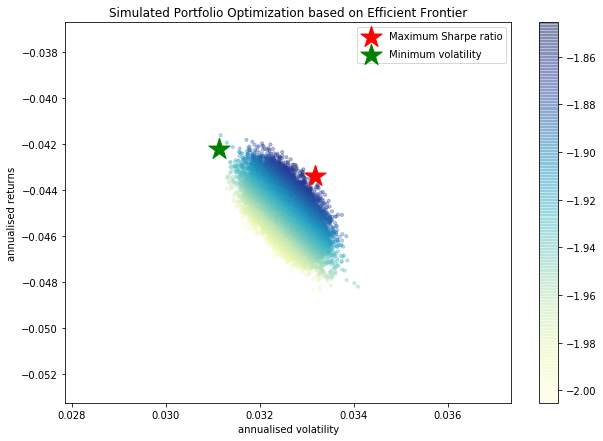

In [40]:
import matplotlib.pyplot as plt
import numpy as np
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [14]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [15]:
def display_calculated_ef_with_random_update(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [ ]:

display_calculated_ef_with_random_update(mean_returns, cov_matrix, num_portfolios, risk_free_rate)